In [1]:
from rdkit import Chem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import os, sys
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],  # or Helvetica/DejaVu Sans
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.2,
    "axes.grid": True,
    "grid.color": "#E0E0E0",
    "grid.linestyle": "--",
    "grid.linewidth": 0.8,
    "legend.frameon": True,
    "legend.fancybox": True,
    "legend.framealpha": 0.8,
    "legend.facecolor": "white",
    "legend.edgecolor": "#E0E0E0",
    "figure.dpi": 340
})



In [2]:
from rdkit import Chem

def find_duplicate_indices(df, smiles_col='SMILES'):
    """Finds higher indices of duplicate molecules based on canonical SMILES."""
    # Compute canonical SMILES
    canonical_smiles = df[smiles_col].apply(
        lambda s: Chem.MolToSmiles(Chem.MolFromSmiles(s)) if pd.notnull(s) else None
    )

    smiles_to_indices = {}
    for idx, can_smi in canonical_smiles.items():
        if can_smi is None:
            continue
        smiles_to_indices.setdefault(can_smi, []).append(idx)

    duplicate_pairs = []
    to_drop = set()
    for indices in smiles_to_indices.values():
        if len(indices) > 1:
            duplicate_pairs.extend([(i, j) for i in indices for j in indices if i < j])
            # Keep lowest index, drop others
            to_drop.update(sorted(indices)[1:])

    return sorted(to_drop), duplicate_pairs


 # 1. Load molecular weights and functional groups

In [3]:
fun_groups = pd.read_csv('../data/NEIMS/Franklin_TMS-v2/fun_groups.csv')
# Find duplicates in fun_groups
to_drop, duplicate_pairs = find_duplicate_indices(fun_groups, smiles_col='SMILES')
print(to_drop)
# Drop from both relevant DataFrames
fun_groups = fun_groups.drop(index=to_drop)


print(f"Dropped {len(to_drop)} duplicate molecules.")

fun_groups

[11, 21, 26, 49, 53, 61, 62, 65]
Dropped 8 duplicate molecules.


amine, primary  amine, secondary  amine, tertiary  alkane CH  alkene CH  \
0                0                 0                0         24          8   
1                0                 0                0         18          2   
2                0                 0                0         15          1   
3                0                 0                0          0          0   
4                0                 0                0         30          0   
..             ...               ...              ...        ...        ...   
63               0                 0                0         38          2   
64               0                 0                0         14          0   
66               0                 0                0         18          0   
67               0                 0                0         33          0   
68               0                 0                0         22          0   

    aromatic CH  carbonyl  hydroxyl (alkyl)  carboxylic acid  ester, all  ...  \
0             0         0                 0                0           0  ...   
1             0         2                 0                0           0  ...   
2             0         0                 0                0           1  ...   
3             7         0                 0                0           0  ...   
4             0         0                 0                0           1  ...   
..          ...       ...               ...              ...         ...  ...   
63            0         0                 0                0           0  ...   
64            0         0                 0                0           0  ...   
66            4         0                 0                0           0  ...   
67            3         0                 0                0           0  ...   
68            0         0                 0                0           0  ...   

    amine, aromatic  nitroester  C=C-C=O in non-aromatic ring  \
0                 0           0                             0   
1                 0           0                             0   
2                 0           0                             1   
3                 1           0                             0   
4                 0           0                             0   
..              ...         ...                           ...   
63                0           0                             0   
64                0           0                             0   
66                0           0                             0   
67                0           0                             0   
68                0           0                             0   

    C=C (non-aromatic)  nC-OHside-a  \
0                    5            0   
1                    1            0   
2                    1            0   
3                    0            0   
4                    0            0   
..                 ...          ...   
63                   1            0   
64                   0            4   
66                   0            0   
67                   0            0   
68                   0            0   

                                               SMILES  oxygen_count  \
0               CC(C)=CCC/C(C)=C/CC/C(C)=C/CCC(=C)C=C             0   
1                  CC(=O)C=CC1(C)C(=O)C2(CCC1(C)C)CO2             3   
2                       CC1(C)CCC[C@@]2(C)OC(=O)C=C12             2   
3                        NC1=CC2=C(C=C1)NC3=C2C=CC=C3             0   
4                       CC(C)CCCC(C)CCCC1(C)CCC(=O)O1             2   
..                                                ...           ...   
63               CCCCCC/C=C\CCCCCCCCC(=O)O[Si](C)(C)C             2   
64                       C[Si](C)(C)OC(=O)C1CCC(=O)N1             3   
66      C[Si](C)(C)OC(=O)C1=CC=CC=C1C(=O)O[Si](C)(C)C             4   
67  COC1=CC(C(CO[Si](C)(C)C)O[Si](C)(C)C)=CC=C1O[S...             4   
68               C[Si](C)(C)OC(=O)CCC(=O)O[Si](C)(C

In [4]:
mol_w =  pd.read_csv('../data/NEIMS/Franklin_TMS-v2/SMILES_arom_molecular_basic.csv')
mol_w = mol_w.drop(index=to_drop)
from rdkit import Chem

def count_all_atoms_with_H(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    mol_with_H = Chem.AddHs(mol)
    return mol_with_H.GetNumAtoms()

# Apply to your DataFrame
mol_w['atom_count_with_H'] = mol_w['SMILES'].apply(count_all_atoms_with_H)

mol_w['atom_count_with_H']

0     52
1     37
2     29
3     24
4     48
      ..
63    63
64    28
66    42
67    61
68    38
Name: atom_count_with_H, Length: 61, dtype: int64

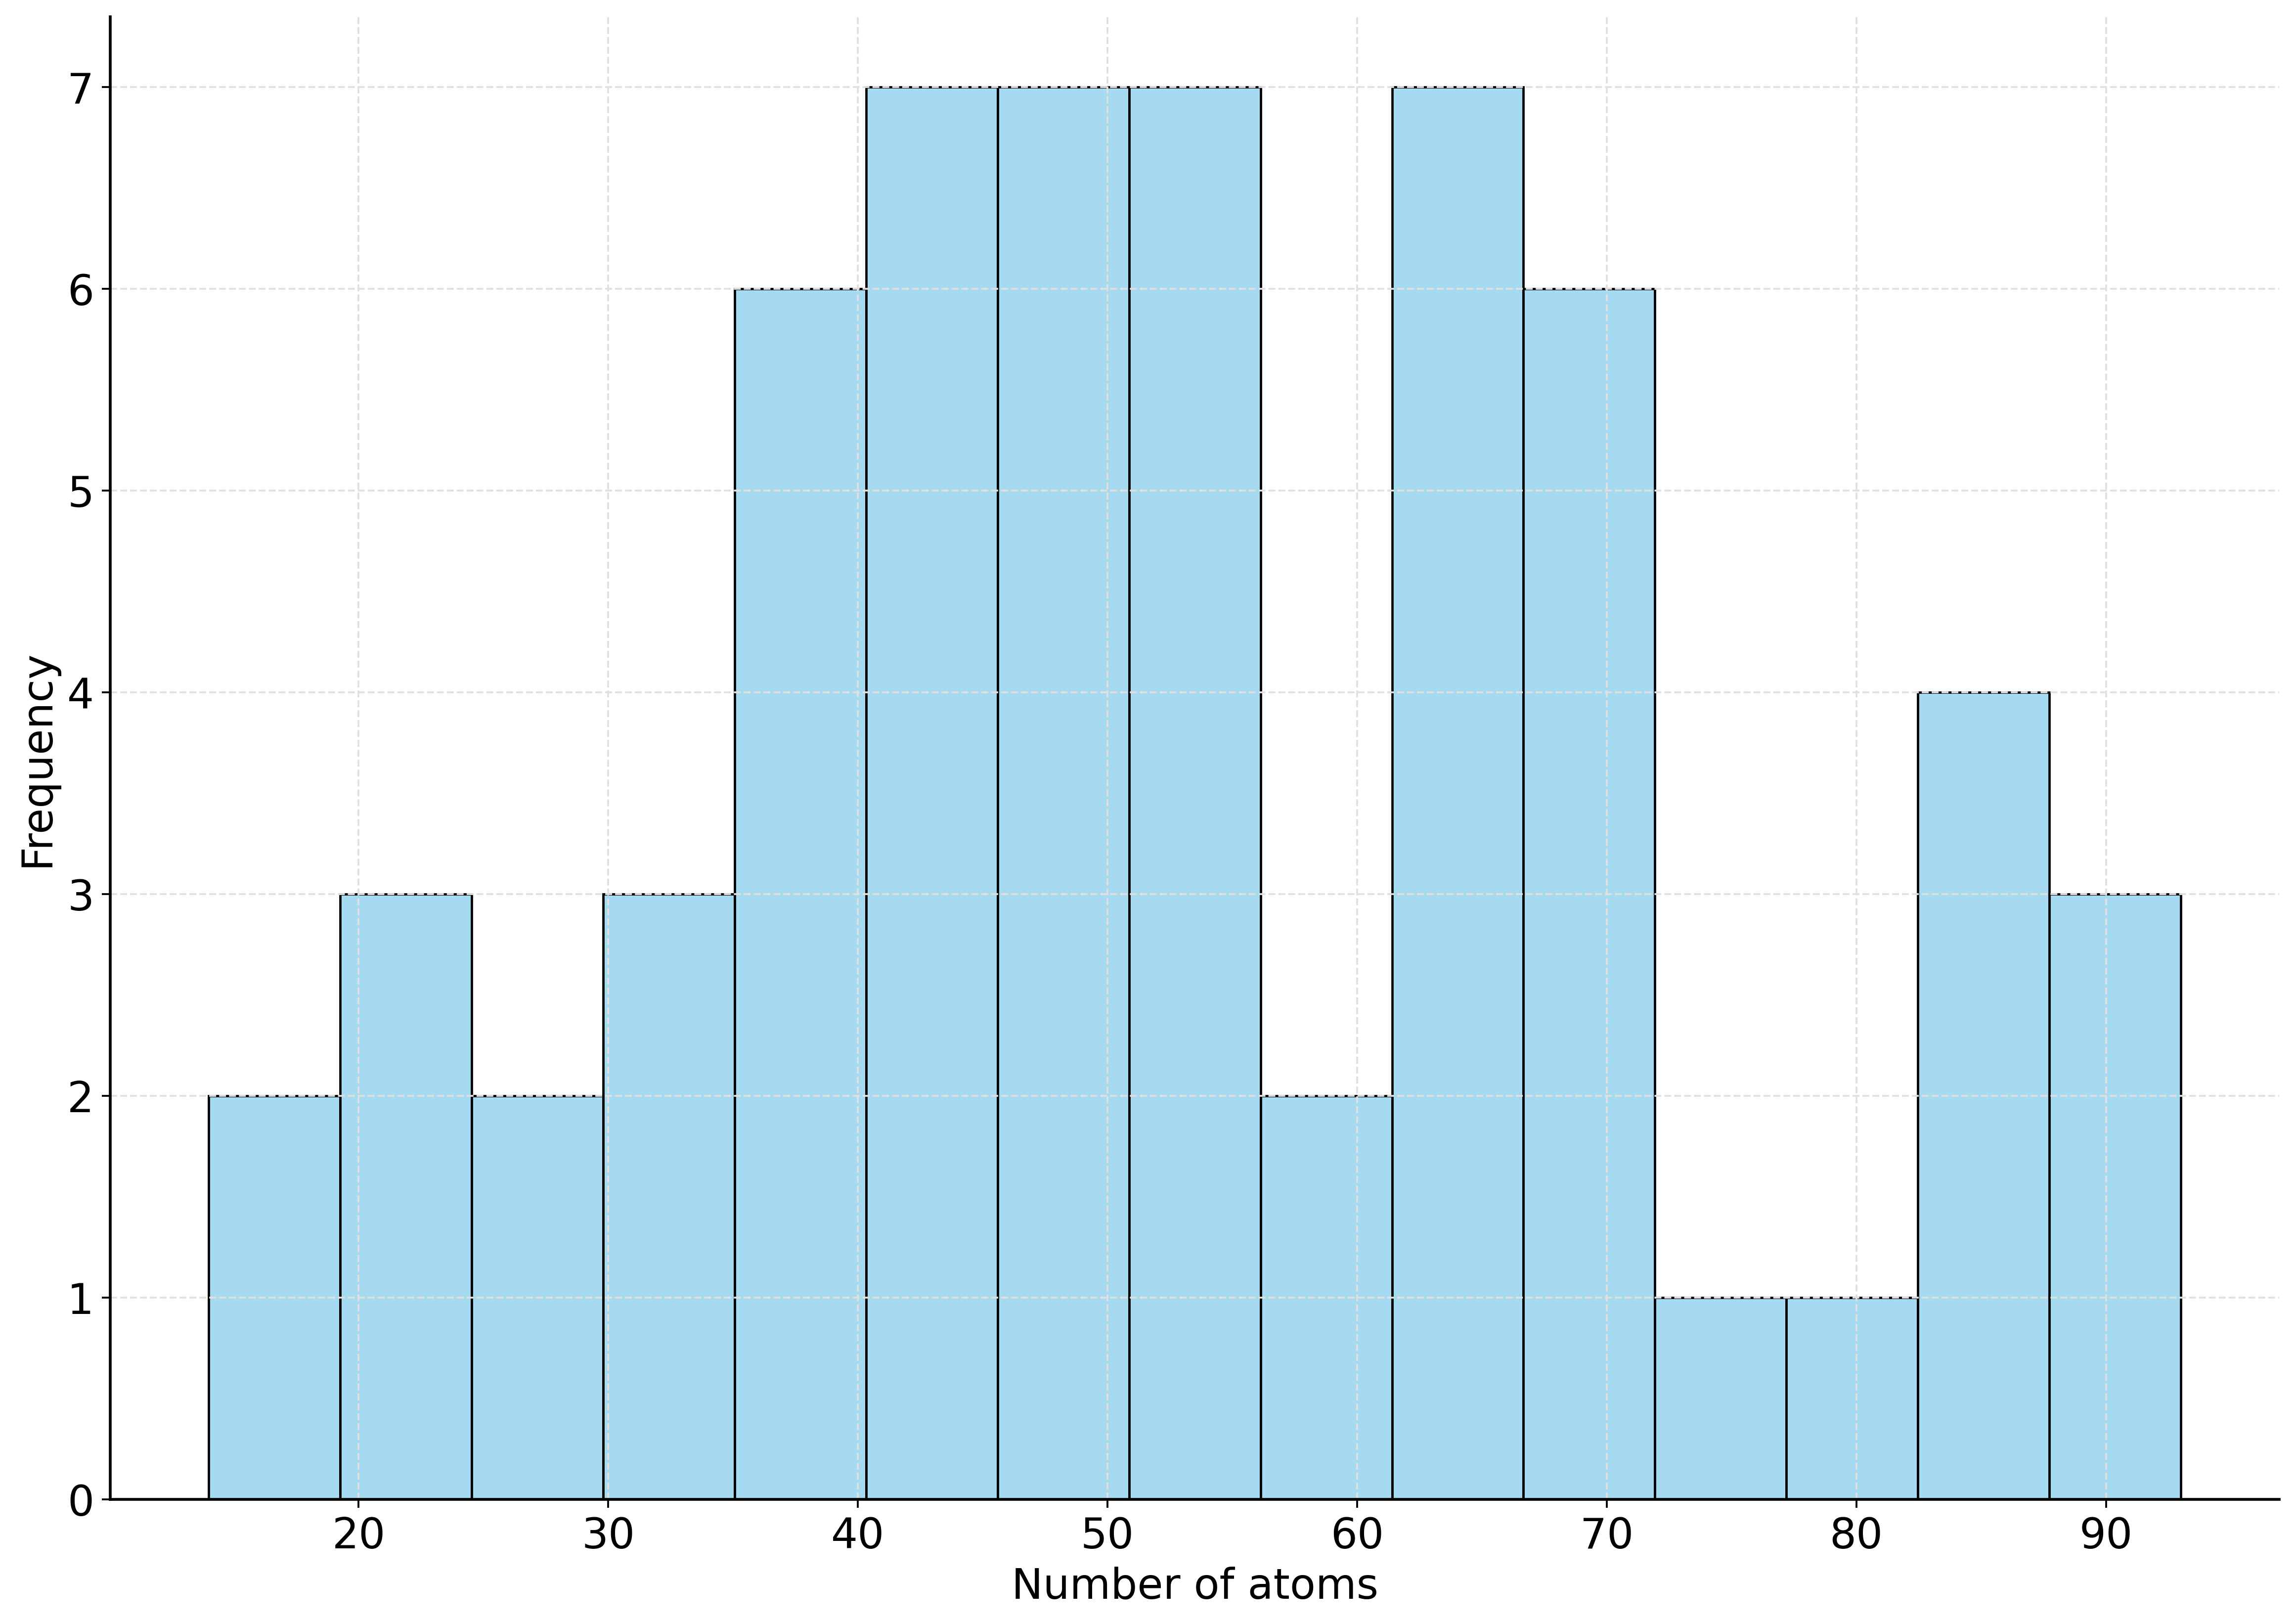

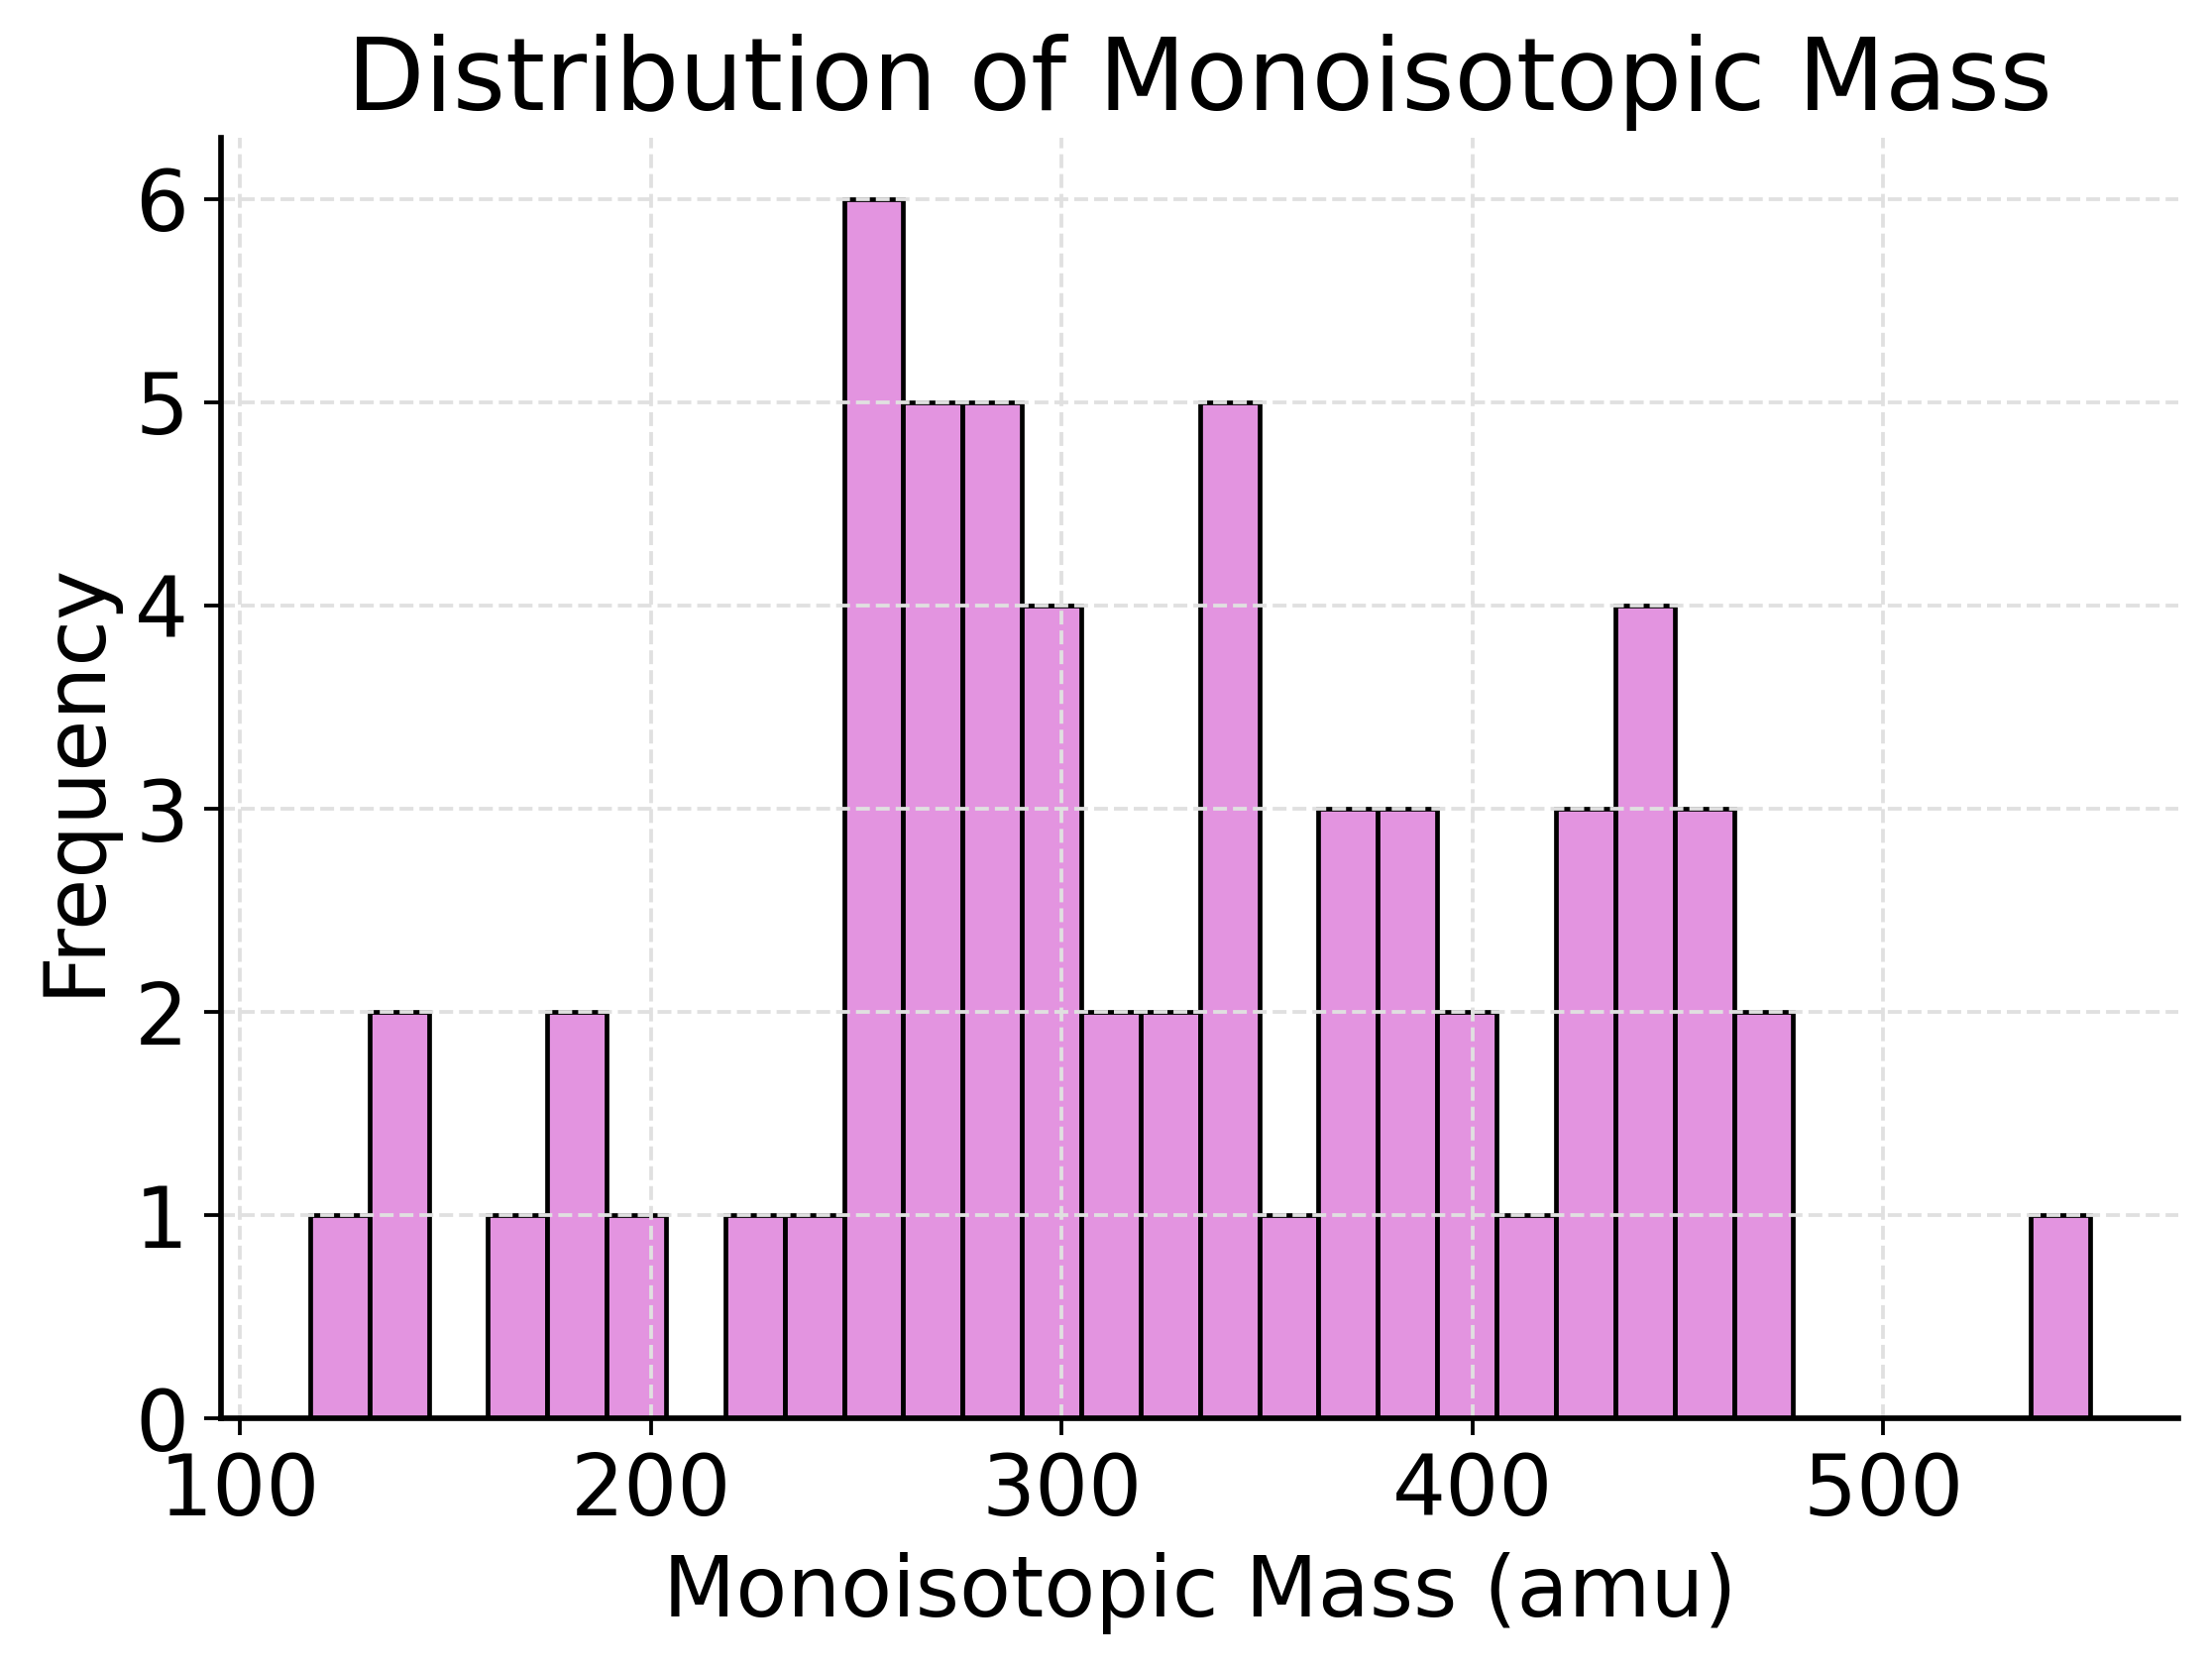

<Figure size 4760x3400 with 0 Axes>

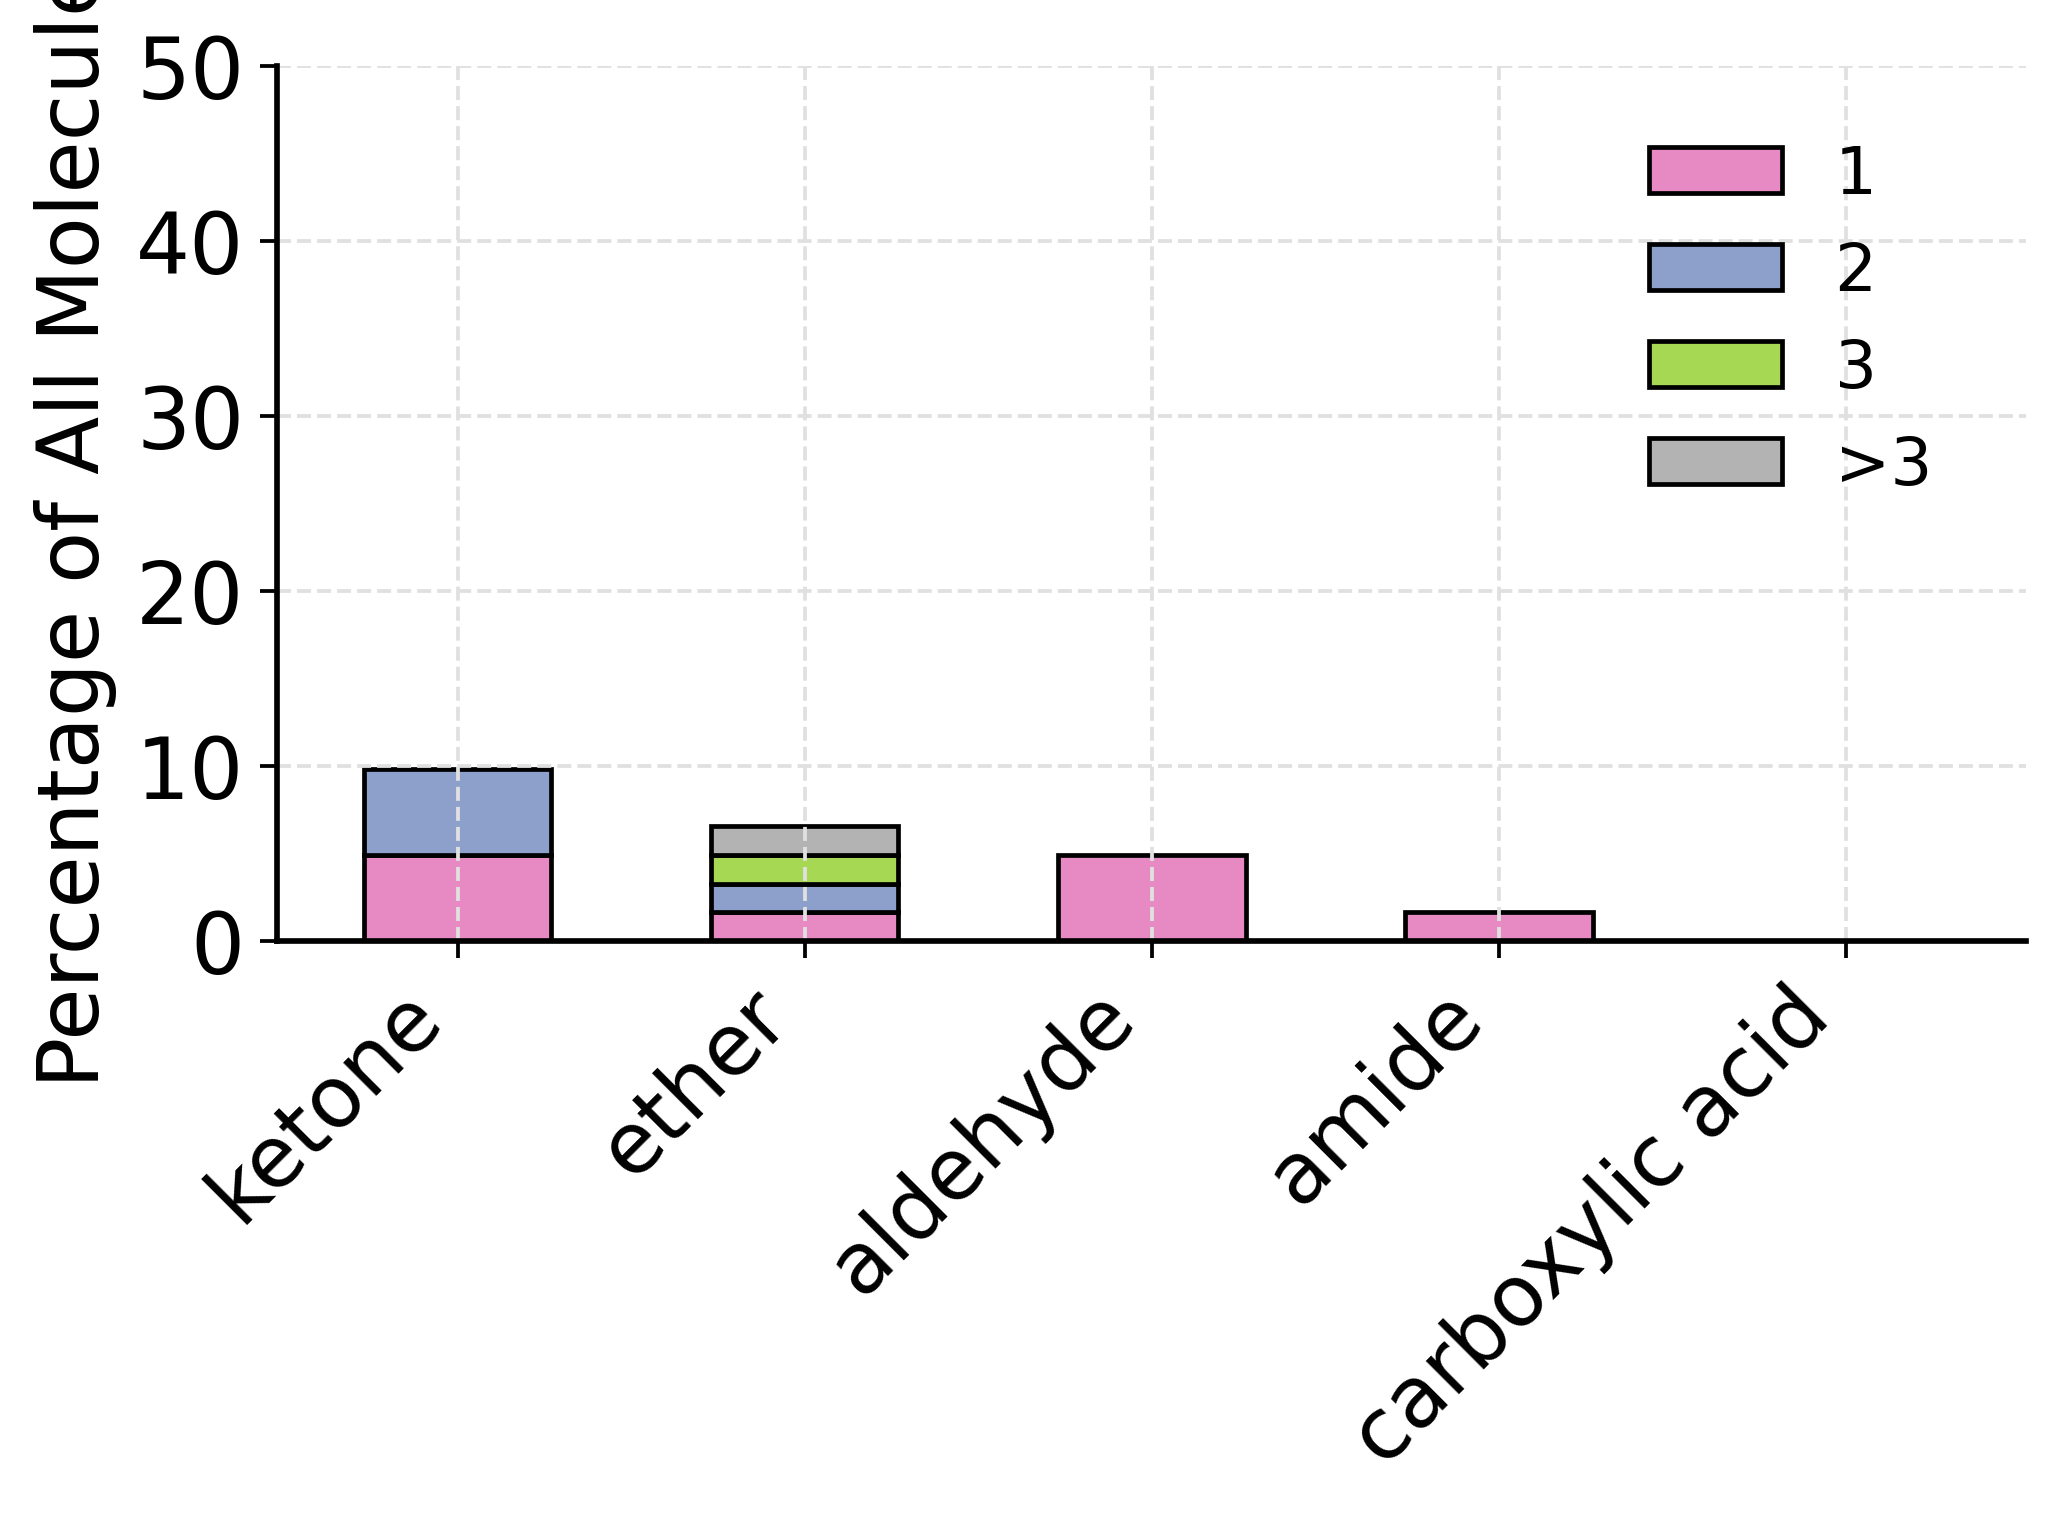

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors

plt.rcParams.update({'font.size': 18})  # Set global font size to 14

# --- 1. Histogram of molecular size ---
plt.figure(figsize=(14, 10))  # 504 pixels wide
sns.histplot(mol_w["atom_count_with_H"], bins=15, kde=False, color="skyblue")  # disable kde line
#plt.title("Distribution of Atom Count")
plt.xlabel("Number of atoms")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig('molsize_franklin_TMS.png', dpi=340)
plt.show()

# --- 2. Monoisotopic Mass Histogram ---
def smiles_to_monoisotopic_mass(smiles: str) -> float:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return Descriptors.ExactMolWt(mol)
    except Exception:
        return None

if 'SMILES' in fun_groups.columns:
    fun_groups['monoisotopic_mass'] = fun_groups['SMILES'].apply(smiles_to_monoisotopic_mass)
    mono_masses = fun_groups['monoisotopic_mass'].dropna()

    if not mono_masses.empty:
        fig, ax = plt.subplots(figsize=(7, 5))
        
        sns.histplot(mono_masses, bins=30, kde=False, color="orchid", ax=ax)
        
        ax.set_title("Distribution of Monoisotopic Mass")
        ax.set_xlabel("Monoisotopic Mass (amu)")
        ax.set_ylabel("Frequency")
        
        # Adjust margins
        fig.subplots_adjust(top=0.88, right=0.95, left=0.12, bottom=0.12)
        
        # Save figure with bbox_inches='tight'
        fig.savefig('monoisotopic_mass_franklin_TMS.png', dpi=340, bbox_inches='tight')
        plt.show()

    else:
        print("Warning: No valid monoisotopic masses could be calculated from SMILES.")
else:
    print("Warning: No 'SMILES' column found, skipping monoisotopic mass plot.")

# --- Functional Group Analysis ---
non_fun_cols = ['monoisotopic_mass',
    'SMILES', 'molar_mass', 'atom_count', 'oxygen_count', 
    'aromatic_ring', 'non_aromatic_ring', 'carbon number', 'fingerprint',
    "C=C (non-aromatic)", "ester, all", "C=C-C=O in non-aromatic ring",
    "ether, aromatic", "ether (alicyclic)"
]

# Drop specific unwanted functional groups
fun_group_cols = [
    col for col in fun_groups.columns
    if col not in non_fun_cols
    and col != "carbonyl"
    and "CH" not in col
    and "aromatic" not in col
    and "secondary" not in col
    and "nC-OHside-a" not in col
]

# Count how many molecules contain each group
group_presence = (fun_groups[fun_group_cols] > 0).sum()
top5 = group_presence.sort_values(ascending=False).head(5).index

# Total molecules
n_total = len(fun_groups)

# Prepare stacked values as absolute fractions of dataset
bin_labels = ['1', '2', '3', '>3']
stacked_absolute = pd.DataFrame(index=top5, columns=bin_labels)

for group in top5:
    series = fun_groups[group]
    filtered = series[series > 0]

    counts = {
        '1': (filtered == 1).sum(),
        '2': (filtered == 2).sum(),
        '3': (filtered == 3).sum(),
        '>3': (filtered > 3).sum()
    }

    # Normalize by total dataset
    stacked_absolute.loc[group] = [v / n_total * 100 for v in counts.values()]

# --- Plot Functional Group Distribution ---
plt.figure(figsize=(14, 10))
stacked_absolute = stacked_absolute.astype(float)

colors = ['#E78AC3', '#8DA0CB', '#A6D854', '#B3B3B3']  # pink, blue, green, gray

stacked_absolute.plot(
    kind='bar',
    stacked=True,
    color=colors,
    width=0.54,
    edgecolor='black'
)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage of All Molecules")
plt.ylim(0, 50)

# Legend inside plot
plt.legend(
    title=None,
    loc='upper right',
    bbox_to_anchor=(0.98, 0.98),
    frameon=False,
    fontsize=14
)

plt.tight_layout()
plt.savefig('fungroups_franklin_TMS.png', dpi=340)
plt.show()


# Compute percentages

In [6]:
import os
import subprocess

base = "../data/NEIMS/Franklin_TMS-v2/"

for i in range(69):  # 0000 ... 0068
    folder = f"{i:04d}"
        
    ref = os.path.join(base, folder, "exp.msp")
    sims = [os.path.join(base, folder, "annotated.sdf"),
        os.path.join(base, folder, "qcxms.csv")]
    
    out = os.path.join(base, folder, "results_thresh1_bin1")

    if os.path.isfile(ref):
        cmd = [
            "python", "../src/features/compare_spectra.py",
            "--reference", ref,
            "--simulated", *sims,
            "--output", out,
            "--threshold", "1",
            "--top_n_peaks", "0",
        ]
        print("Running:", " ".join(cmd))
        subprocess.run(cmd)
    else:
        print(f"Skipping {folder} (no reference file found)")


Running: python ../src/features/compare_spectra.py --reference ../data/NEIMS/Franklin_TMS-v2/0000/exp.msp --simulated ../data/NEIMS/Franklin_TMS-v2/0000/annotated.sdf ../data/NEIMS/Franklin_TMS-v2/0000/qcxms.csv --output ../data/NEIMS/Franklin_TMS-v2/0000/results_thresh1_bin1 --threshold 1 --top_n_peaks 0
Running: python ../src/features/compare_spectra.py --reference ../data/NEIMS/Franklin_TMS-v2/0001/exp.msp --simulated ../data/NEIMS/Franklin_TMS-v2/0001/annotated.sdf ../data/NEIMS/Franklin_TMS-v2/0001/qcxms.csv --output ../data/NEIMS/Franklin_TMS-v2/0001/results_thresh1_bin1 --threshold 1 --top_n_peaks 0
Running: python ../src/features/compare_spectra.py --reference ../data/NEIMS/Franklin_TMS-v2/0002/exp.msp --simulated ../data/NEIMS/Franklin_TMS-v2/0002/annotated.sdf ../data/NEIMS/Franklin_TMS-v2/0002/qcxms.csv --output ../data/NEIMS/Franklin_TMS-v2/0002/results_thresh1_bin1 --threshold 1 --top_n_peaks 0
Running: python ../src/features/compare_spectra.py --reference ../data/NEIMS/Fr

In [7]:
import os
import pandas as pd

base_path = "../data/NEIMS/Franklin_TMS-v2/"
folder_names = [f"{i:04d}" for i in range(69)]

# ---------------- Collect reference peak recovery ----------------
all_ref = []

for folder in folder_names:
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    ref_file = os.path.join(folder_path, "results_thresh1_bin1_pct_ref_peaks.csv")
    if not os.path.isfile(ref_file):
        continue

    df = pd.read_csv(ref_file)
    df['folder'] = folder  # add molecule ID
    df.rename(columns={df.columns[0]: 'Sim_Type'}, inplace=True)
    all_ref.append(df)

combined_ref = pd.concat(all_ref, ignore_index=True)

pivot_pct_ref = combined_ref.pivot(
    index='folder',
    columns='Sim_Type',
    values='Pct_Ref_Peaks_Recovered'
)
pivot_pct_ref.columns.name = None
pivot_pct_ref.reset_index(inplace=True)

# ---------------- Collect simulated peaks in reference ----------------
all_sim = []

for folder in folder_names:
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    sim_file = os.path.join(folder_path, "results_thresh1_bin1_pct_sim_in_ref.csv")
    if not os.path.isfile(sim_file):
        continue

    df = pd.read_csv(sim_file)
    df['folder'] = folder
    df.rename(columns={df.columns[0]: 'Sim_Type'}, inplace=True)
    all_sim.append(df)

combined_sim = pd.concat(all_sim, ignore_index=True)

pivot_pct_sim = combined_sim.pivot(
    index='folder',
    columns='Sim_Type',
    values='Pct_Sim_Peaks_in_Exp'
)
pivot_pct_sim.columns.name = None
pivot_pct_sim.reset_index(inplace=True)

# ---------------- Display ----------------
print("Reference Peaks Recovered (%):")
display(pivot_pct_ref.head())

print("\nSimulated Peaks in Reference (%):")
display(pivot_pct_sim.head())


Reference Peaks Recovered (%):


folder  annotated.sdf  qcxms.csv
0   0000     100.000000  94.117647
1   0001      89.444444  83.888889
2   0002      93.975904  87.951807
3   0003      98.529412  95.588235
4   0004      55.056180  85.393258


Simulated Peaks in Reference (%):


folder  annotated.sdf  qcxms.csv
0   0000      49.275362  41.290323
1   0001      97.575758  94.968553
2   0002      71.559633  73.000000
3   0003      67.000000  68.421053
4   0004      89.090909  52.054795

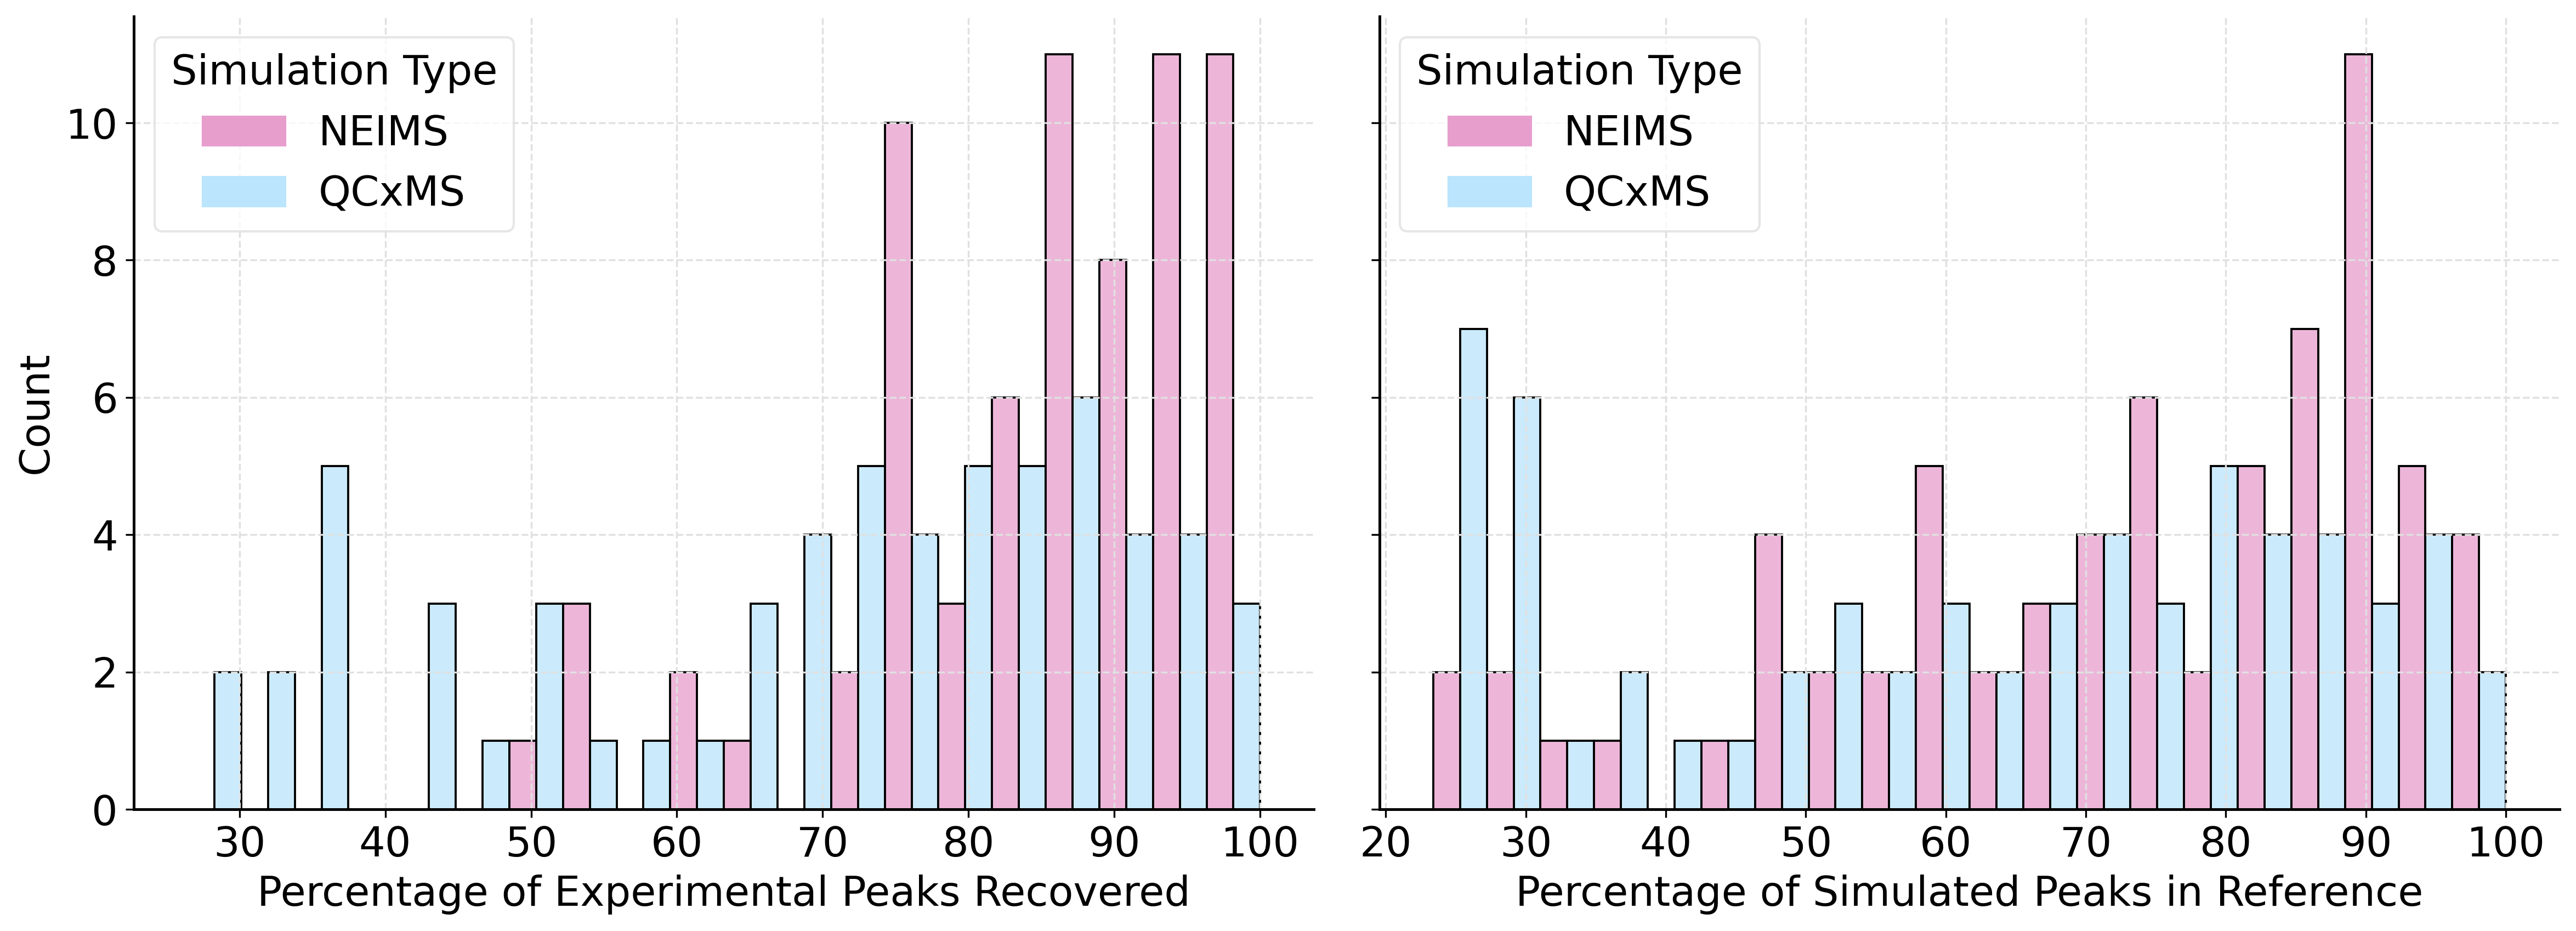

/tmp/hsandstr/29617177/ipykernel_883811/164797181.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/hsandstr/29617177/ipykernel_883811/164797181.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


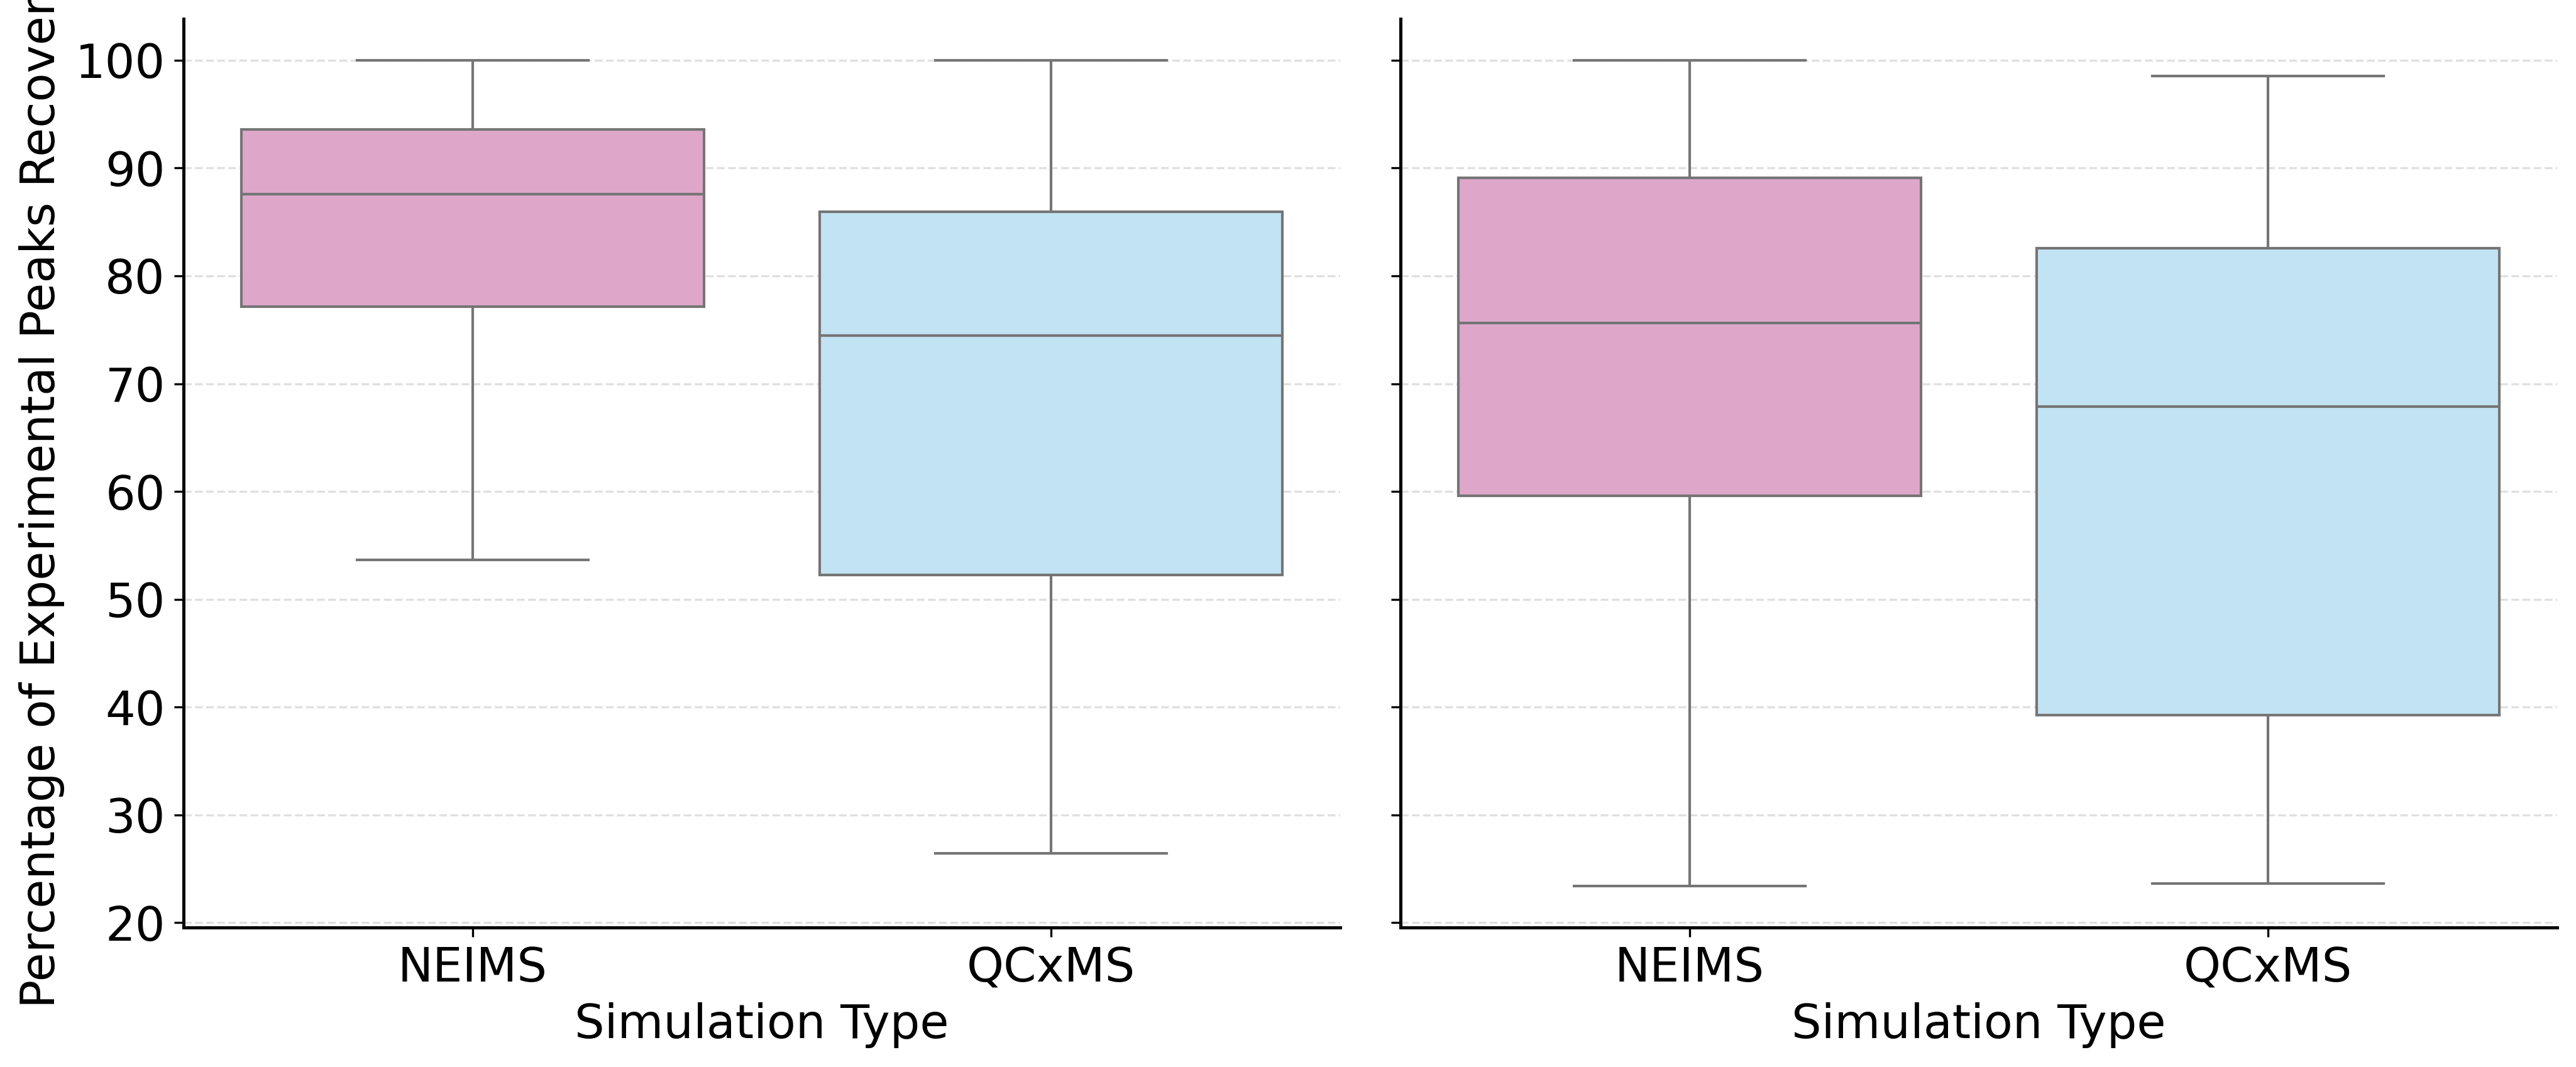

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd

# ---------------- Matplotlib style ----------------
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.2,
    "axes.grid": True,
    "grid.color": "#E0E0E0",
    "grid.linestyle": "--",
    "grid.linewidth": 0.8,
    "legend.frameon": True,
    "legend.fancybox": True,
    "legend.framealpha": 0.8,
    "legend.facecolor": "white",
    "legend.edgecolor": "#E0E0E0",
    "figure.dpi": 300,
    "font.size": 18
})

# ---------------- Prepare long-form data ----------------
long_ref = pivot_pct_ref.melt(
    id_vars='folder', 
    var_name='Sim_Type', 
    value_name='Pct_Ref_Peaks_Recovered'
)
long_sim = pivot_pct_sim.melt(
    id_vars='folder',
    var_name='Sim_Type',
    value_name='Pct_Sim_Peaks_in_Exp'
)

display_name_map = {
    'annotated.sdf': 'NEIMS',
    'qcxms.csv': 'QCxMS',
}
long_ref['Sim_Type_Display'] = long_ref['Sim_Type'].map(display_name_map)
long_sim['Sim_Type_Display'] = long_sim['Sim_Type'].map(display_name_map)

palette = {
    'NEIMS': '#E79ECD',   # pink
    'QCxMS': '#BAE5FC',   # blue
}

# ---------------- Histograms side by side ----------------
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# Histogram for reference peaks recovered
sns.histplot(
    data=long_ref,
    x='Pct_Ref_Peaks_Recovered',
    hue='Sim_Type_Display',
    palette=palette,
    bins=20,
    multiple='dodge',
    edgecolor='black',
    legend=False,
    ax=axes[0]
)
axes[0].set_xlabel('Percentage of Experimental Peaks Recovered')
axes[0].set_ylabel('Count')
patches = [mpatches.Patch(color=color, label=name) for name, color in palette.items()]
axes[0].legend(handles=patches, title='Simulation Type', fontsize=18, title_fontsize=18)

# Histogram for simulated peaks in reference
sns.histplot(
    data=long_sim,
    x='Pct_Sim_Peaks_in_Exp',
    hue='Sim_Type_Display',
    palette=palette,
    bins=20,
    multiple='dodge',
    edgecolor='black',
    legend=False,
    ax=axes[1]
)
axes[1].set_xlabel('Percentage of Simulated Peaks in Reference')
axes[1].set_ylabel('')
axes[1].legend(handles=patches, title='Simulation Type', fontsize=18, title_fontsize=18)

plt.tight_layout()
fig.savefig("peak_overlap_histograms_side_by_side.png", dpi=300, bbox_inches='tight')
plt.show()

# ---------------- Boxplots side by side ----------------
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# Boxplot for reference peaks recovered
sns.boxplot(
    data=long_ref,
    x='Sim_Type_Display',
    y='Pct_Ref_Peaks_Recovered',
    palette=palette,
    showfliers=False,
    ax=axes[0]
)
axes[0].set_xlabel('Simulation Type')
axes[0].set_ylabel('Percentage of Experimental Peaks Recovered')

# Boxplot for simulated peaks in reference
sns.boxplot(
    data=long_sim,
    x='Sim_Type_Display',
    y='Pct_Sim_Peaks_in_Exp',
    palette=palette,
    showfliers=False,
    ax=axes[1]
)
axes[1].set_xlabel('Simulation Type')
axes[1].set_ylabel('')

plt.tight_layout()
fig.savefig("peak_overlap_boxplots_side_by_side.png", dpi=300, bbox_inches='tight')
plt.show()


In [9]:
# Ensure same order
ref_df = pivot_pct_ref.set_index('folder').sort_index()
sim_df = pivot_pct_sim.set_index('folder').sort_index()

# Compute differences
diff = ref_df != sim_df

# Select rows with any differences
rows_with_diff = diff.any(axis=1)

# Print the rows that differ
print("Rows with differences between pivot_pct_ref and pivot_pct_sim:")
print(ref_df[rows_with_diff])
print("\nCorresponding rows in pivot_pct_sim:")
print(sim_df[rows_with_diff])


Rows with differences between pivot_pct_ref and pivot_pct_sim:
        annotated.sdf  qcxms.csv
folder                          
0000       100.000000  94.117647
0001        89.444444  83.888889
0002        93.975904  87.951807
0003        98.529412  95.588235
0004        55.056180  85.393258
...               ...        ...
0064        80.198020  31.683168
0065        88.571429  82.857143
0066        89.743590  53.846154
0067        85.135135  75.675676
0068        90.909091  47.474747

[69 rows x 2 columns]

Corresponding rows in pivot_pct_sim:
        annotated.sdf  qcxms.csv
folder                          
0000        49.275362  41.290323
0001        97.575758  94.968553
0002        71.559633  73.000000
0003        67.000000  68.421053
0004        89.090909  52.054795
...               ...        ...
0064        93.103448  91.428571
0065        75.609756  26.605505
0066        25.547445  28.000000
0067        54.782609  47.863248
0068        79.646018  87.037037

[69 rows x 2 colu

# 2. Load simulation performance correlation matrix

In [10]:
import os
import pandas as pd

base_path = "../data/NEIMS/Franklin_TMS-v2/"
folder_names = [f"{i:04d}" for i in range(69)]

all_counts = []

for folder in folder_names:
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    # Construct the file path for peak counts, e.g. threshold=10
    peak_count_file = os.path.join(folder_path, f"results_thresh1_bin1_peak_counts_thresh1.csv")
    if not os.path.isfile(peak_count_file):
        continue

    df = pd.read_csv(peak_count_file)
    df['folder'] = folder  # add folder column for reference

    all_counts.append(df)

# Combine all folder data
combined_counts = pd.concat(all_counts, ignore_index=True)

combined_counts.columns.name = None
combined_counts.reset_index(inplace=True)  # if you want folder back as a column

pivot_df = combined_counts.pivot(index='folder', columns='Unnamed: 0', values='Peak_Count')
pivot_df.columns.name = None  # remove the columns name
pivot_df.reset_index(inplace=True)
pivot_df.drop(index=to_drop)
pivot_int = pivot_df.astype(int)  # convert to int if not already

# Subtract reference column from all other columns (except reference itself)
diff_df = pivot_int.sub(pivot_int['reference'], axis=0)
combined_counts['Peak_Count'].unique()

array([ 68, 138, 155, 180, 165, 159,  83, 109, 100,  95,  89,  55, 146,
       249, 253, 186, 121, 199,  92,  71,  94, 124,  99, 143, 372, 185,
       211, 317,  84,  76,  97, 365,  87, 140,  67, 187, 162,  70, 169,
       215, 306, 325,   0, 151, 129,  75,  85, 269, 278, 230, 108,  34,
       198,  93, 128, 134,  53, 152, 114, 116, 160,  91,  36,  47, 283,
       209, 201,  63,  58, 167,  69, 158, 122, 145, 224, 149, 213, 178,
       242, 299, 181,  74,  60,  35,  41, 112, 137, 131,  43, 110,  54,
       127,  46, 120, 194, 153,  31,  73,  38,  42, 202, 190, 220,  80,
       232, 226, 184,  57,  48,  56, 135, 203, 166, 115, 255, 244, 189,
       101,  39, 117, 113])

In [11]:
# Exclude 'reference' column if you want

diff_no_ref = diff_df.drop(columns=['reference', 'folder'], errors='ignore')
# Count negatives per column
neg_counts = (diff_no_ref < 0).sum()

# Count positives per column
pos_counts = (diff_no_ref > 0).sum()

print("Negative differences per method:\n", neg_counts)
print("Positive differences per method:\n", pos_counts)


Negative differences per method:
 annotated.sdf    28
qcxms.csv        35
dtype: int64
Positive differences per method:
 annotated.sdf    41
qcxms.csv        34
dtype: int64


In [12]:

base_path = "../data/NEIMS/Franklin_TMS-v2/"
results = []
folder_names = [f"{i:04d}" for i in range(69)] 
# Loop through all subdirectories
for folder in folder_names:

    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue  # Skip non-folder entries

    try:
        # Load similarity matrices
        cosine_df = pd.read_csv(os.path.join(folder_path, "results_thresh1_bin5_cosine_thresh1.csv"), index_col=0)
        wcosine_df = pd.read_csv(os.path.join(folder_path, "results_thresh1_bin5_weighted_cosine_thresh1.csv"), index_col=0)
        tanimoto_df = pd.read_csv(os.path.join(folder_path, "results_thresh1_bin5_tanimoto_thresh1.csv"), index_col=0)

        if "reference" not in cosine_df.index:
            continue  # Skip if no reference

        for method in cosine_df.columns:
            if method == "reference":
                continue  # Skip self-comparison

            results.append({
                "folder": folder,
                "method": method,
                "cosine": cosine_df.at["reference", method],
                "weighted_cosine": wcosine_df.at["reference", method],
                "tanimoto": tanimoto_df.at["reference", method],
            })
    except Exception as e:
        print(f"Skipping {folder} due to error: {e}")

# Create final DataFrame
similarity_df = pd.DataFrame(results)

# Pivot to wide format
similarity_wide_df = similarity_df.pivot(index="folder", columns="method")

# Flatten MultiIndex columns
similarity_wide_df.columns = [
    f"{metric}_{method}" for metric, method in similarity_wide_df.columns
]

# Reset index to turn 'folder' back into a column
similarity_wide_df.reset_index(inplace=True)
similarity_wide_df.drop("folder", inplace=True, axis=1)
similarity_wide_df = similarity_wide_df.drop(index=to_drop)
# Preview result
similarity_wide_df.head()
similarity_wide_df.mean()

cosine_annotated.sdf              819.525215
cosine_qcxms.csv                  626.013351
cosine_qcxms2-dft.csv             375.835347
cosine_qcxms2-xtb.csv             588.583854
weighted_cosine_annotated.sdf     783.754296
weighted_cosine_qcxms.csv         415.182393
weighted_cosine_qcxms2-dft.csv    361.917803
weighted_cosine_qcxms2-xtb.csv    472.482312
tanimoto_annotated.sdf            633.382323
tanimoto_qcxms.csv                461.873096
tanimoto_qcxms2-dft.csv           270.702658
tanimoto_qcxms2-xtb.csv           425.536958
dtype: float64

In [13]:
print(similarity_wide_df.dtypes)
mean = similarity_wide_df.mean(axis=0, skipna=True)
std = similarity_wide_df.std(axis=0, skipna=True)
print(mean)
print(std)

cosine_annotated.sdf              float64
cosine_qcxms.csv                  float64
cosine_qcxms2-dft.csv             float64
cosine_qcxms2-xtb.csv             float64
weighted_cosine_annotated.sdf     float64
weighted_cosine_qcxms.csv         float64
weighted_cosine_qcxms2-dft.csv    float64
weighted_cosine_qcxms2-xtb.csv    float64
tanimoto_annotated.sdf            float64
tanimoto_qcxms.csv                float64
tanimoto_qcxms2-dft.csv           float64
tanimoto_qcxms2-xtb.csv           float64
dtype: object
cosine_annotated.sdf              819.525215
cosine_qcxms.csv                  626.013351
cosine_qcxms2-dft.csv             375.835347
cosine_qcxms2-xtb.csv             588.583854
weighted_cosine_annotated.sdf     783.754296
weighted_cosine_qcxms.csv         415.182393
weighted_cosine_qcxms2-dft.csv    361.917803
weighted_cosine_qcxms2-xtb.csv    472.482312
tanimoto_annotated.sdf            633.382323
tanimoto_qcxms.csv                461.873096
tanimoto_qcxms2-dft.csv         

In [14]:
import pandas as pd
import numpy as np

# similarity_wide_df already without 'folder' column

# 1. Parse columns into MultiIndex (method, metric) by splitting on last underscore
split_cols = similarity_wide_df.columns.to_series().apply(lambda x: pd.Series(x.rsplit('_', 1), index=['method', 'metric']))

similarity_wide_df.columns = pd.MultiIndex.from_frame(split_cols)

# 2. Clean method names (remove file extensions)
similarity_wide_df.columns = similarity_wide_df.columns.set_levels(
    similarity_wide_df.columns.levels[0].str.replace(r'\.csv$|\.sdf$', '', regex=True),
    level=0
)

# 3. Sort columns by metric then method (optional, but neat)
similarity_wide_df = similarity_wide_df.sort_index(axis=1, level=[1,0])

# 4. Prepare a container for results
rows = []

# 5. Loop over each metric and build summary rows
for metric in similarity_wide_df.columns.levels[1]:
    metric_df = similarity_wide_df.xs(metric, axis=1, level=1)  # all methods for this metric
    
    # Mean ± Std
    mean_std = metric_df.mean().round(1).astype(str) + r' \pm ' + metric_df.std().round(1).astype(str)
    rows.append(pd.Series(mean_std, name=f"{metric} Mean r' \pm '  Std"))
    
    # Max
    rows.append(pd.Series(metric_df.max(), name=f"{metric} Max"))
    
    # Min
    rows.append(pd.Series(metric_df.min(), name=f"{metric} Min"))

# 6. Combine all summary rows into a final DataFrame
summary_df = pd.DataFrame(rows)

# 7. Generate LaTeX table
latex_table = summary_df.to_latex(
    caption="Summary statistics for similarity metrics",
    label="tab:similarity_summary",
    float_format="%.1f",
    na_rep="NaN",
    column_format="l" + "r" * summary_df.shape[1],
    bold_rows=True,
    escape=False,
)

print(latex_table)


\begin{table}
\caption{Summary statistics for similarity metrics}
\label{tab:similarity_summary}
\begin{tabular}{lrrr}
\toprule
method & cosine & tanimoto & weighted_cosine \\
\midrule
\textbf{annotated.sdf Mean r' \pm '  Std} & 819.5 \pm 134.9 & 633.4 \pm 157.8 & 783.8 \pm 214.6 \\
\textbf{annotated.sdf Max} & 937.9 & 877.3 & 968.9 \\
\textbf{annotated.sdf Min} & 312.4 & 164.3 & 149.8 \\
\textbf{qcxms.csv Mean r' \pm '  Std} & 626.0 \pm 201.3 & 461.9 \pm 209.3 & 415.2 \pm 225.2 \\
\textbf{qcxms.csv Max} & 991.1 & 982.2 & 996.4 \\
\textbf{qcxms.csv Min} & 127.3 & 58.9 & 69.8 \\
\textbf{qcxms2-dft.csv Mean r' \pm '  Std} & 375.8 \pm 294.4 & 270.7 \pm 266.4 & 361.9 \pm 316.8 \\
\textbf{qcxms2-dft.csv Max} & 983.3 & 966.8 & 993.4 \\
\textbf{qcxms2-dft.csv Min} & 11.8 & 5.9 & 7.9 \\
\textbf{qcxms2-xtb.csv Mean r' \pm '  Std} & 588.6 \pm 201.0 & 425.5 \pm 201.1 & 472.5 \pm 237.8 \\
\textbf{qcxms2-xtb.csv Max} & 943.0 & 864.8 & 960.1 \\
\textbf{qcxms2-xtb.csv Min} & 194.3 & 73.3 & 96.3 \\
\b

## 2.1 Plot box plot of performance

In [15]:
long_df = similarity_wide_df.stack(['method', 'metric']).reset_index()
long_df.columns = ['sample', 'method', 'metric', 'value']





/tmp/hsandstr/29617177/ipykernel_883811/1324644045.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long_df = similarity_wide_df.stack(['method', 'metric']).reset_index()


In [16]:
# assuming your DataFrame is called df
long_df= long_df[~long_df['metric'].str.contains('qcxms2')]




In [17]:
long_df

sample           method         metric       value
0         0           cosine  annotated.sdf  892.927355
1         0           cosine      qcxms.csv  766.971001
4         0         tanimoto  annotated.sdf  669.262571
5         0         tanimoto      qcxms.csv  579.429179
8         0  weighted_cosine  annotated.sdf  849.572797
..      ...              ...            ...         ...
565      68           cosine      qcxms.csv  577.695564
568      68         tanimoto  annotated.sdf  603.508115
569      68         tanimoto      qcxms.csv  400.847598
572      68  weighted_cosine  annotated.sdf  777.339576
573      68  weighted_cosine      qcxms.csv  329.061228

[348 rows x 4 columns]

/tmp/hsandstr/29617177/ipykernel_883811/1029113163.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/hsandstr/29617177/ipykernel_883811/1029113163.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


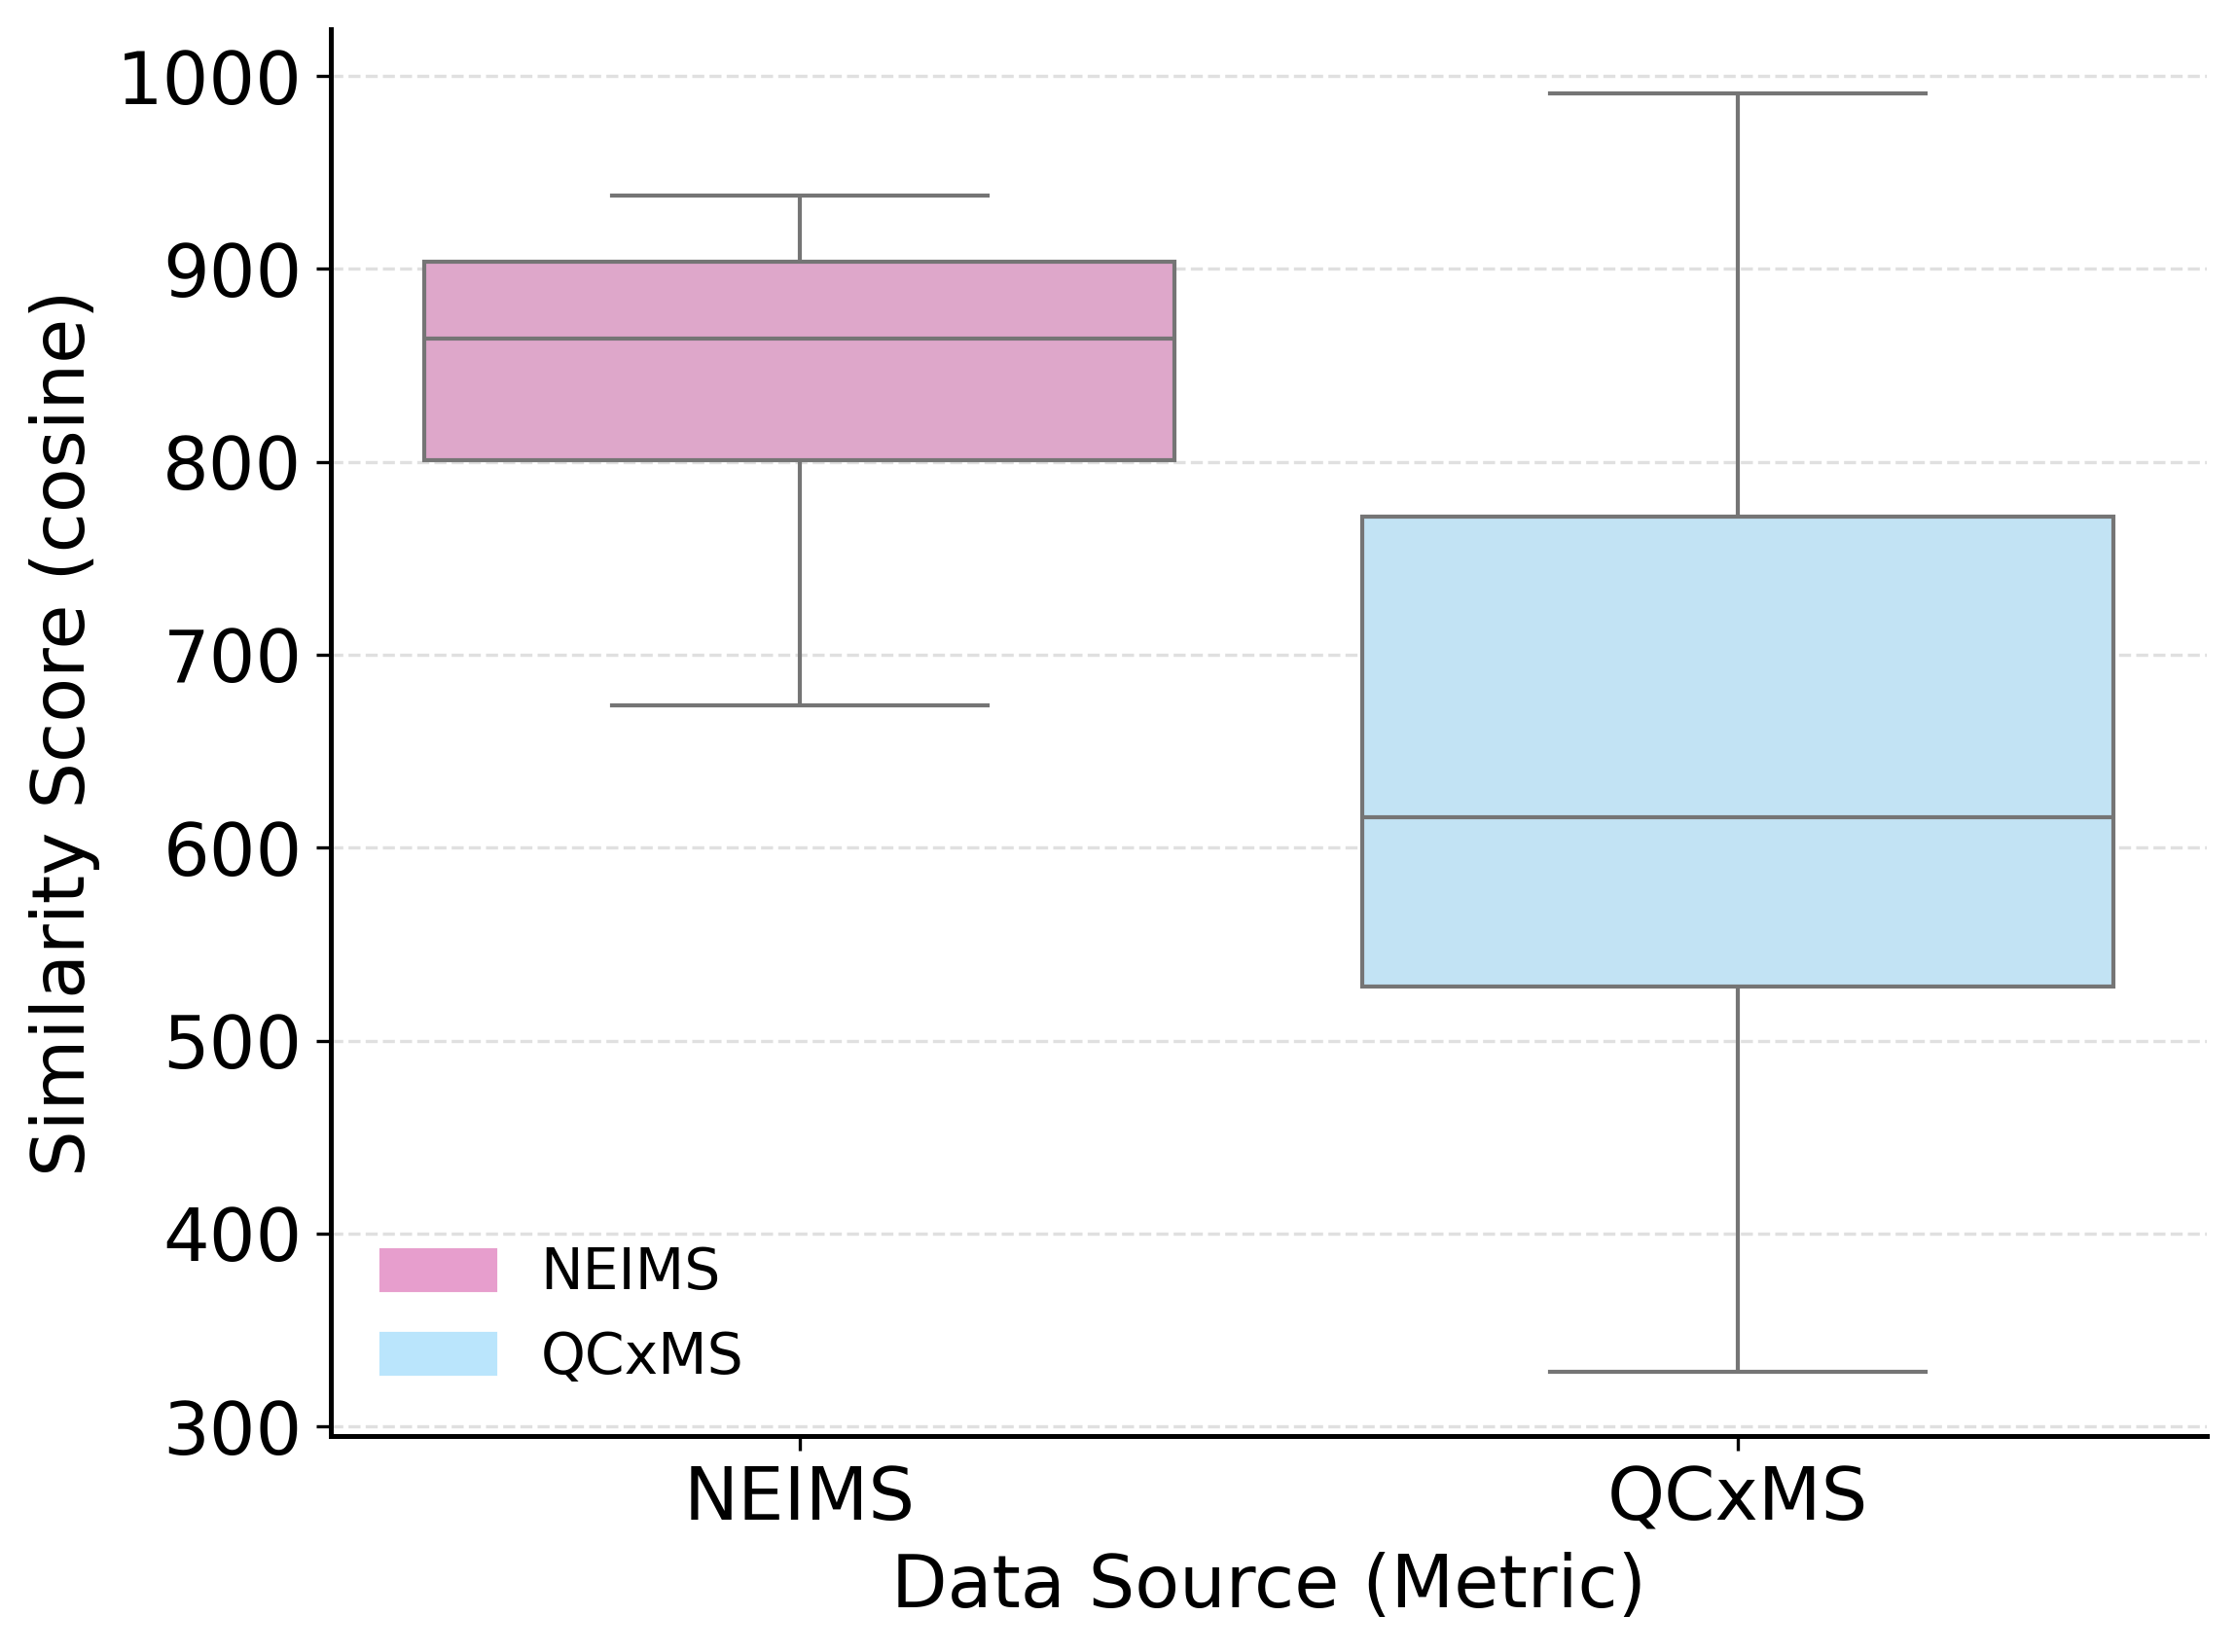

/tmp/hsandstr/29617177/ipykernel_883811/1029113163.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/hsandstr/29617177/ipykernel_883811/1029113163.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


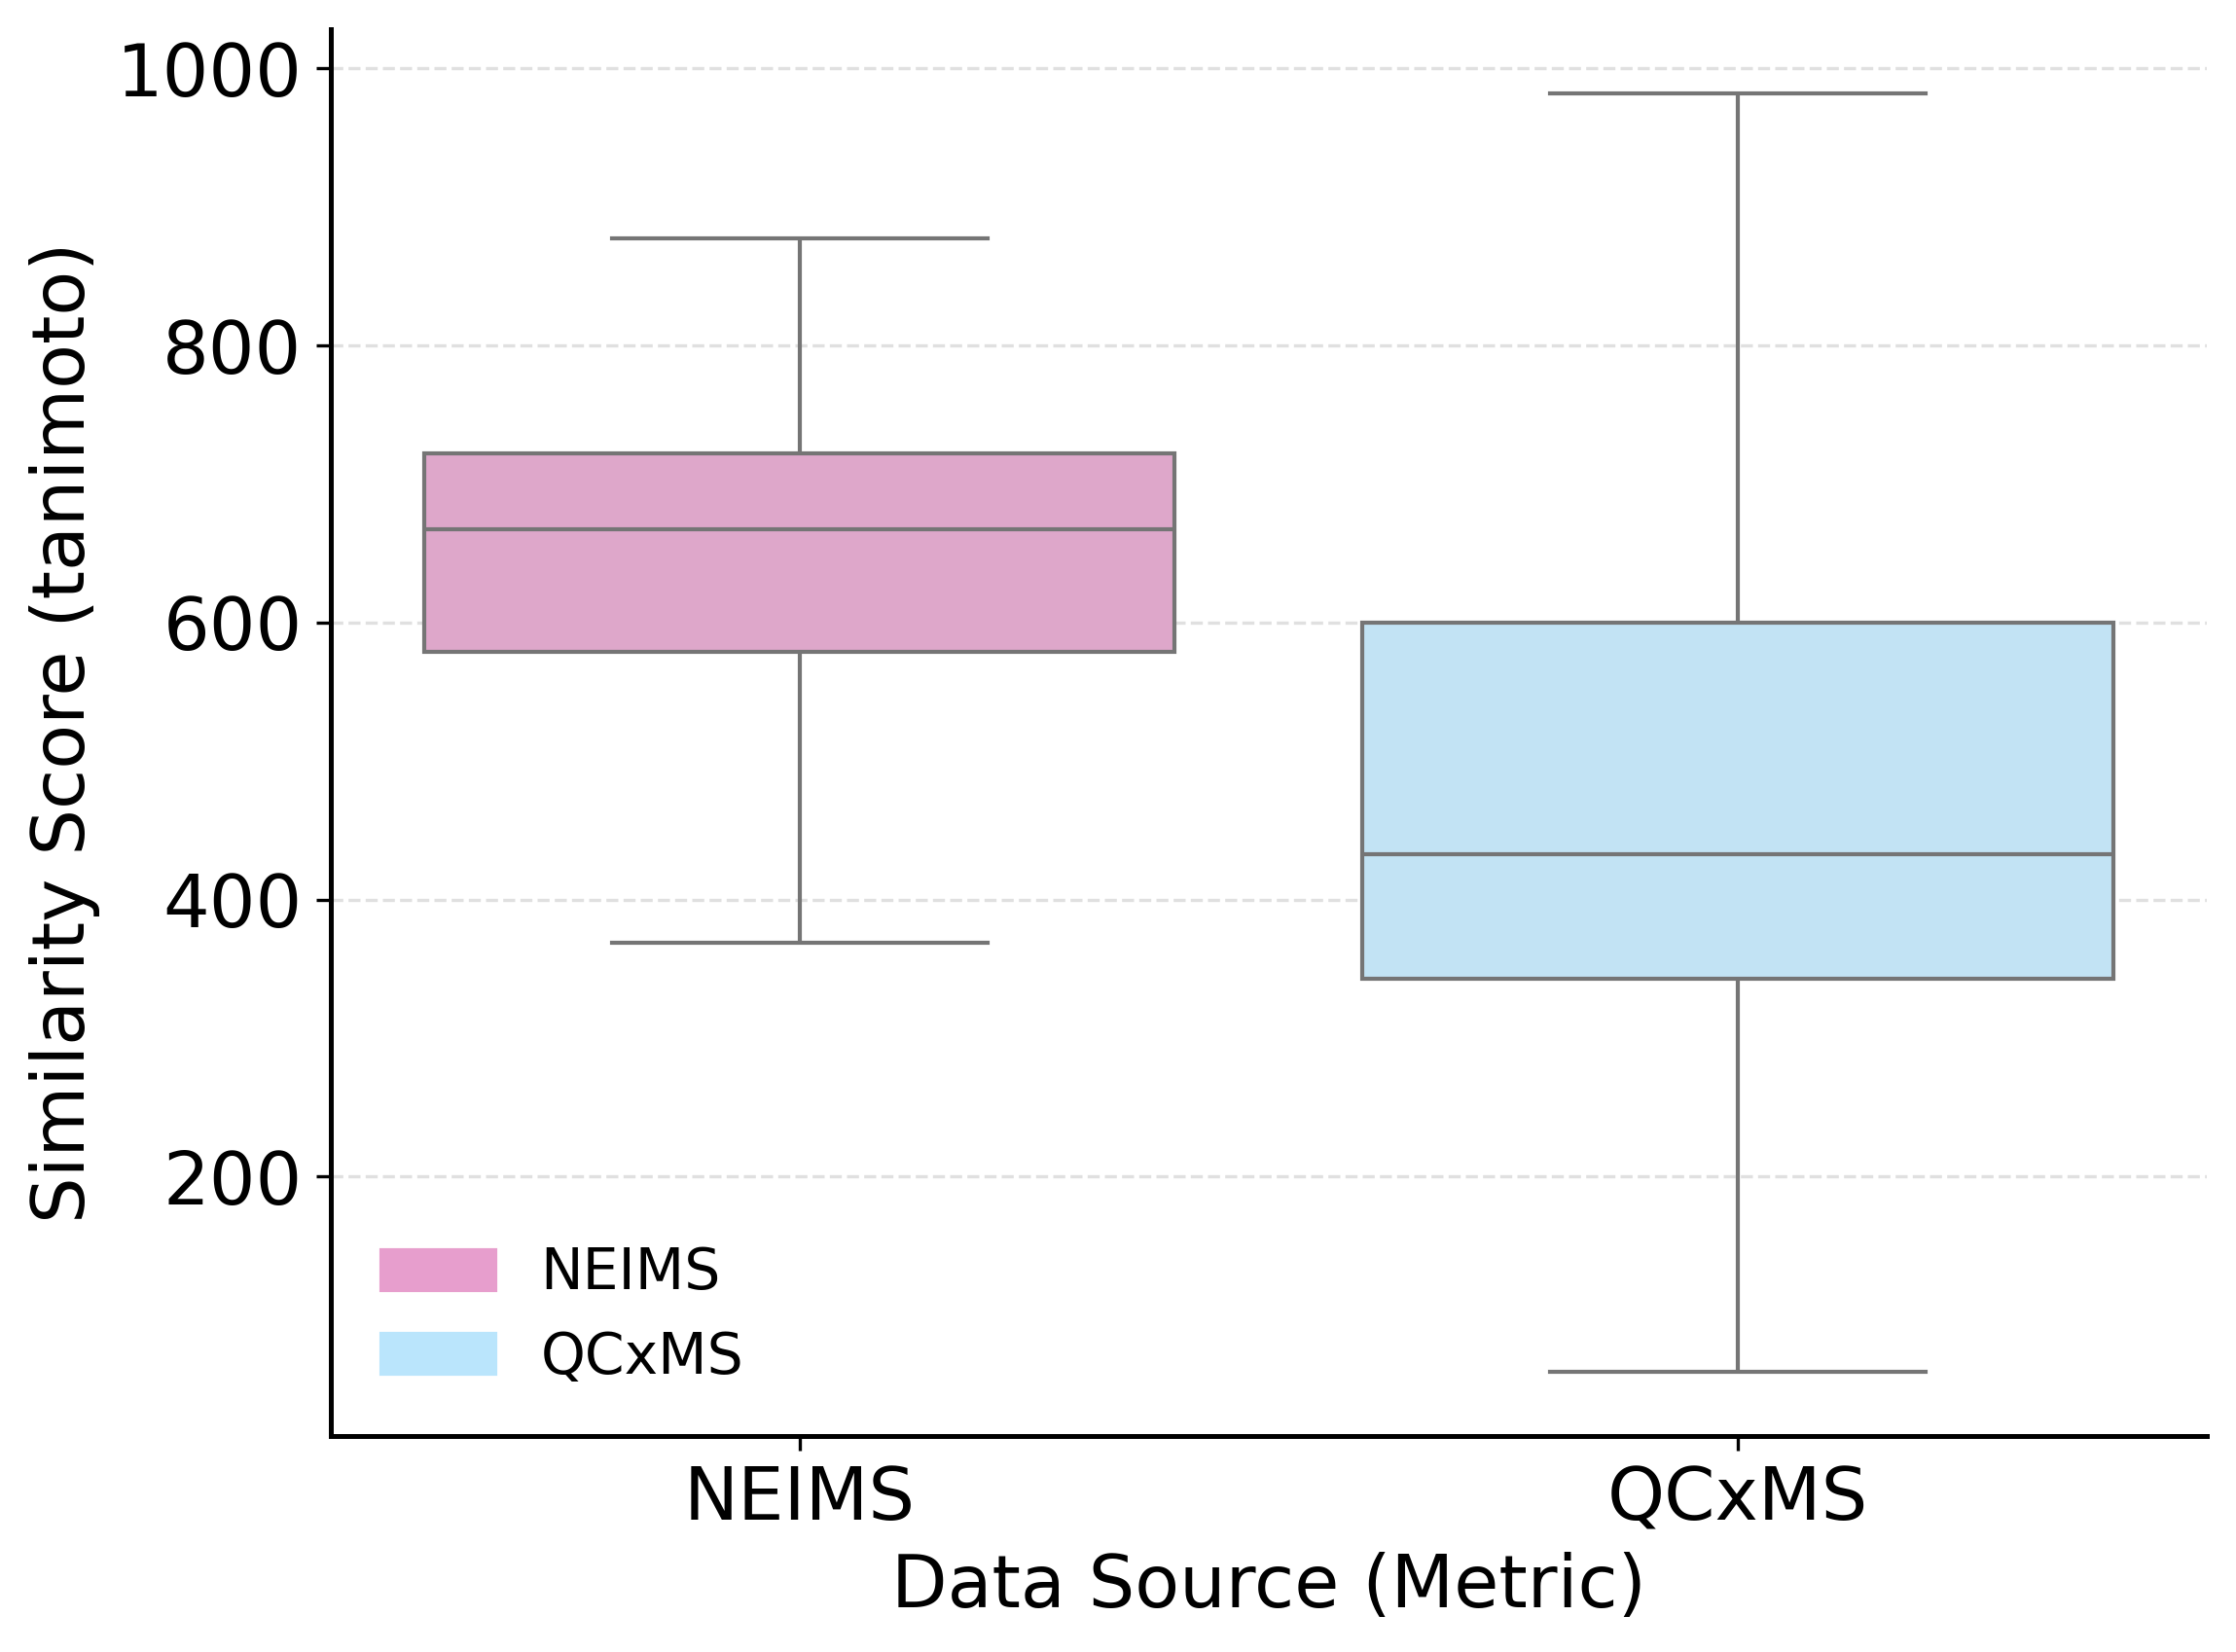

/tmp/hsandstr/29617177/ipykernel_883811/1029113163.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/hsandstr/29617177/ipykernel_883811/1029113163.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


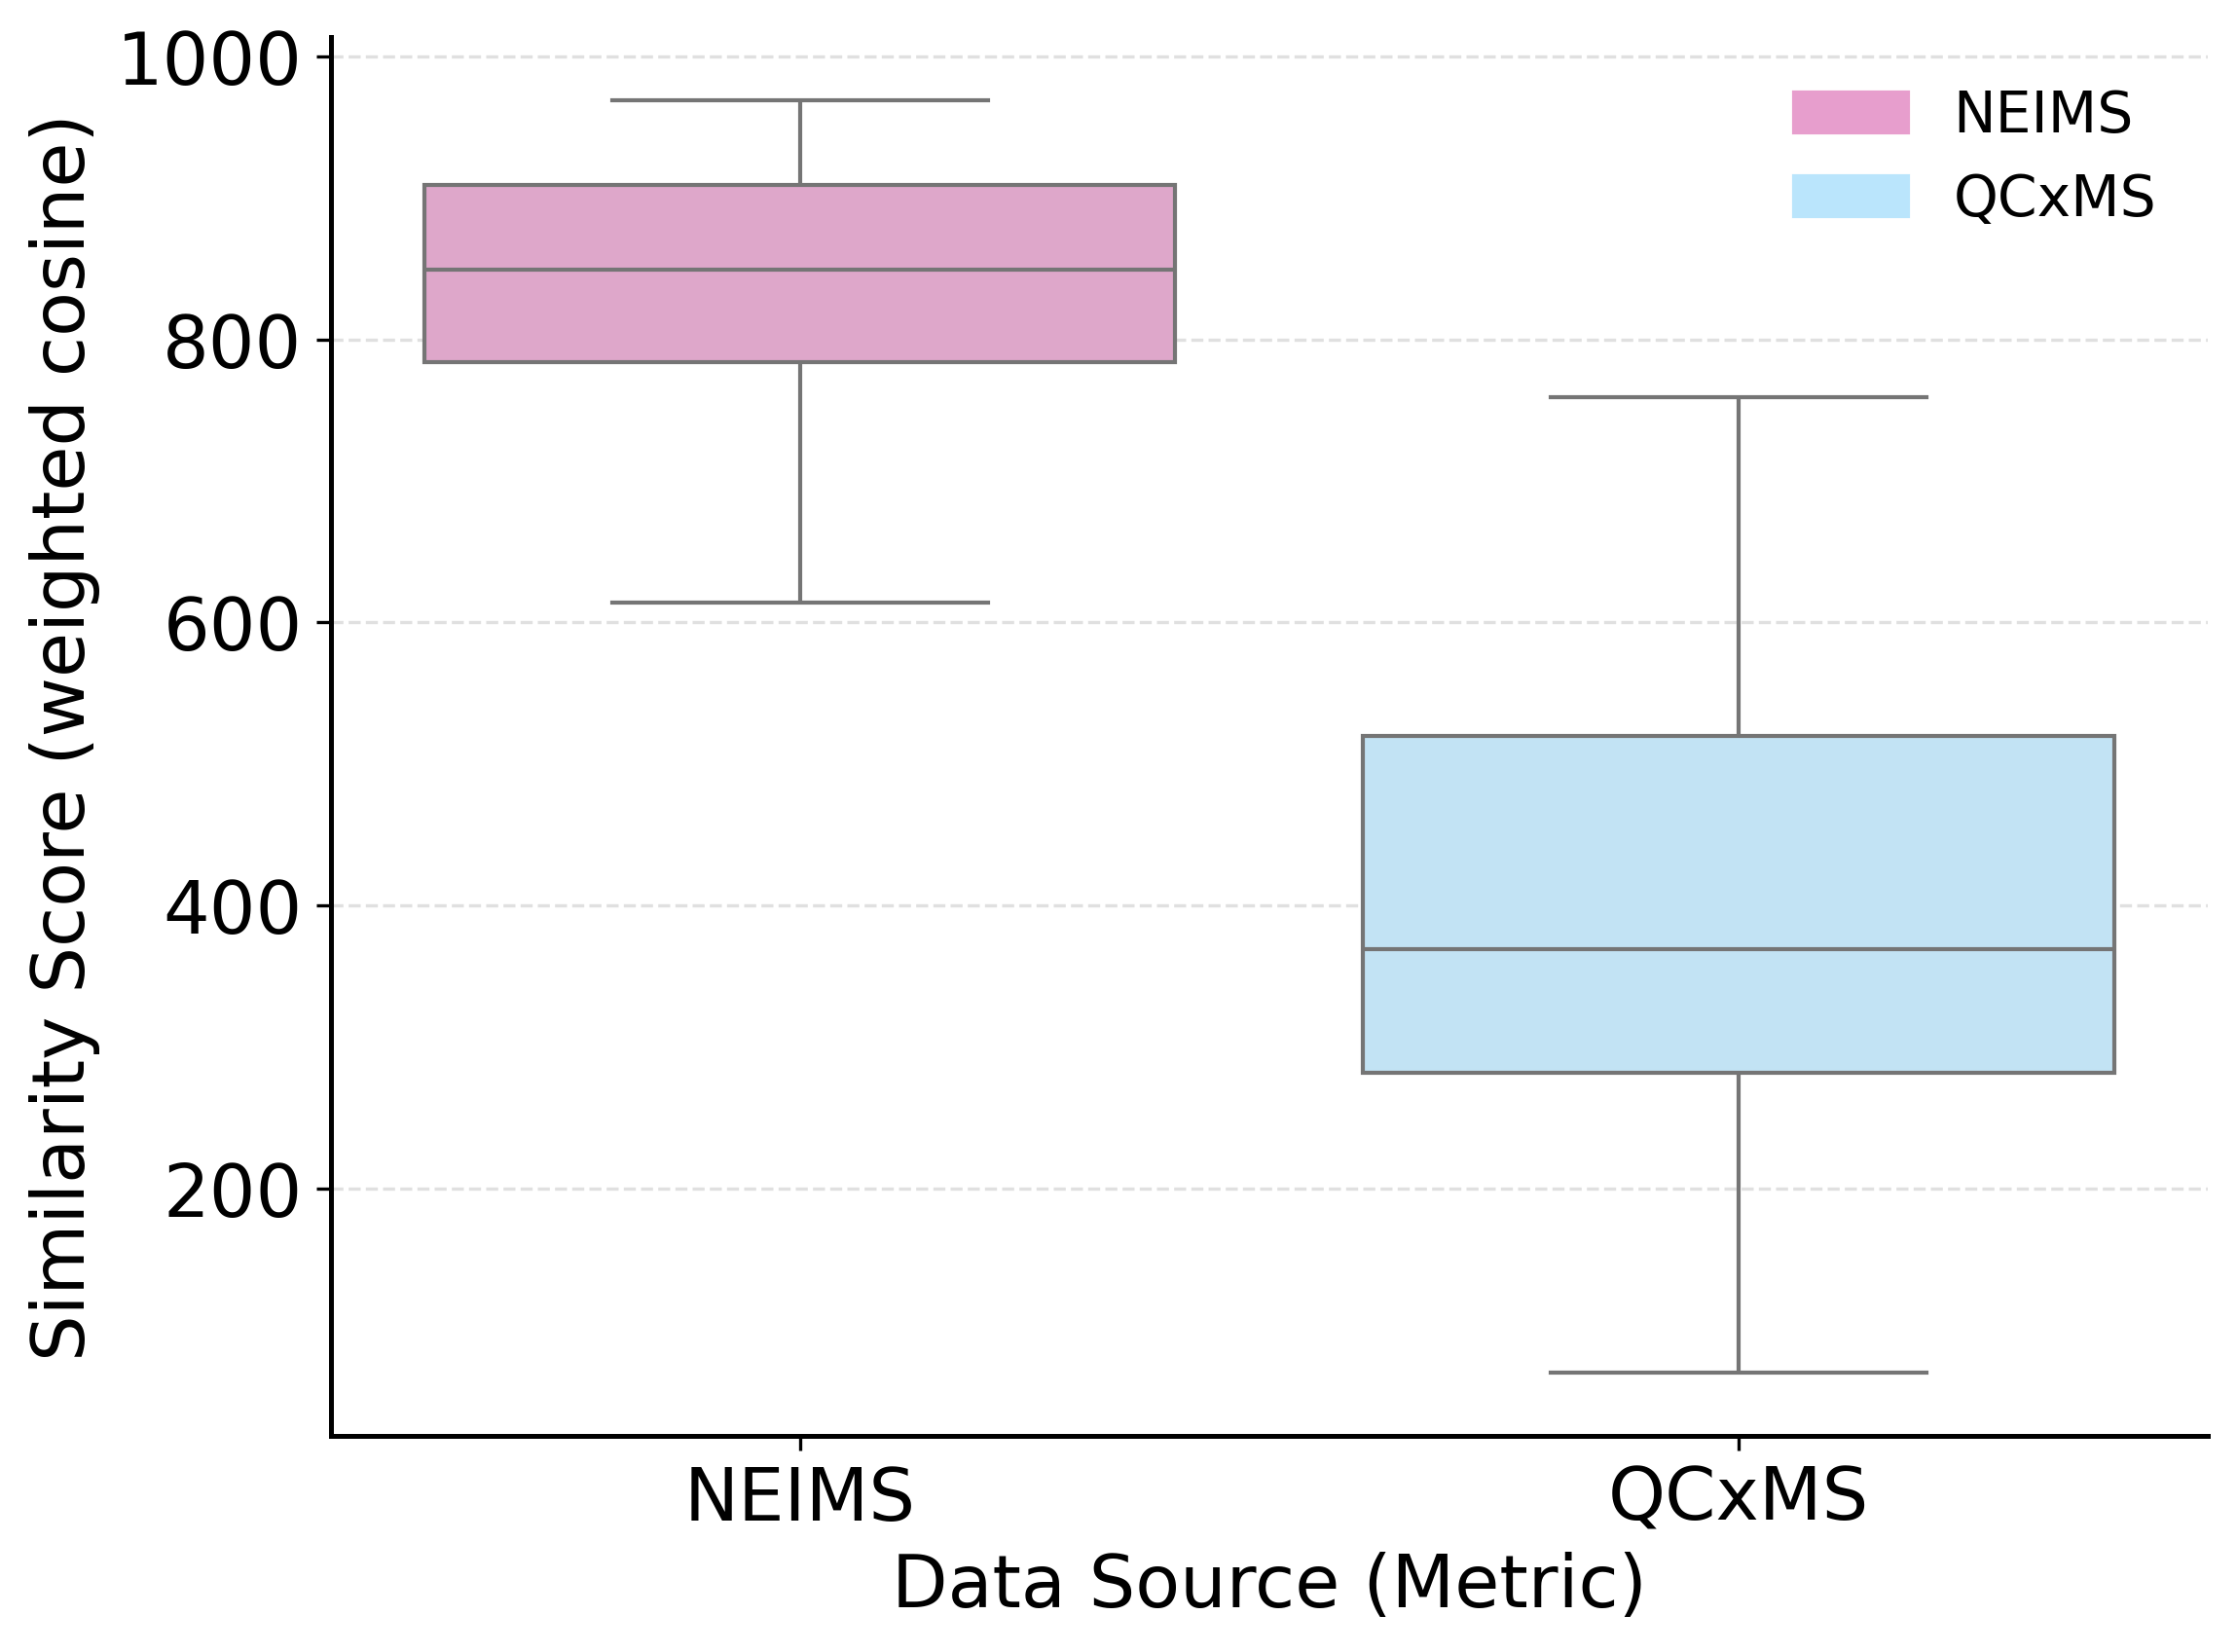

In [18]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

# Colors and display names
color_map = {
    'annotated.sdf': '#E79ECD',  # pink (NEIMS)
    'qcxms.csv': '#BAE5FC'       # blue (QCxMS)
}

display_name_map = {
    'annotated.sdf': 'NEIMS',
    'qcxms.csv': 'QCxMS'
}

plt.rcParams.update({'font.size': 18})

methods = long_df['method'].unique()  # get all methods

for method in methods:
    df_method = long_df[long_df['method'] == method]  # filter data for this method
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.boxplot(
        data=df_method,
        x='metric',
        y='value',
        palette=color_map,
        order=list(display_name_map.keys()),
        showfliers=False,
        ax=ax
    )
    
    # Replace 'weighted_cosine' with 'weighted cosine' in y-label
    display_method = method.replace('weighted_cosine', 'weighted cosine')
    ax.set_ylabel(f"Similarity Score ({display_method})")
    ax.set_xlabel("Data Source (Metric)")
    
    # Rename x-axis tick labels with display names
    labels = [display_name_map.get(tick.get_text(), tick.get_text()) for tick in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    
    # Add legend
    patches = [mpatches.Patch(color=color_map[m], label=display_name_map[m]) for m in display_name_map]
    ax.legend(handles=patches, title='', fontsize=14, title_fontsize=16, frameon=False)
    
    plt.tight_layout()
    plt.savefig(f"boxplot_{method}.png", dpi=300)
    plt.show()


## 2.2 Plot histogram of performance

In [19]:
print(long_df.head())
print(long_df['method'].unique())
print(long_df['metric'].unique())

   sample           method         metric       value
0       0           cosine  annotated.sdf  892.927355
1       0           cosine      qcxms.csv  766.971001
4       0         tanimoto  annotated.sdf  669.262571
5       0         tanimoto      qcxms.csv  579.429179
8       0  weighted_cosine  annotated.sdf  849.572797
['cosine' 'tanimoto' 'weighted_cosine']
['annotated.sdf' 'qcxms.csv']


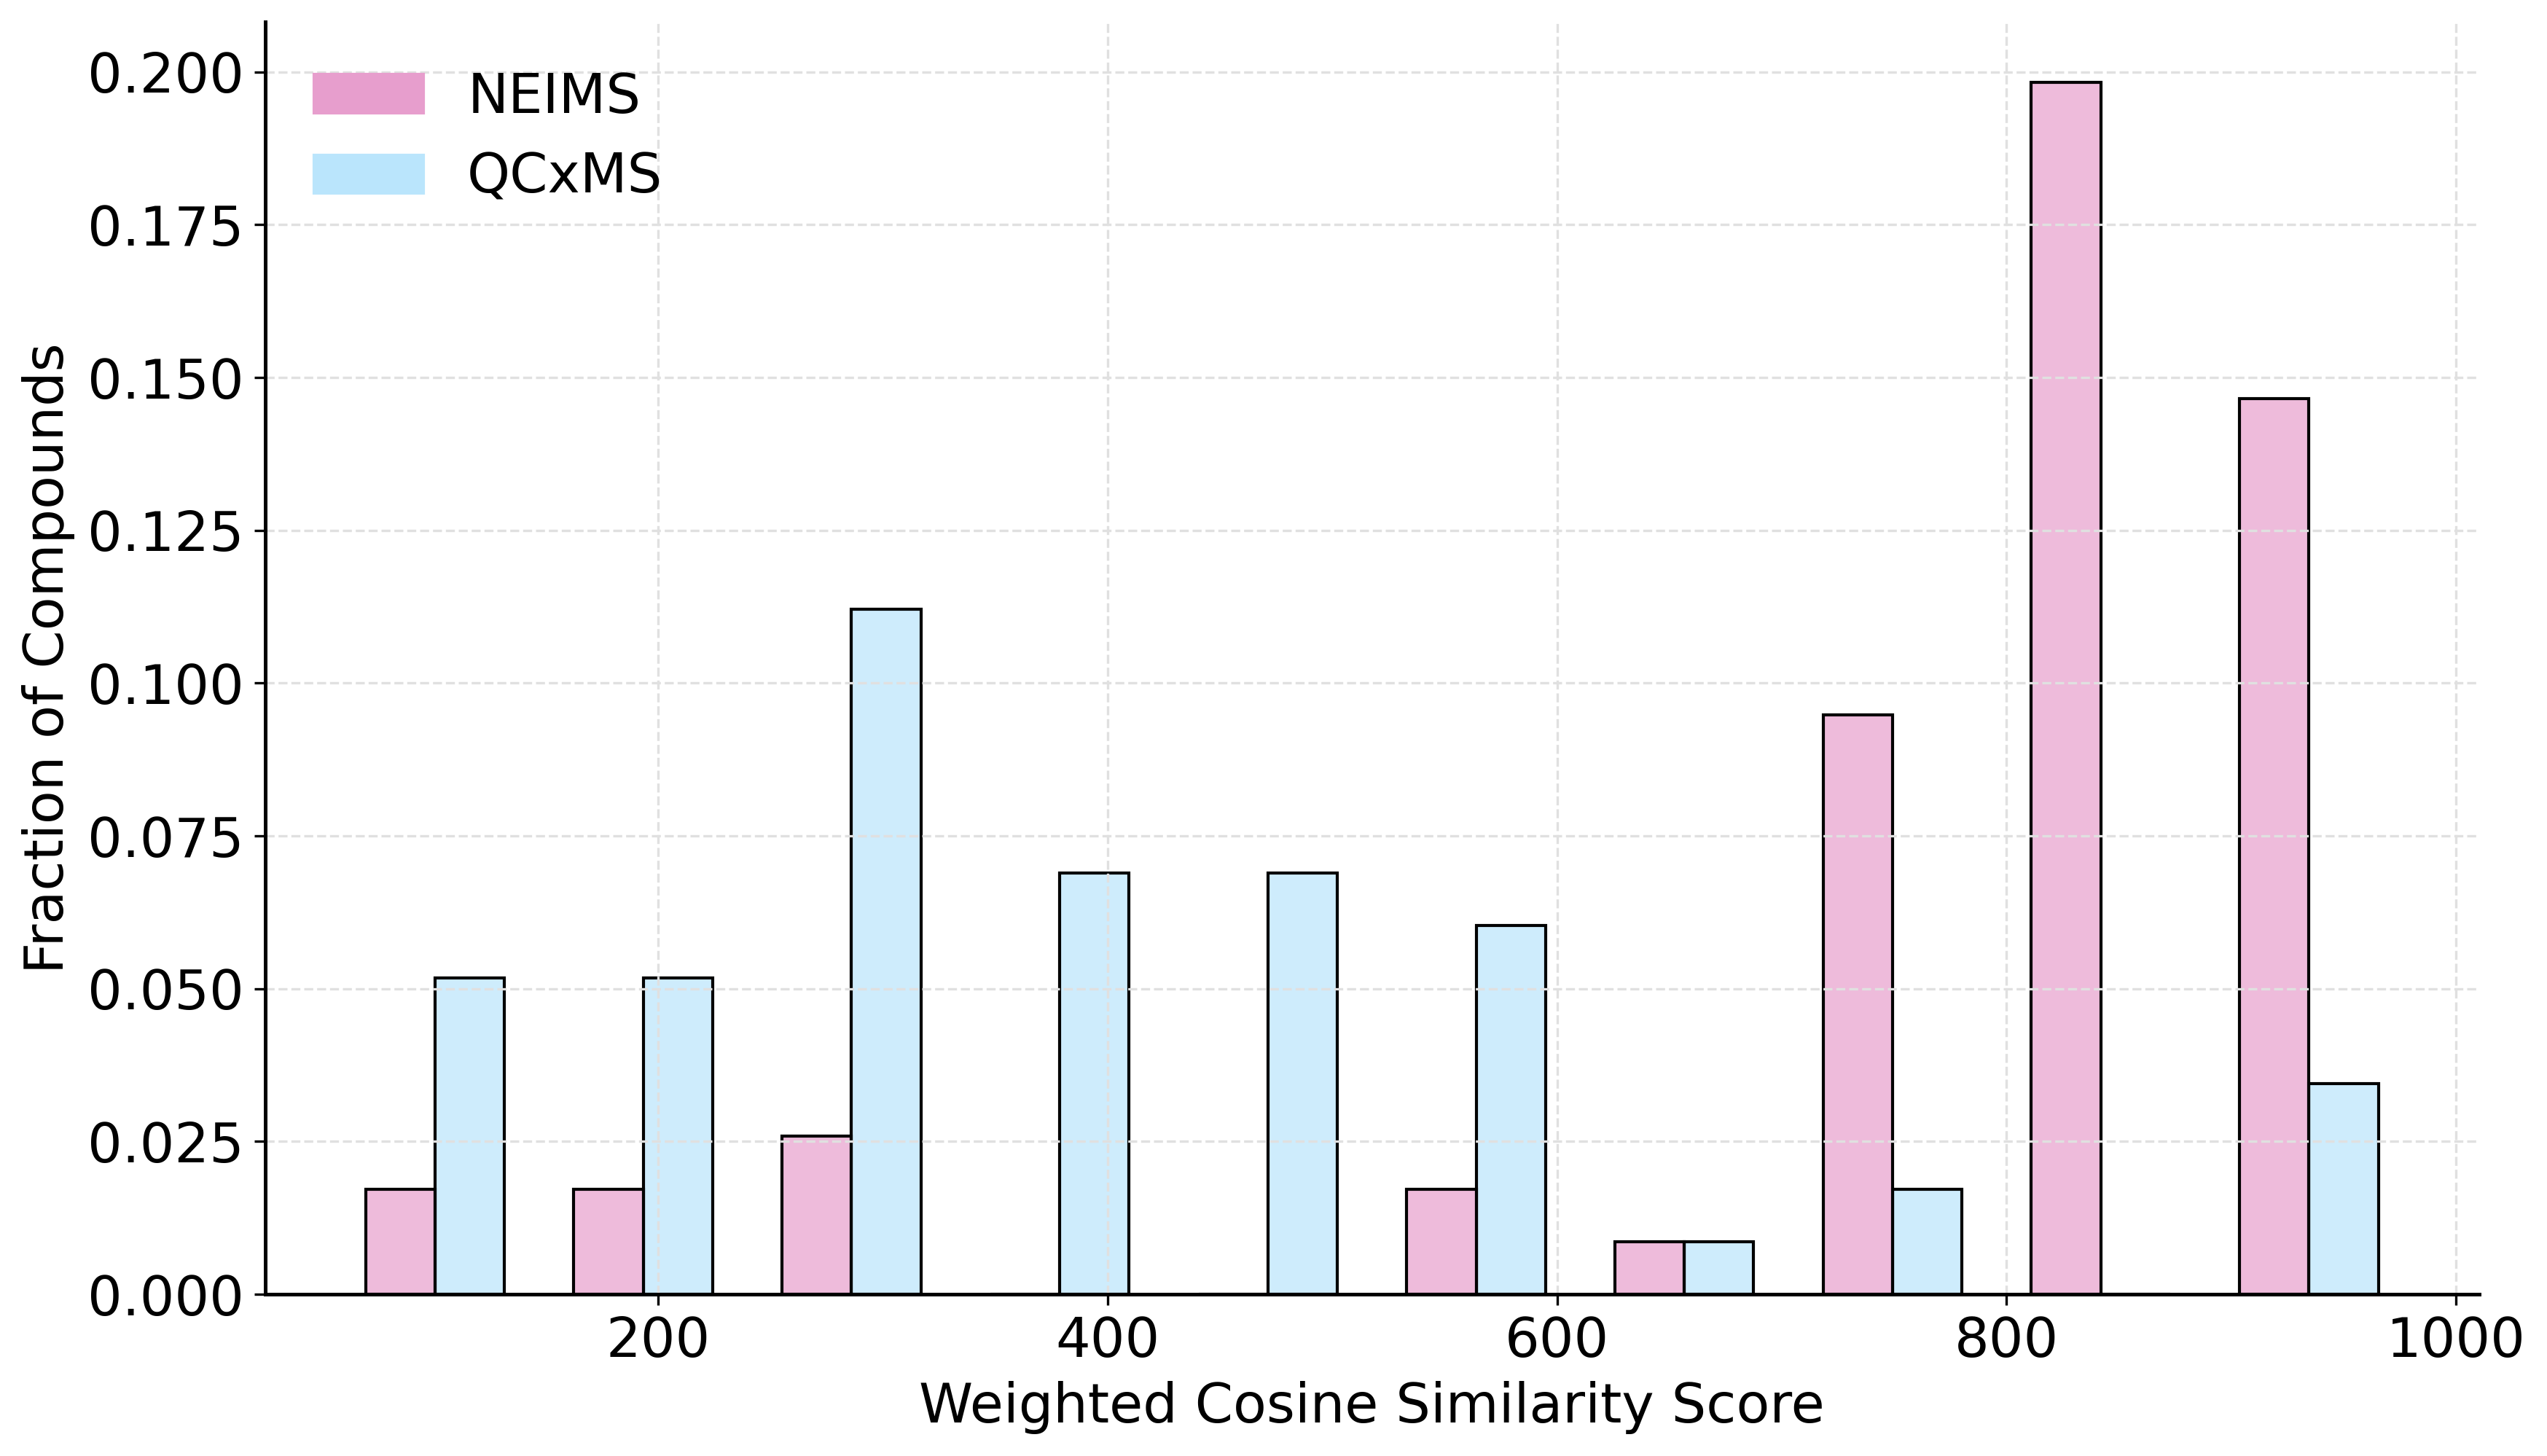

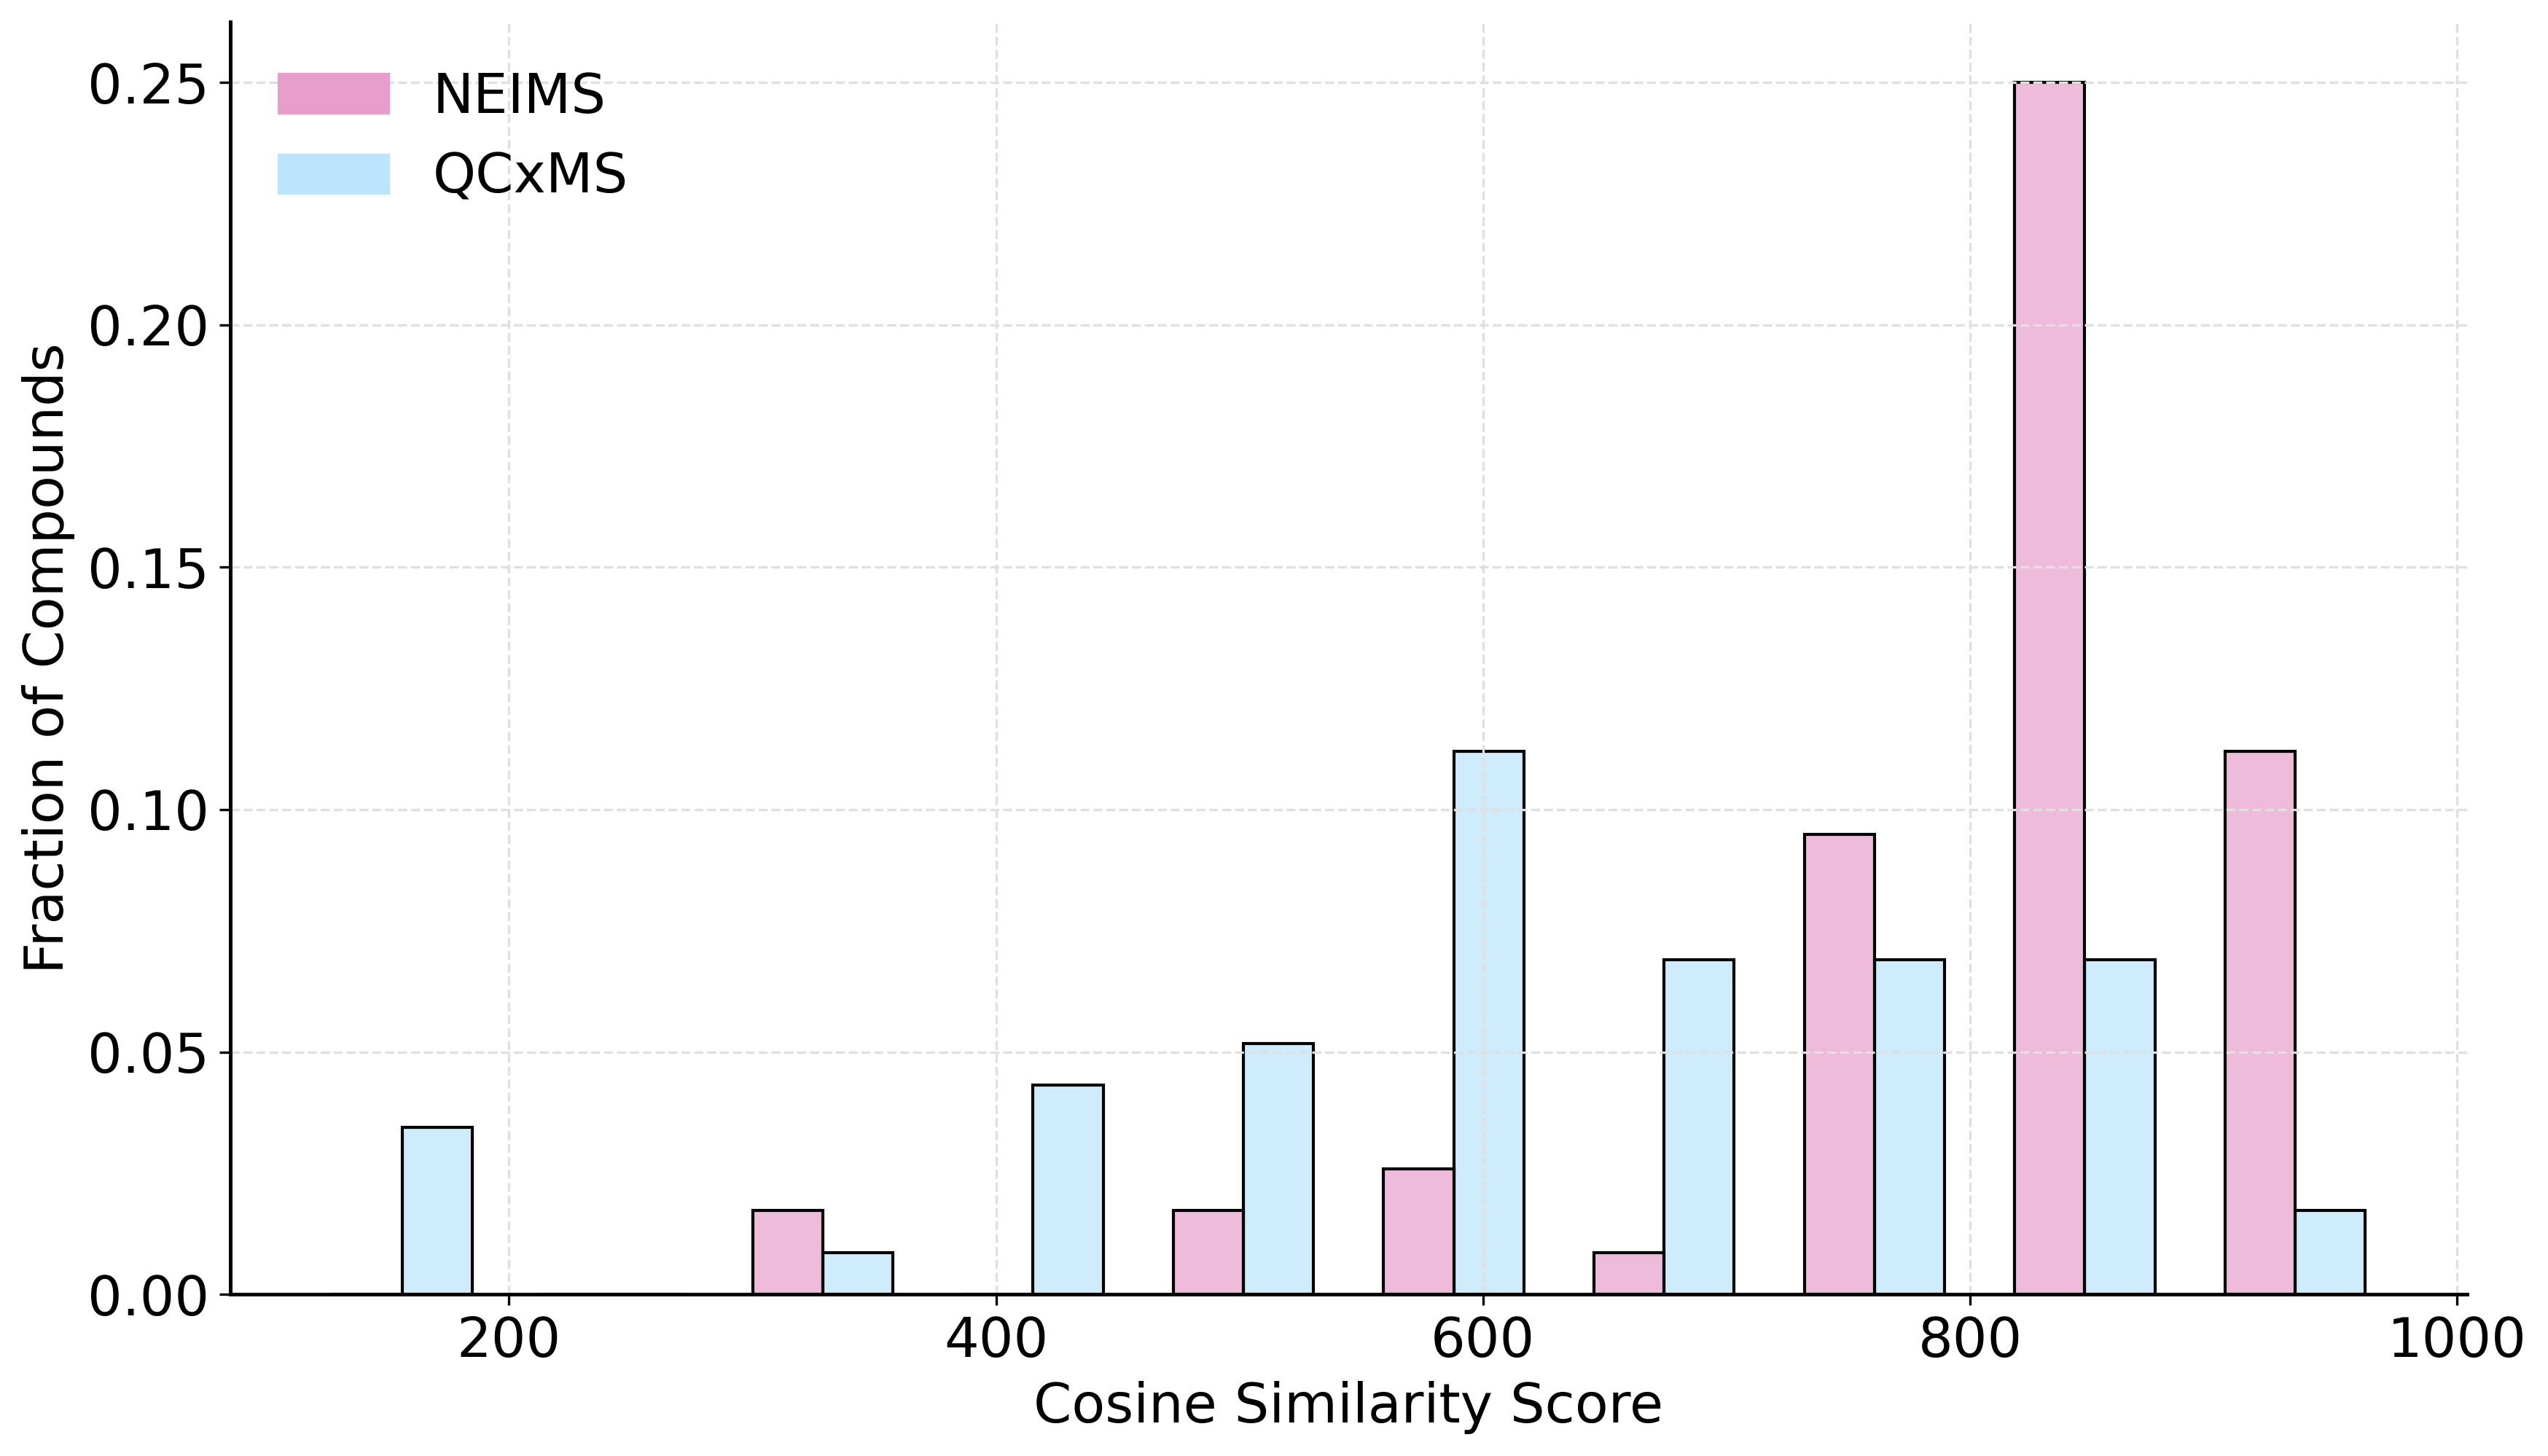

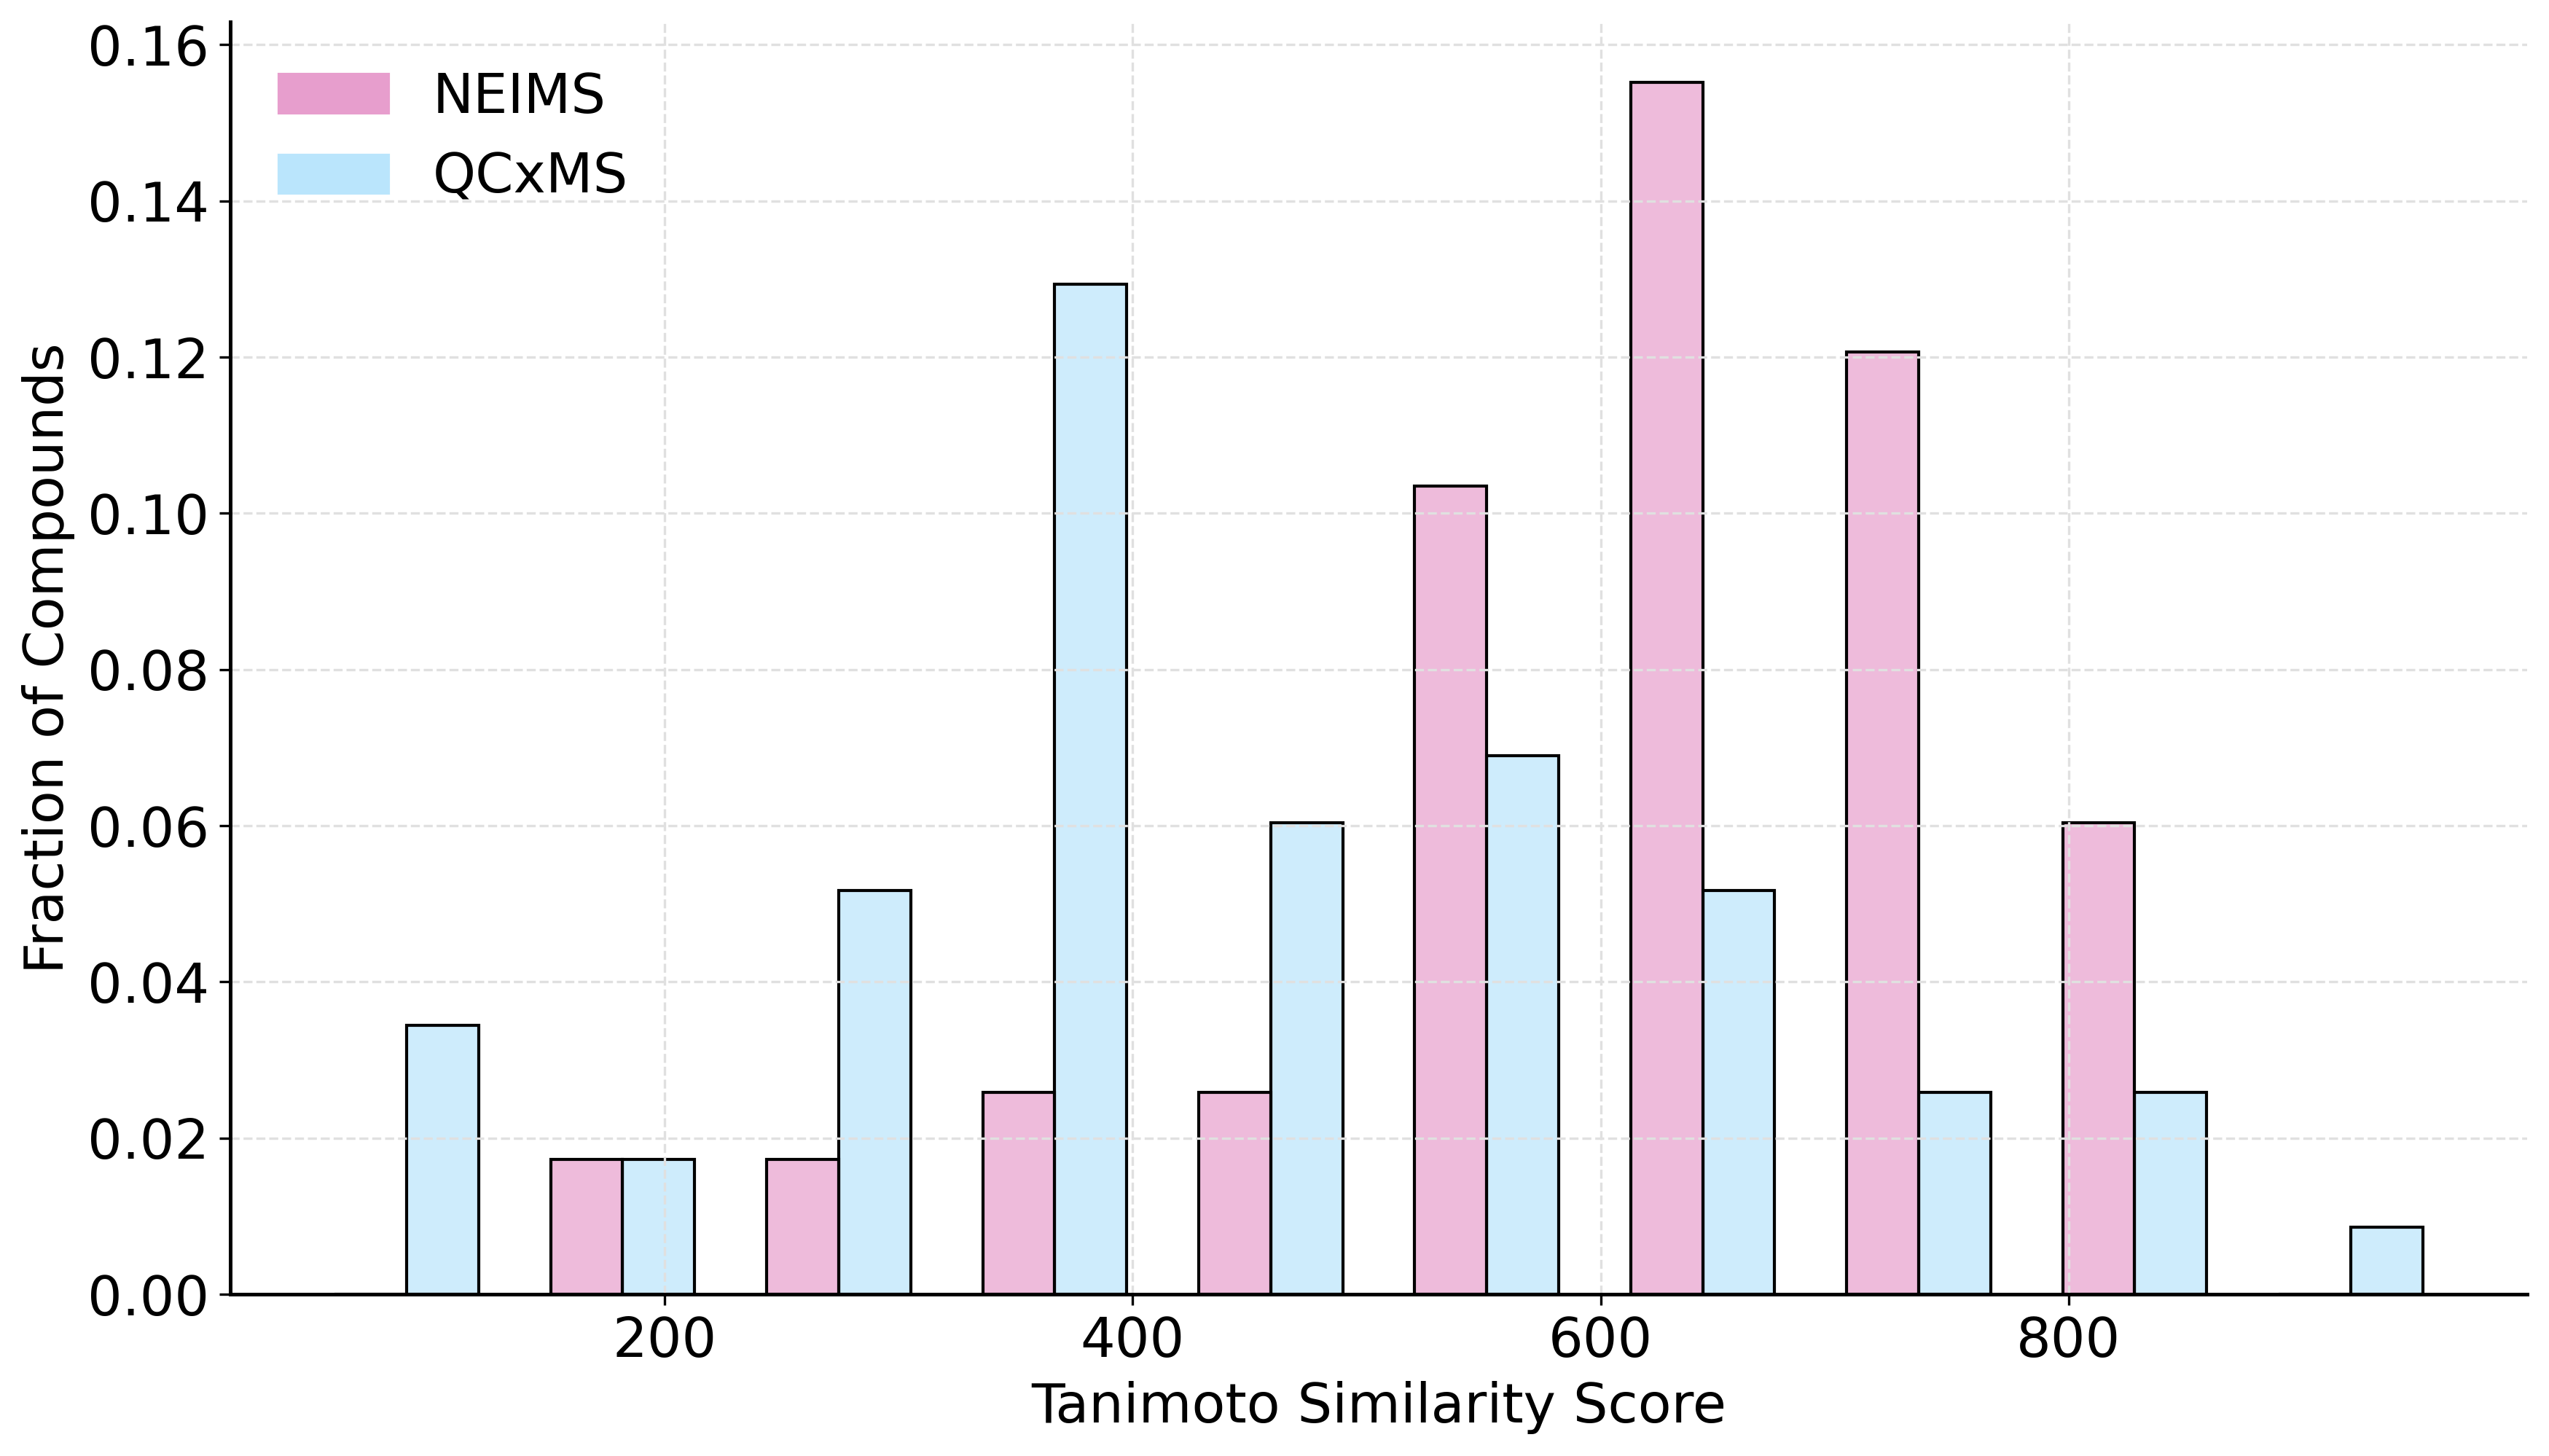

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# --- Color and display name mappings ---
color_map = {
    'annotated.sdf': '#E79ECD',        # pink (NEIMS)
    'qcxms.csv': '#BAE5FC',            # blue (QCxMS)
    'qcxms2-xtb.csv': '#CAE1A7',       # green (QCxMS/xTB)
}

display_name_map = {
    'annotated.sdf': 'NEIMS',
    'qcxms.csv': 'QCxMS',
    'qcxms2-xtb.csv': 'QCxMS2',
}

# --- Set global font size ---
plt.rcParams.update({'font.size': 18})

# --- Filter for cosine and exclude DFT ---
filtered_df = long_df[
    (long_df['method'].str.strip().str.lower() == 'weighted_cosine') &
    (long_df['metric'].isin(color_map.keys()))
]

# --- Plot ---
plt.figure(figsize=(12, 7))  # width = 836px at 100 dpi

sns.histplot(
    data=filtered_df,
    x='value',
    hue='metric',
    bins=10,
    multiple='dodge',
    palette=color_map,
    edgecolor='black',
    alpha=0.7,
    hue_order=list(color_map.keys()),
    stat='probability'  # Shows percentage instead of raw counts
)

plt.xlabel("Weighted Cosine Similarity Score")
plt.ylabel("Fraction of Compounds")

# Custom legend
patches = [
    mpatches.Patch(color=color_map[m], label=display_name_map[m])
    for m in filtered_df['metric'].unique()
]

plt.legend(
    handles=patches,
    loc='upper left',
    fontsize=18,
    frameon=False
)

plt.tight_layout()
plt.savefig("weighted_cosine_similarity_histogram.png", dpi=340, bbox_inches='tight', transparent=True)
plt.show()

# --- Filter for cosine and exclude DFT ---
filtered_df = long_df[
    (long_df['method'].str.strip().str.lower() == 'cosine') &
    (long_df['metric'].isin(color_map.keys()))
]

# --- Plot ---
plt.figure(figsize=(12, 7))  # width = 836px at 100 dpi

sns.histplot(
    data=filtered_df,
    x='value',
    hue='metric',
    bins=10,
    multiple='dodge',
    palette=color_map,
    edgecolor='black',
    alpha=0.7,
    hue_order=list(color_map.keys()),
    stat='probability'  # Shows percentage instead of raw counts
)

plt.xlabel("Cosine Similarity Score")
plt.ylabel("Fraction of Compounds")

# Custom legend
patches = [
    mpatches.Patch(color=color_map[m], label=display_name_map[m])
    for m in filtered_df['metric'].unique()
]

plt.legend(
    handles=patches,
    loc='upper left',
    fontsize=18,
    frameon=False
)

plt.tight_layout()
plt.savefig("cosine_similarity_histogram.png", dpi=340, bbox_inches='tight', transparent=True)
plt.show()

# --- Filter for cosine and exclude DFT ---
filtered_df = long_df[
    (long_df['method'].str.strip().str.lower() == 'tanimoto') &
    (long_df['metric'].isin(color_map.keys()))
]

# --- Plot ---
plt.figure(figsize=(12, 7))  # width = 836px at 100 dpi

sns.histplot(
    data=filtered_df,
    x='value',
    hue='metric',
    bins=10,
    multiple='dodge',
    palette=color_map,
    edgecolor='black',
    alpha=0.7,
    hue_order=list(color_map.keys()),
    stat='probability'  # Shows percentage instead of raw counts
)

plt.xlabel("Tanimoto Similarity Score")
plt.ylabel("Fraction of Compounds")

# Custom legend
patches = [
    mpatches.Patch(color=color_map[m], label=display_name_map[m])
    for m in filtered_df['metric'].unique()
]

plt.legend(
    handles=patches,
    loc='upper left',
    fontsize=18,
    frameon=False
)

plt.tight_layout()
plt.savefig("tanimoto_similarity_histogram.png", dpi=340, bbox_inches='tight', transparent=True)
plt.show()

In [21]:
print(long_df['metric'].unique())
print(long_df['method'].unique())
print(long_df[long_df['metric'] == 'cosine']['method'].value_counts())

['annotated.sdf' 'qcxms.csv']
['cosine' 'tanimoto' 'weighted_cosine']
Series([], Name: count, dtype: int64)


# 3. Plot correlation between molecular properties and simulation performance

In [22]:
 metric_df.drop

<bound method DataFrame.drop of method      cosine    tanimoto  weighted_cosine
0       842.883177  668.938672       773.827769
1       472.371741  309.184532       316.582659
2       340.193012  196.102780       351.813784
3       747.039003  561.190898       781.209688
4              NaN         NaN              NaN
..             ...         ...              ...
63             NaN         NaN              NaN
64      785.566637  578.579916       752.435431
66      217.318568  119.385118        96.292351
67      455.560635  279.032188       208.039414
68      573.264956  388.654813       348.124744

[61 rows x 3 columns]>

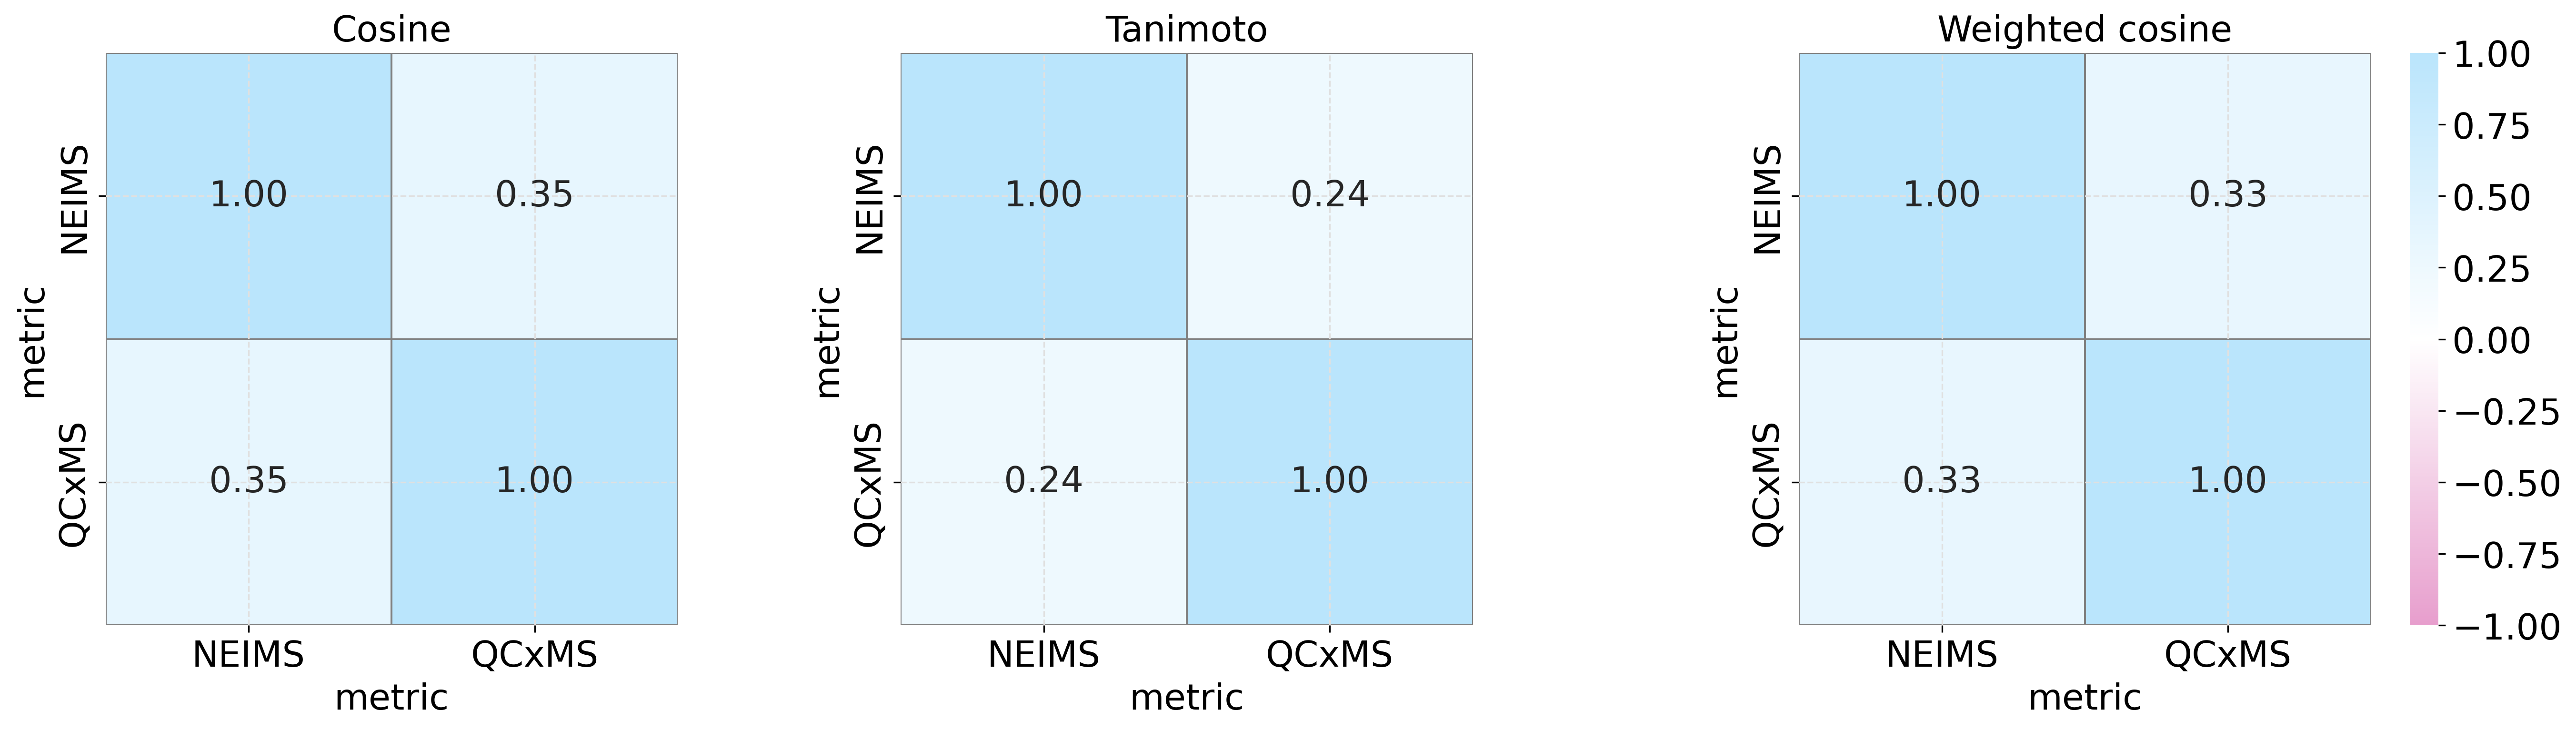

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Define a pink-to-blue diverging colormap
colors = ['#E79ECD', '#ffffff', '#BAE5FC']  # pink → white → blue
pink_blue_cmap = LinearSegmentedColormap.from_list('pink_blue', colors)

# Rename maps for legend
method_display_map = {
    'annotated.sdf': 'NEIMS',
    'qcxms.csv': 'QCxMS'
}

metric_order = ['cosine', 'tanimoto', 'weighted_cosine']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for ax, metric in zip(axes, metric_order):
    # Extract all methods for this metric (columns have MultiIndex (method, metric))
    metric_df = similarity_wide_df.xs(metric, axis=1, level=0)

    # Rename columns from filenames to display names
    metric_df = metric_df.rename(columns=method_display_map)
    
    # Drop the qcxms2 columns
    metric_df = metric_df.drop(columns=['qcxms2-dft.csv', 'qcxms2-xtb.csv'])

    # Compute correlation matrix
    corr = metric_df.corr()

    # Plot heatmap
    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap=pink_blue_cmap,  # pink-blue palette
        vmin=-1,
        vmax=1,
        ax=ax,
        cbar=(ax == axes[-1]),
        square=True,
        linewidths=0.5,
        linecolor='gray'
    )
    ax.set_title(f"{metric.replace('_',' ').capitalize()}", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)

plt.savefig("method_correlation_heatmaps_pink_blue.png", dpi=300, bbox_inches='tight')
plt.show()


## 3.1 Cluster molecules and color clusters by performance score for different methods

/tmp/hsandstr/29617177/ipykernel_883811/1393540782.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cosine_df.rename(columns=rename_map, inplace=True)
/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


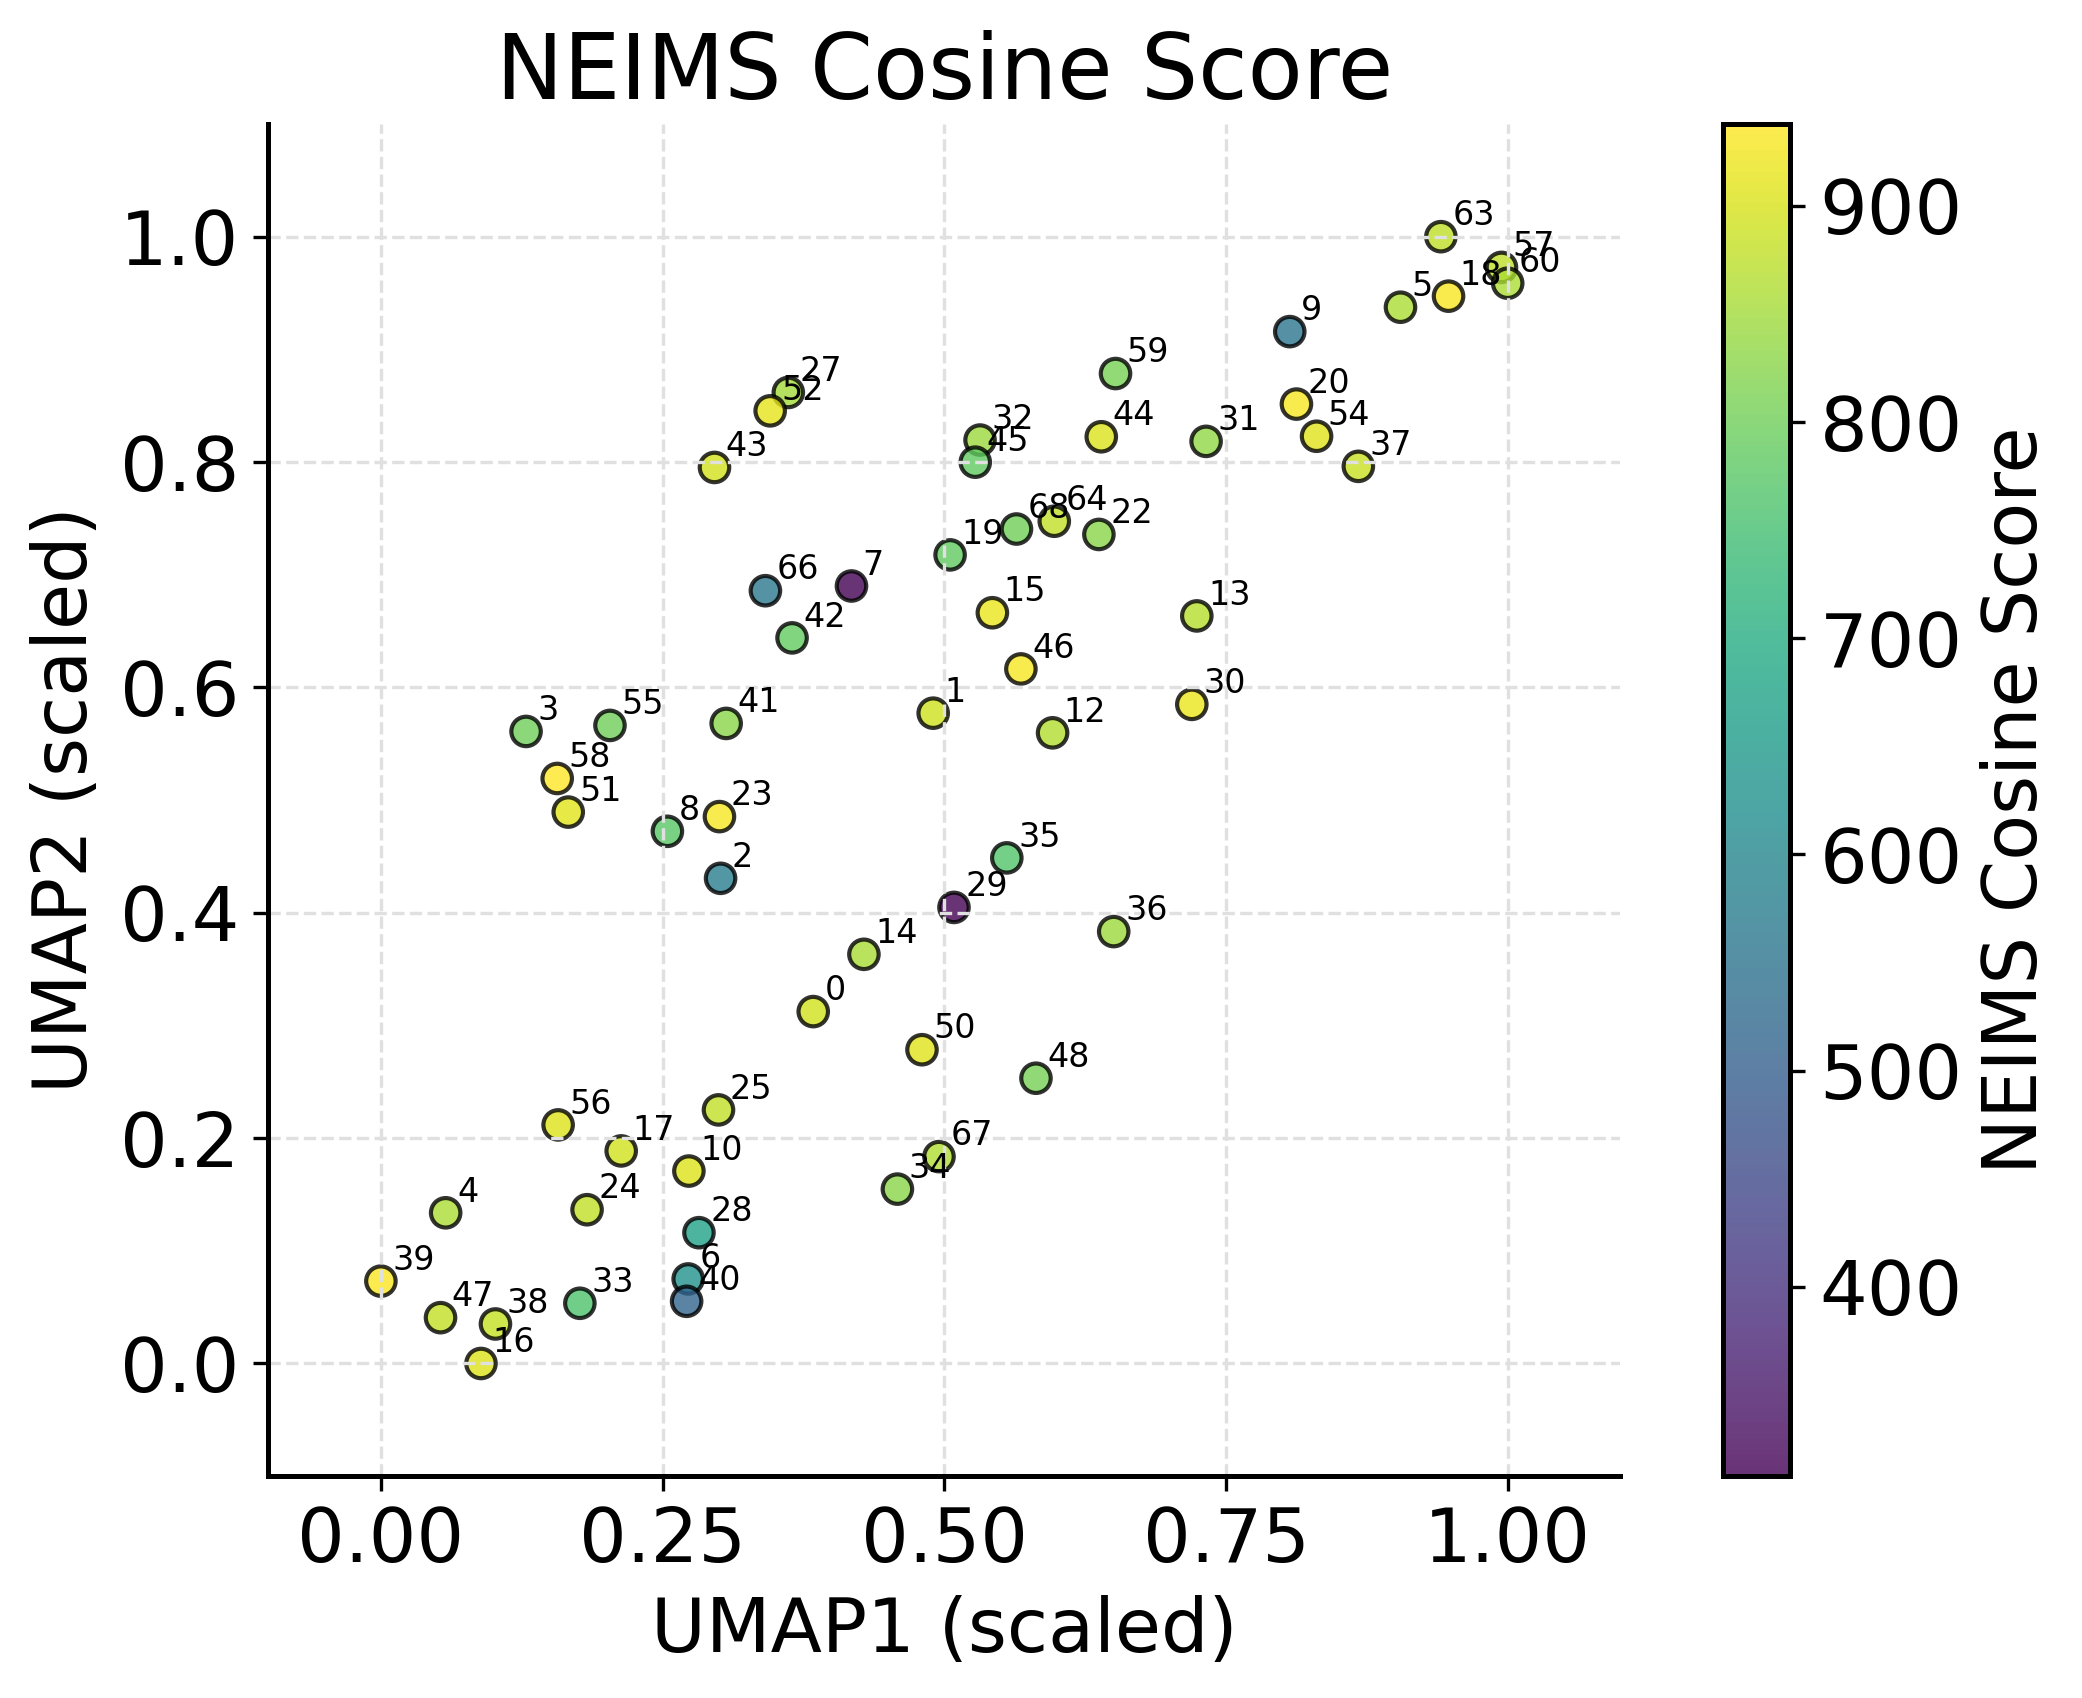

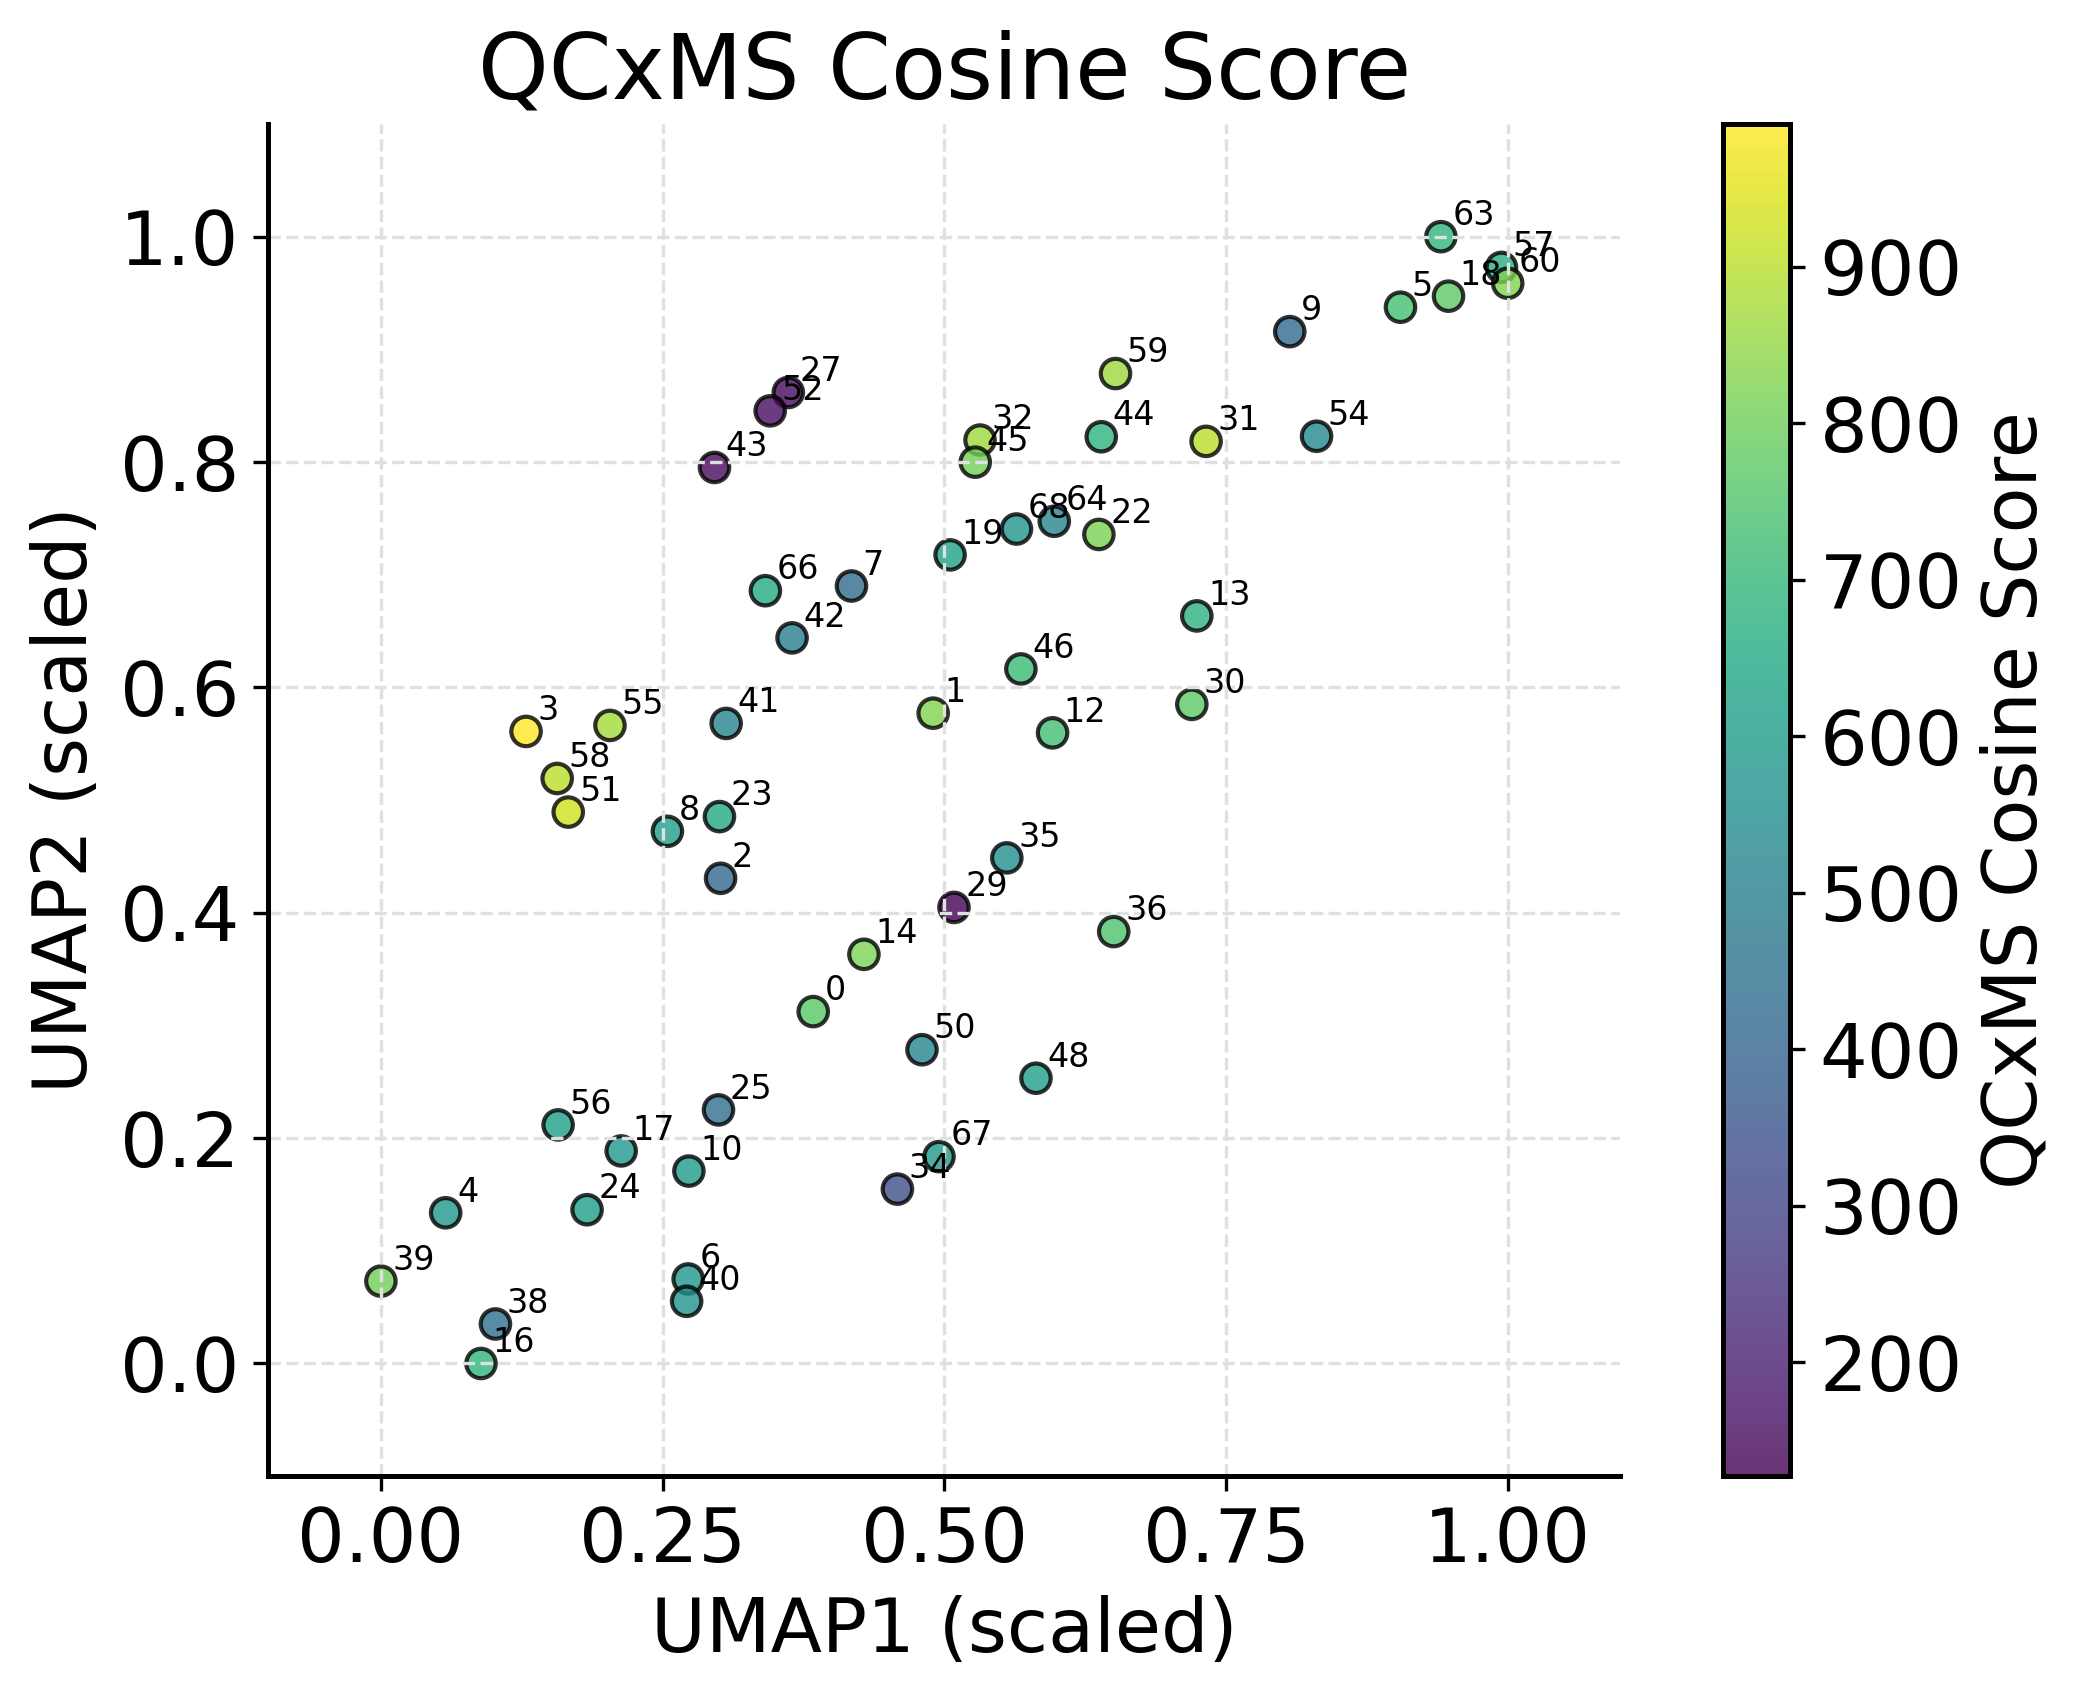

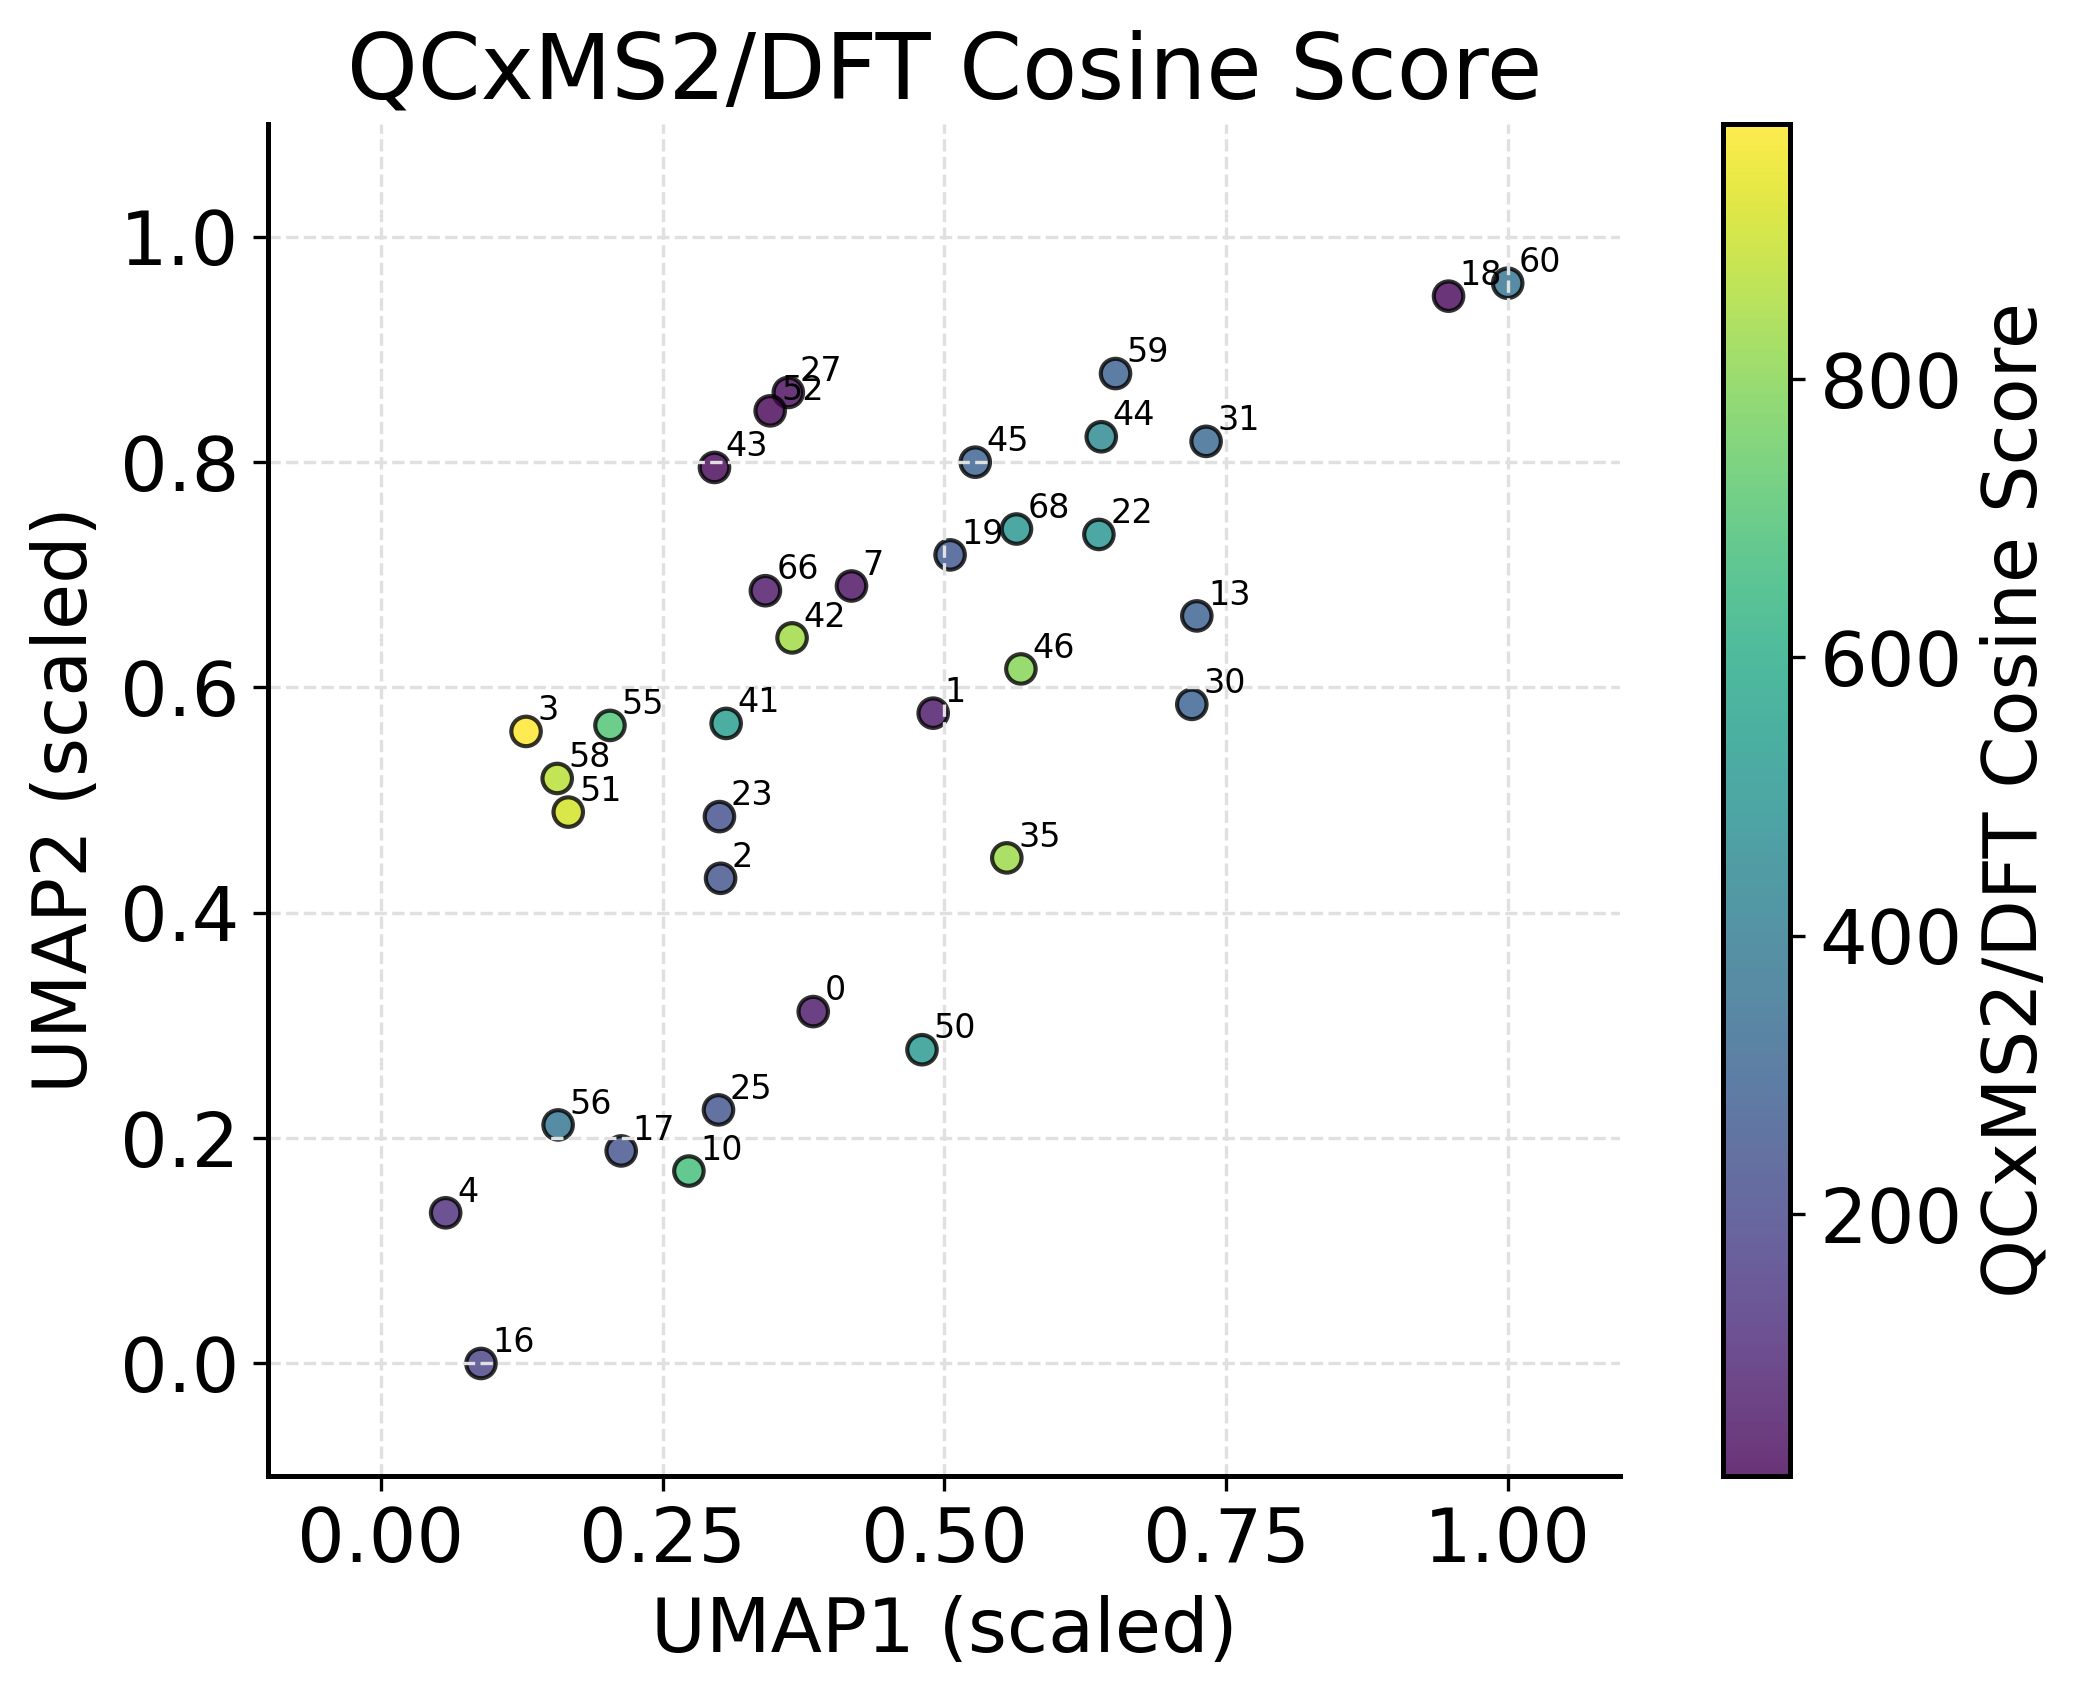

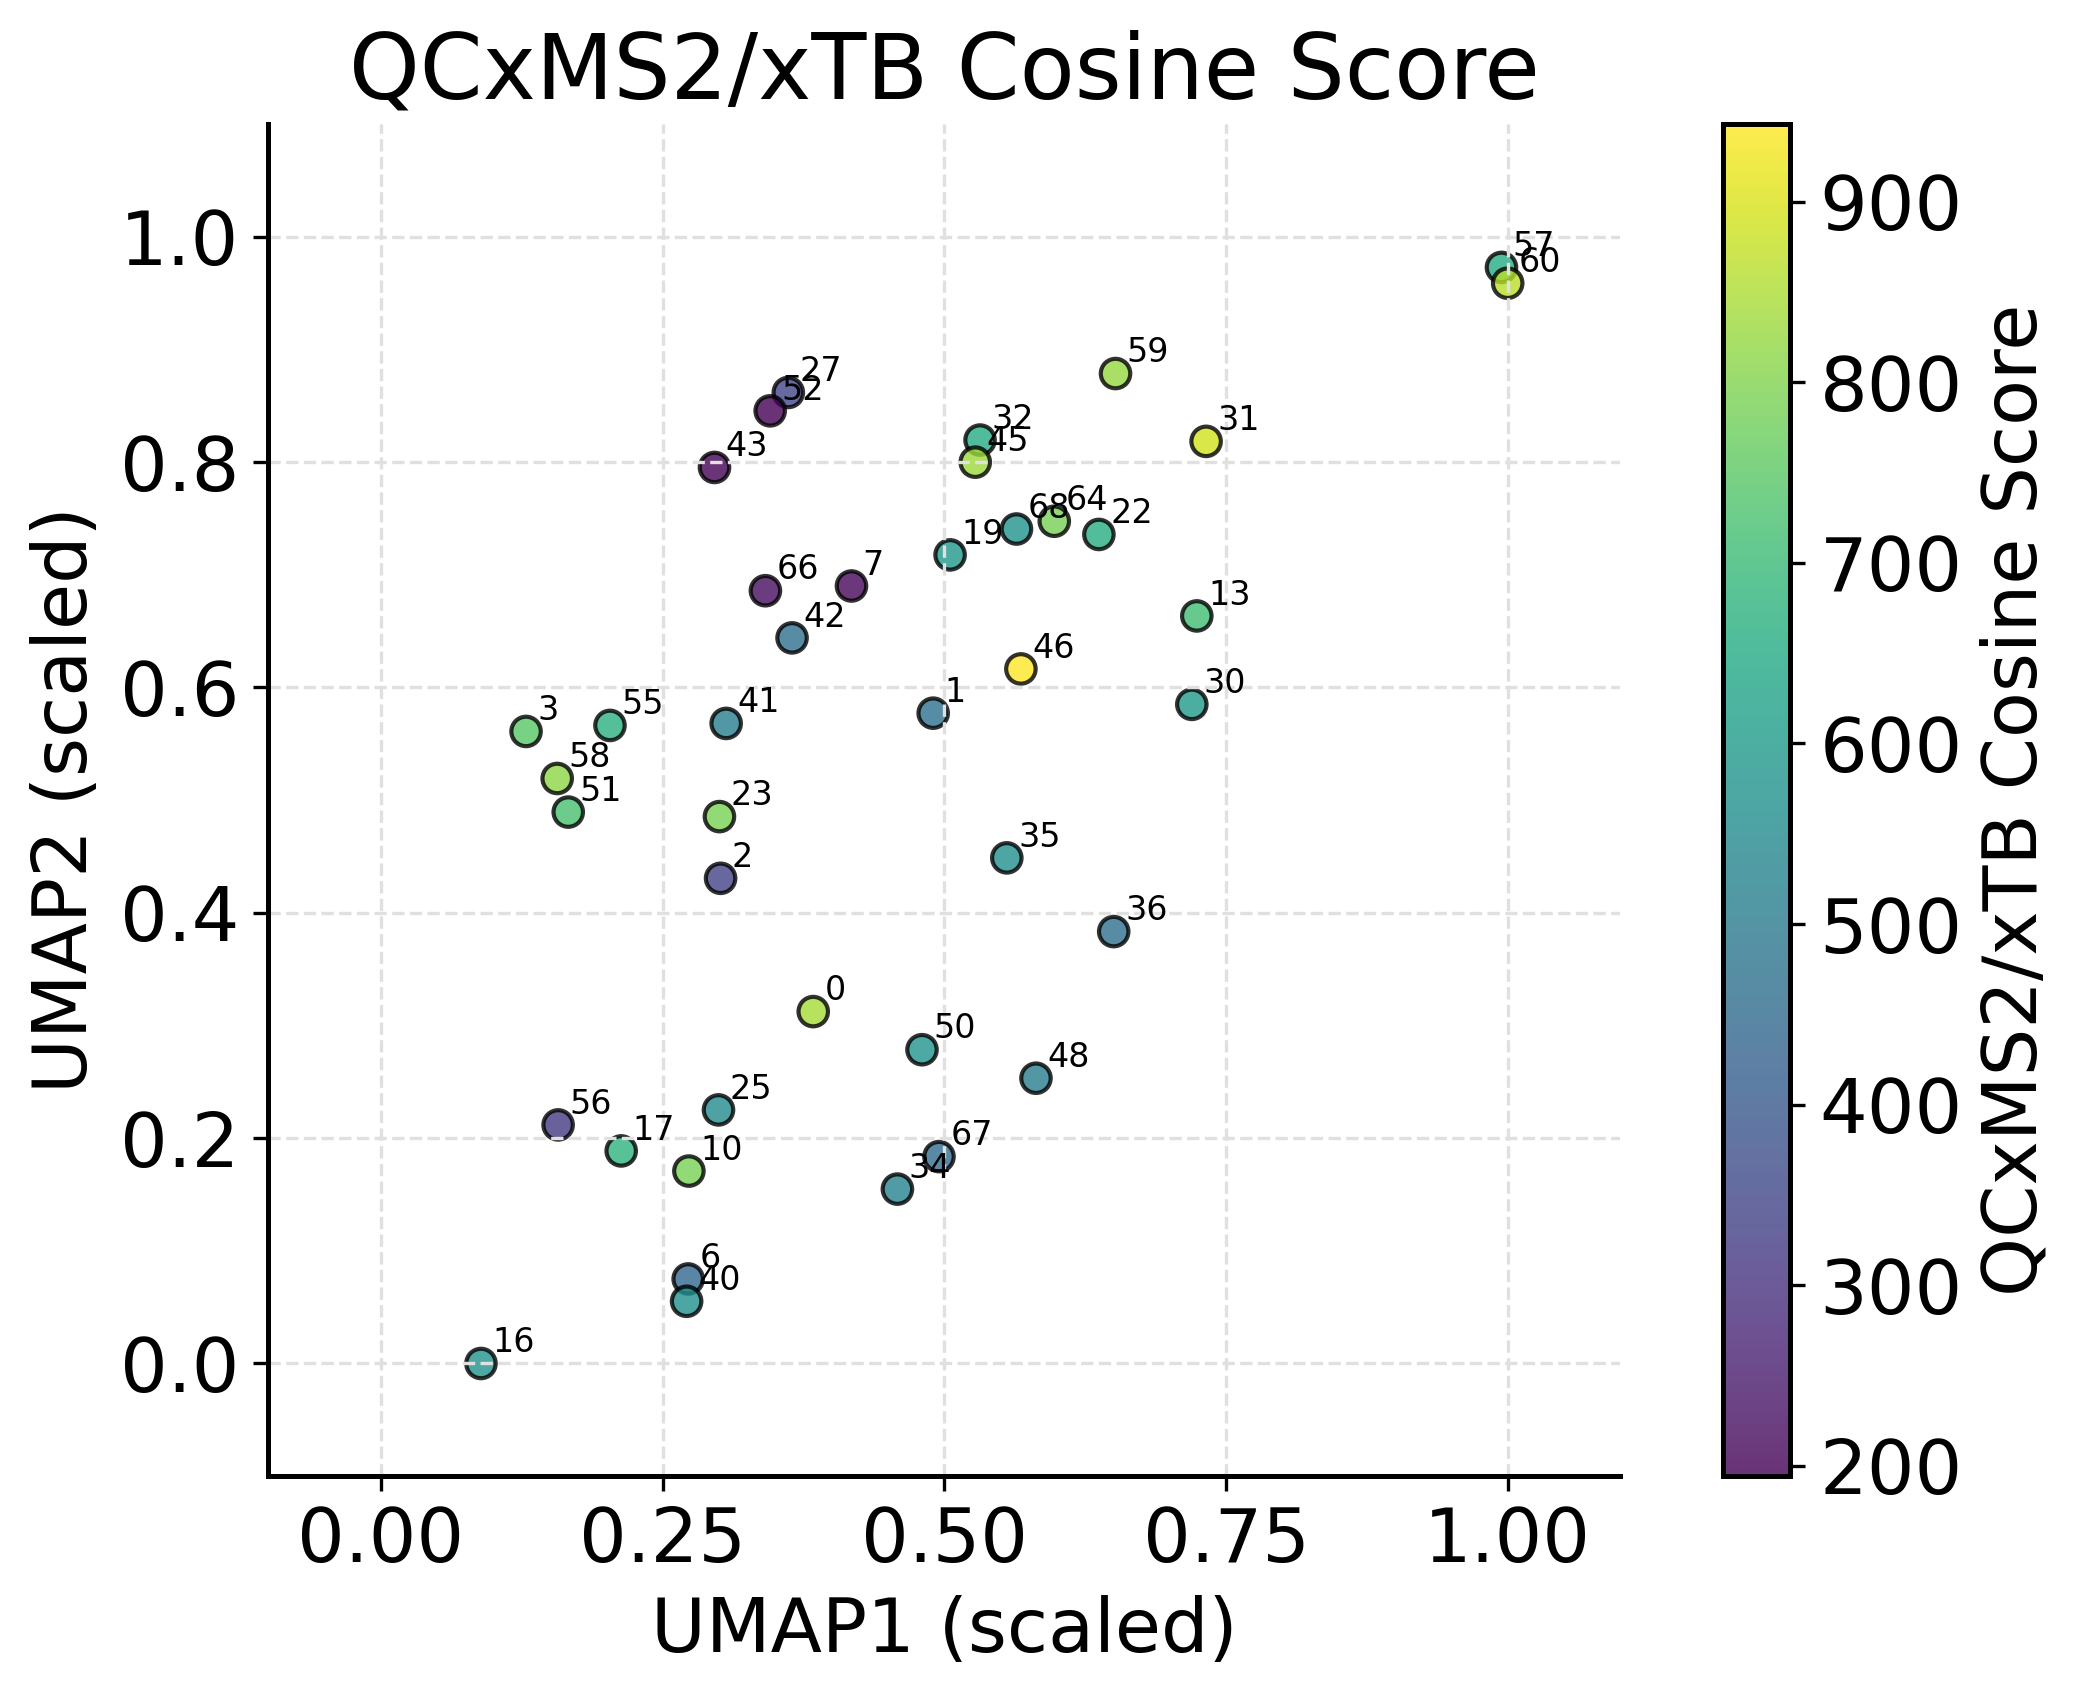

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import MinMaxScaler

# Define your function to get fingerprints
def smiles_to_fingerprint(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    arr = np.zeros((nBits,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Compute fingerprints for fun_groups
fun_groups['fingerprint'] = fun_groups['SMILES'].apply(smiles_to_fingerprint)
fun_groups = fun_groups.dropna(subset=['fingerprint'])

# Extract cosine similarity from similarity_wide_df (multiindex columns)
cosine_df = similarity_wide_df.loc[:, 'cosine']

# Rename columns for clarity
rename_map = {
    'annotated.sdf': 'NEIMS',
    'qcxms.csv': 'QCxMS',
    'qcxms2-dft.csv': 'QCxMS2/DFT',
    'qcxms2-xtb.csv': 'QCxMS2/xTB'
}
cosine_df.rename(columns=rename_map, inplace=True)

# Join on index (assuming both have integer indices aligned with fun_groups rows)
combined_df = fun_groups.join([cosine_df, mol_w.drop('SMILES',axis=1)], how='inner')
# Convert fingerprints to numpy array for UMAP
fps_array = np.vstack(combined_df['fingerprint'].values)

# Run UMAP embedding
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(fps_array)

# Scale embedding coords to [0,1]
scaler = MinMaxScaler()
embedding_scaled = scaler.fit_transform(embedding)
combined_df['UMAP1'] = embedding_scaled[:, 0]
combined_df['UMAP2'] = embedding_scaled[:, 1]

# Plot UMAP colored by each cosine similarity method
methods = list(rename_map.values())  # ['NEIMS', 'QCxMS', 'QCxMS2/DFT', 'QCxMS2/xTB']

for method in methods:
    plt.figure(figsize=(8,6))
    
    # Mask points with non-NaN scores
    mask = combined_df[method].notna()
    
    plt.scatter(
        combined_df.loc[mask, 'UMAP1'], combined_df.loc[mask, 'UMAP2'],
        c=combined_df.loc[mask, method],
        cmap='viridis',
        s=50,
        edgecolor='k',
        alpha=0.8
    )
    plt.colorbar(label=f'{method} Cosine Score')

    # Add index labels only for valid points
    for i, (x, y) in combined_df.loc[mask, ['UMAP1', 'UMAP2']].iterrows():
        plt.text(x + 0.01, y + 0.01, str(i), fontsize=8)

    plt.xlabel('UMAP1 (scaled)')
    plt.ylabel('UMAP2 (scaled)')
    plt.title(f'{method} Cosine Score')

    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.tight_layout()
    filename = f'umap_340_dpo_{method.lower().replace("/", "_")}.png'
    plt.savefig(filename, dpi=300)
    plt.show()
    plt.close()





## 3.2 Make correlation matrix between functional group features and performances

In [25]:
# Select numeric columns excluding unwanted ones
exclude_cols = ['SMILES', 'fingerprint', 'UMAP1', 'UMAP2']
numeric_cols = [col for col in combined_df.columns if col not in exclude_cols and np.issubdtype(combined_df[col].dtype, np.number)]

# Filter out columns where all values are zero
nonzero_cols = [col for col in numeric_cols if combined_df[col].sum() != 0]

# Subset dataframe with only non-zero columns
df_filtered = combined_df[nonzero_cols]

# Compute correlation matrix
corr_matrix = df_filtered.corr()

# Focus on cosine similarity columns
cosine_methods = ['NEIMS', 'QCxMS']
correlations_with_cosine = corr_matrix.loc[:, cosine_methods]

print(correlations_with_cosine)


                                 NEIMS     QCxMS
amine, secondary              0.055563 -0.130047
alkane CH                    -0.015176 -0.108249
alkene CH                     0.224103  0.271863
aromatic CH                  -0.135347 -0.099866
carbonyl                     -0.051278  0.044690
ester, all                   -0.004772 -0.584335
ether                         0.127407 -0.036647
amide                         0.056524 -0.071968
ketone                       -0.083970  0.033920
aldehyde                      0.063766  0.029996
amide, secondary              0.056524 -0.071968
carbon number                -0.031232 -0.105816
ether, aromatic              -0.346981 -0.322026
ether (alicyclic)            -0.237687  0.034221
amine, aromatic              -0.024952  0.263719
C=C-C=O in non-aromatic ring -0.069388  0.084768
C=C (non-aromatic)            0.172178  0.277022
nC-OHside-a                   0.056524 -0.071968
oxygen_count                 -0.219763 -0.242813
aromatic_ring       

## 3.4 Plot correlation between performance and number of TMS groups

In [26]:
mol_w

SMILES  molar_mass  atom_count  \
0               CC(C)=CCC/C(C)=C/CC/C(C)=C/CCC(=C)C=C  272.250401          20   
1                  CC(=O)C=CC1(C)C(=O)C2(CCC1(C)C)CO2  236.141244          17   
2                       CC1(C)CCC[C@@]2(C)OC(=O)C=C12  180.115030          13   
3                        NC1=CC2=C(C=C1)NC3=C2C=CC=C3  182.084398          14   
4                       CC(C)CCCC(C)CCCC1(C)CCC(=O)O1  254.224580          18   
..                                                ...         ...         ...   
63               CCCCCC/C=C\CCCCCCCCC(=O)O[Si](C)(C)C  340.279757          23   
64                       C[Si](C)(C)OC(=O)C1CCC(=O)N1  201.082120          13   
66      C[Si](C)(C)OC(=O)C1=CC=CC=C1C(=O)O[Si](C)(C)C  310.105662          20   
67  COC1=CC(C(CO[Si](C)(C)C)O[Si](C)(C)C)=CC=C1O[S...  400.192139          25   
68               C[Si](C)(C)OC(=O)CCC(=O)O[Si](C)(C)C  262.105662          16   

    atom_count_with_H  
0                  52  
1                  37  
2                  29  
3                  24  
4                  48  
..                ...  
63                 63  
64                 28  
66                 42  
67                 61  
68                 38  

[61 rows x 4 columns]

In [27]:
from rdkit import Chem

def count_elements(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    counts = {
        'Si_count': 0,
        'N_count': 0,
        'C_count': 0
    }
    for atom in mol.GetAtoms():
        sym = atom.GetSymbol()
        if sym == 'Si':
            counts['Si_count'] += 1
        elif sym == 'N':
            counts['N_count'] += 1
        elif sym == 'C':
            counts['C_count'] += 1
    return counts

# Apply to your dataframe, assuming it has 'SMILES' column
element_counts = fun_groups['SMILES'].apply(count_elements).apply(pd.Series)

# Join counts to combined_df
combined_df = combined_df.join(element_counts)


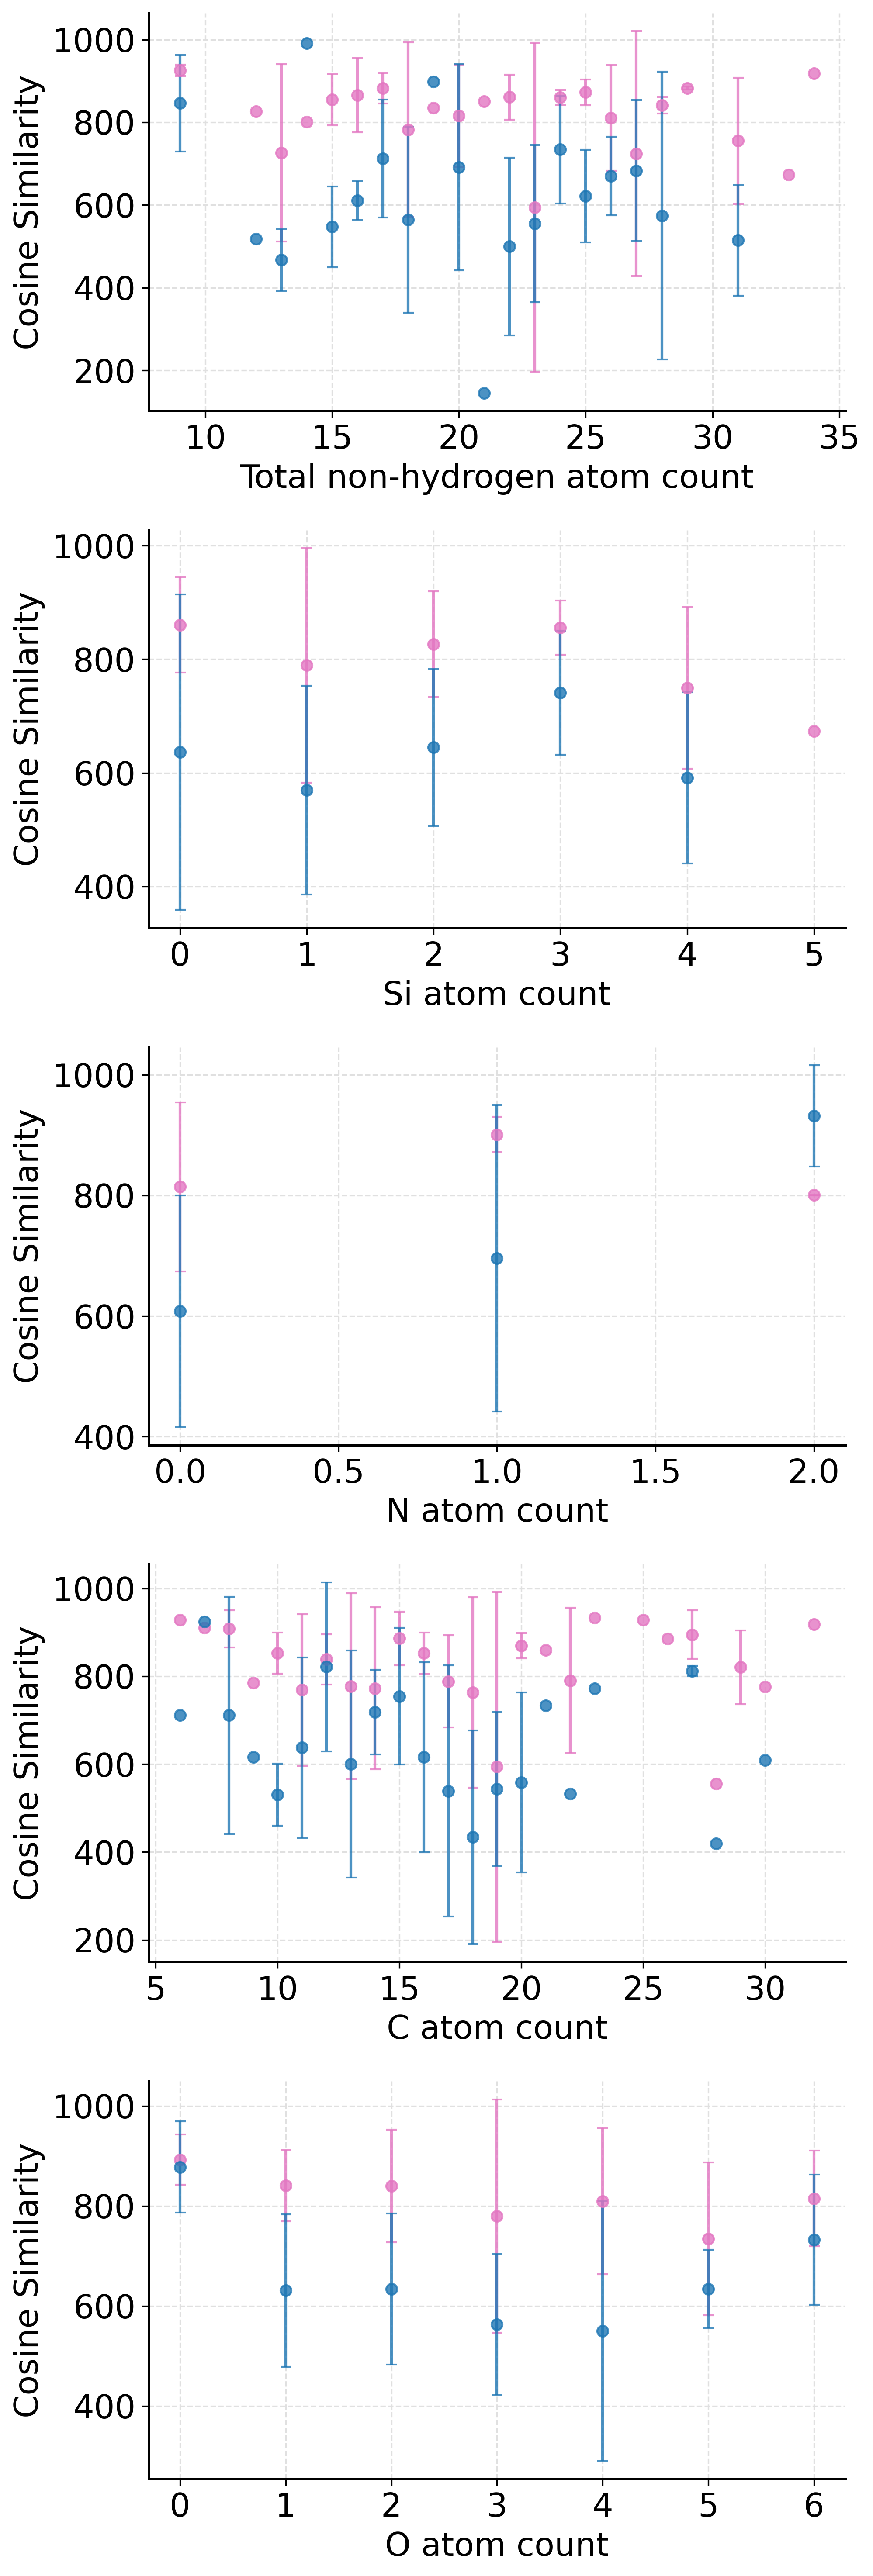

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Atom count features including oxygen_count
atom_features = ['atom_count', 'Si_count', 'N_count', 'C_count', 'oxygen_count']
cosine_methods = ['NEIMS', 'QCxMS', 'QCxMS2/DFT', 'QCxMS2/xTB']
cosine_methods = ['NEIMS', 'QCxMS']
# Define exact colors for each method (matching boxplot colors)
method_colors = {
    'NEIMS': '#e377c2',       # pink
    'QCxMS': '#1f77b4',       # blue
    'QCxMS2/DFT': '#7f7f7f',  # grey
    'QCxMS2/xTB': '#2ca02c',  # green
}

# Custom axis labels for readability
feature_label_map = {
    'atom_count': 'Total non-hydrogen atom count',
    'Si_count': 'Si atom count',
    'N_count': 'N atom count',
    'C_count': 'C atom count',
    'oxygen_count': 'O atom count',
}

fig, axes = plt.subplots(len(atom_features), 1, figsize=(7, 4 * len(atom_features)), sharex=False)

for i, (feature, ax) in enumerate(zip(atom_features, axes)):
    grouped = combined_df.groupby(feature)
    
    for method in cosine_methods:
        means = grouped[method].mean()
        stds = grouped[method].std()
        
        ax.errorbar(
            means.index, means.values, yerr=stds.values,
            label=method, capsize=3, marker='o', linestyle='None', alpha=0.8,
            color=method_colors[method]
        )
    
    ax.set_xlabel(feature_label_map[feature])
    ax.set_ylabel('Cosine Similarity')
    ax.grid(True)

# No legend to maximize plotting area
plt.tight_layout()
plt.savefig('atom_counts_vs_cosine_similarity_no_legend.png', dpi=300, bbox_inches='tight')
plt.show()


In [29]:
mol_w

SMILES  molar_mass  atom_count  \
0               CC(C)=CCC/C(C)=C/CC/C(C)=C/CCC(=C)C=C  272.250401          20   
1                  CC(=O)C=CC1(C)C(=O)C2(CCC1(C)C)CO2  236.141244          17   
2                       CC1(C)CCC[C@@]2(C)OC(=O)C=C12  180.115030          13   
3                        NC1=CC2=C(C=C1)NC3=C2C=CC=C3  182.084398          14   
4                       CC(C)CCCC(C)CCCC1(C)CCC(=O)O1  254.224580          18   
..                                                ...         ...         ...   
63               CCCCCC/C=C\CCCCCCCCC(=O)O[Si](C)(C)C  340.279757          23   
64                       C[Si](C)(C)OC(=O)C1CCC(=O)N1  201.082120          13   
66      C[Si](C)(C)OC(=O)C1=CC=CC=C1C(=O)O[Si](C)(C)C  310.105662          20   
67  COC1=CC(C(CO[Si](C)(C)C)O[Si](C)(C)C)=CC=C1O[S...  400.192139          25   
68               C[Si](C)(C)OC(=O)CCC(=O)O[Si](C)(C)C  262.105662          16   

    atom_count_with_H  
0                  52  
1                  37  
2                  29  
3                  24  
4                  48  
..                ...  
63                 63  
64                 28  
66                 42  
67                 61  
68                 38  

[61 rows x 4 columns]

In [30]:
from rdkit import Chem
from rdkit.Chem import AddHs

# Your SMILES string
smiles = 'NC1=CC2=C(C=C1)NC3=C2C=CC=C3'

# Create RDKit molecule
mol = Chem.MolFromSmiles(smiles)

# Add hydrogens explicitly
mol_with_H = AddHs(mol)

# Count atoms
num_atoms = mol_with_H.GetNumAtoms()
num_carbons = sum(1 for atom in mol_with_H.GetAtoms() if atom.GetSymbol() == 'C')
num_hydrogens = sum(1 for atom in mol_with_H.GetAtoms() if atom.GetSymbol() == 'H')

print(f"Total atoms: {num_atoms}")
print(f"Carbon atoms: {num_carbons}")
print(f"Hydrogen atoms: {num_hydrogens}")


Total atoms: 24
Carbon atoms: 12
Hydrogen atoms: 10


# Mirrored spectra

In [2]:
!python ../src/visualization/plot_mirrored_spectra.py --exp ../data/NEIMS/Franklin_TMS-v2/0003/exp.msp --simulated ../data/NEIMS/Franklin_TMS-v2/0003/qcxms.csv  --threshold 1 --top_n 0 --output_dir .


Figure(2720x2040)


In [3]:
!python ../src/visualization/plot_mirrored_spectra.py --exp ../data/NEIMS/Franklin_TMS-v2/0003/exp.msp --simulated ../data/NEIMS/Franklin_TMS-v2/0003/annotated.sdf  --threshold 1 --top_n 0 --output_dir .


Figure(2720x2040)
